<a href="https://colab.research.google.com/github/ElahehSadeghabadi/Deep-STMIA/blob/main/Deep_STMIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file includes simulations of the **Deep-STMIA** model, an E2E learning-based model for multi-user MISO BC systems with imperfect CSIT proposed in the following paper:

[1] Sadeghabadi E, Blostein S. **"Unified Space-Time-Message Interference Alignment: An End-to-End Learning Approach."** *MDPI Entropy.* 2026; 28(2):249. https://doi.org/10.3390/e28020249 .

**Instruction:** First run Sections 0-5, then you can skip to any of the Sections 6-10.

# 0. Setup

In [ ]:
import random as rd

import numpy as np
import tensorflow as tf
from math import ceil, log, log2, sqrt, floor
import matplotlib.pyplot as plt

#1. Deep-STMIA Block Diagrams [1]

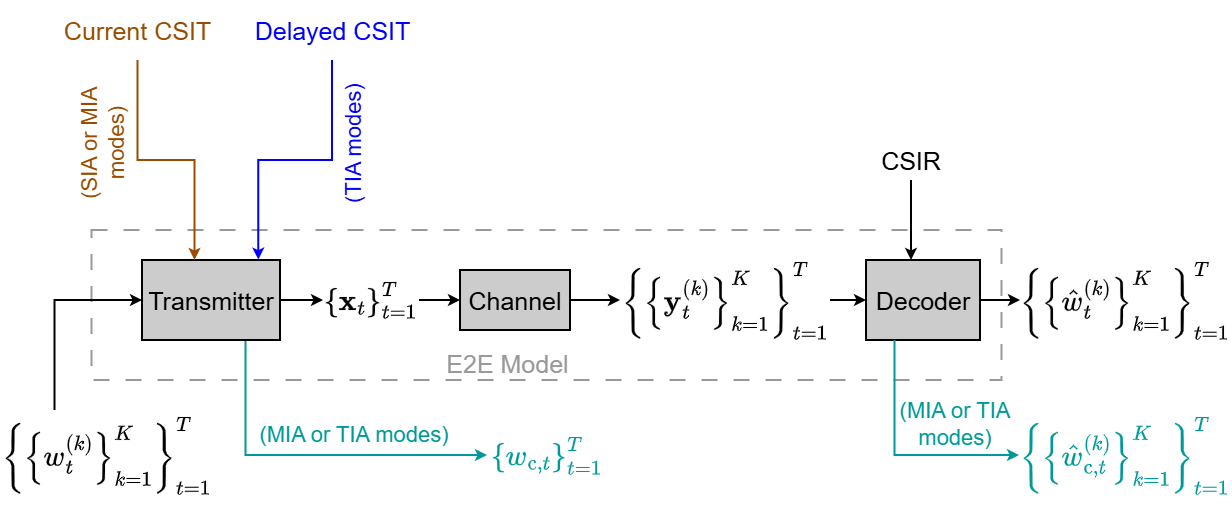

Figure 1. The proposed Deep-STMIA E2E architecture for MU-MISO BC is represented, where the inputs and outputs of the transmitter and decoder blocks depend on the IA techniques applied (SIA, MIA, and TIA modes). The Decoder block includes K receivers [1, Figure 1].

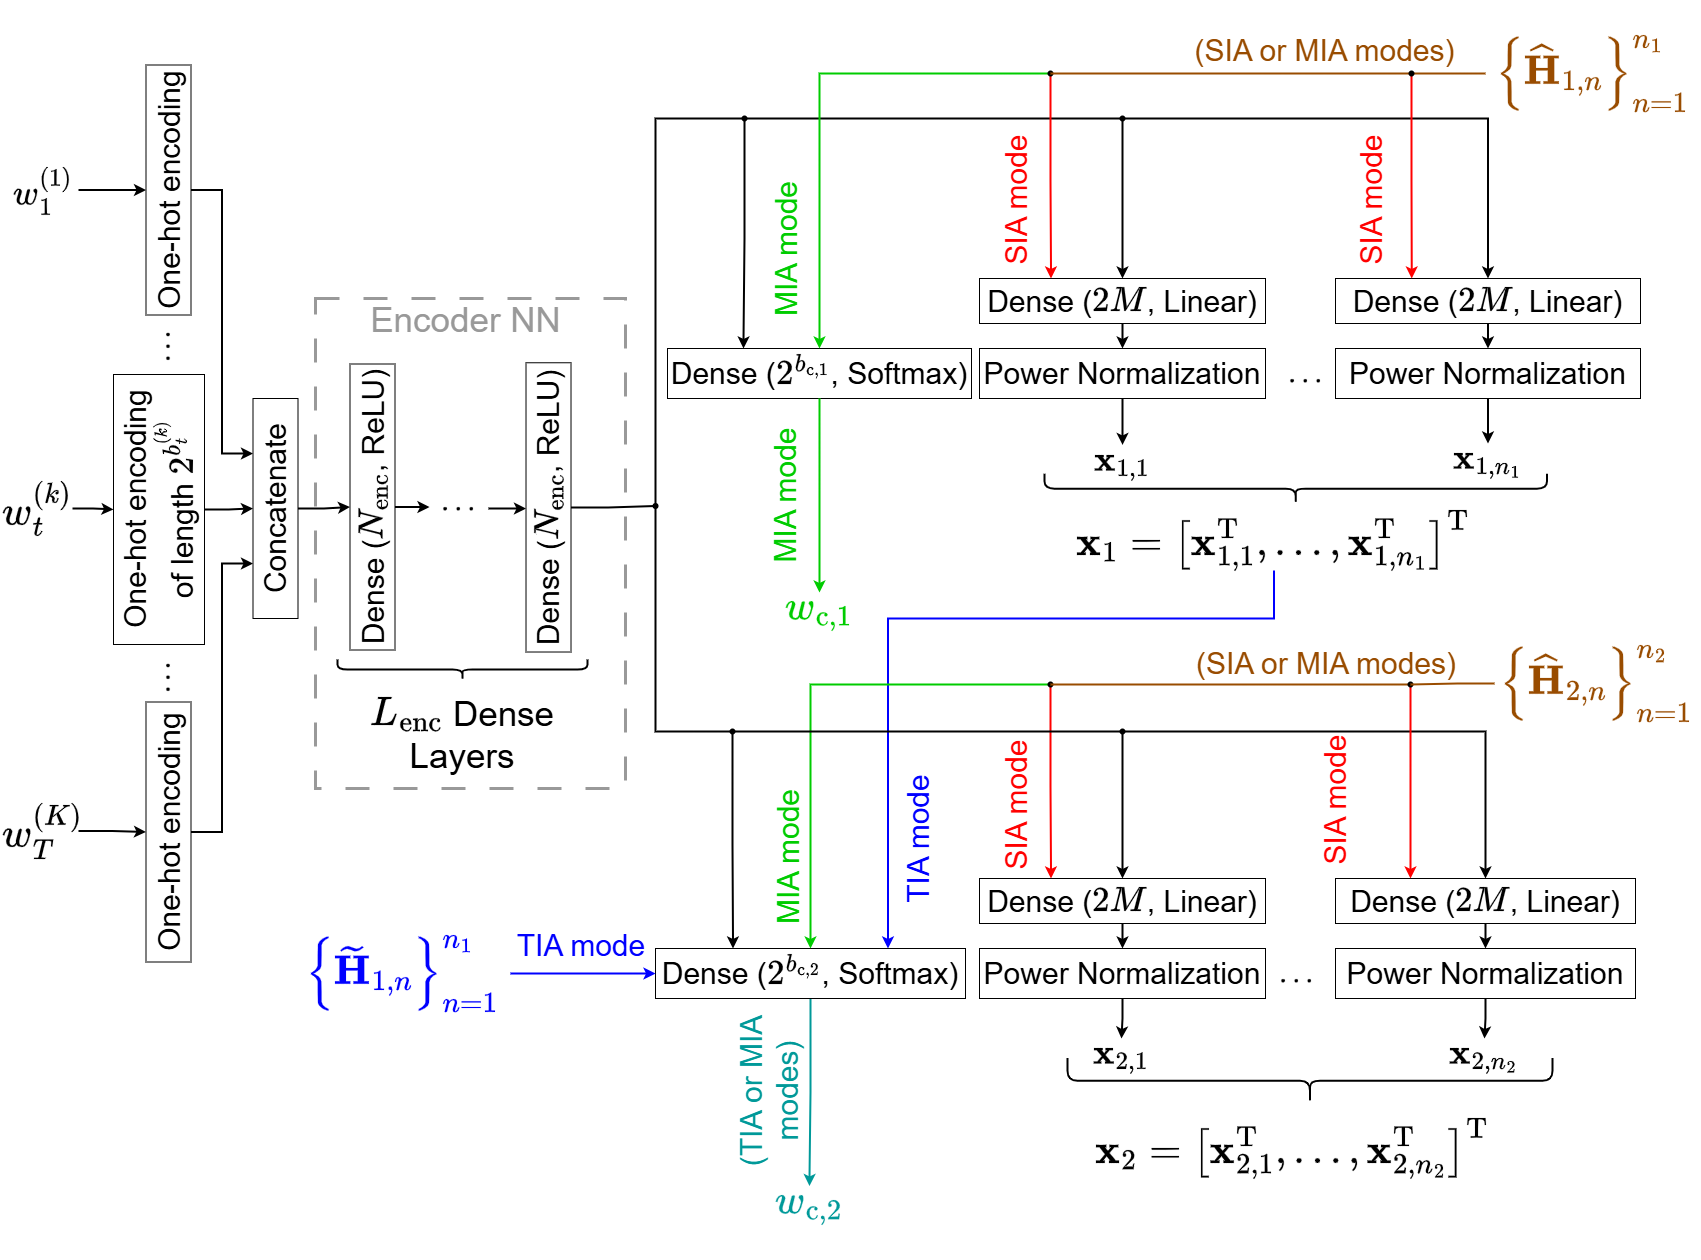

Figure 2. The Deep-STMIA transmitter block for $T = 2$ [1, Figure 3].

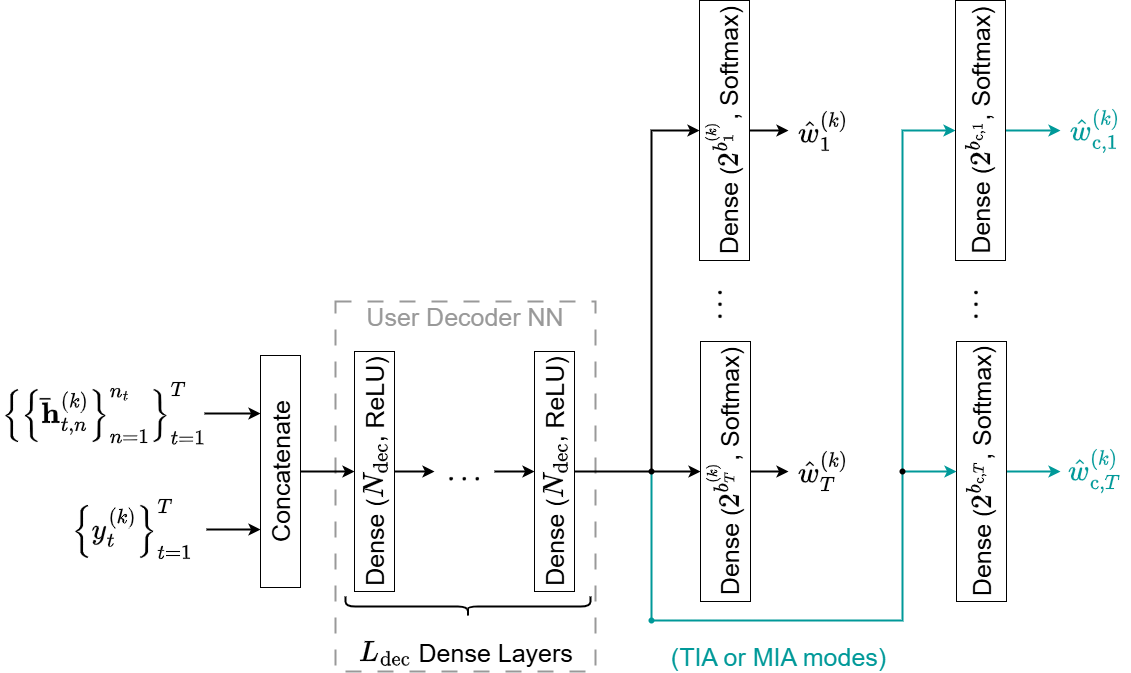

Figure 3. The Deep-STMIA decoder block at user $k \in \left\{1,\dots,K\right\}$ is represented [1, Figure 4].

# 2. Generating the Users' Messages

Parameters:

In [ ]:
K = 2 # Number of users
T = 2 # Number of time intervals

b = 4 # Number of information bits
n = 5 # Codeword length

b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of information bits in each message of user k (k=1,...,K) in each time interval t (t=1,...T)
n_t = np.ones((T,),dtype=np.int32)*n # Codeword length in each time interval t (t=1,...,T)

n_samples = 100 # Number of samples

Generating users' messages and their one-hot encoding:

In [ ]:
messages_one_hot_list = []
for t in range(T):
    for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

Examples:

In [ ]:
print(len(messages_one_hot_list))
count = 0
for t in range(T):
    for k in range(K):
        print(messages_one_hot_list[count].shape,f', lenght: {2**b_t_k[t,k]}')
        count += 1

4
(100, 16) , lenght: 16
(100, 16) , lenght: 16
(100, 16) , lenght: 16
(100, 16) , lenght: 16


In [ ]:
messages_one_hot_list_batch = [messages_one_hot_list[i][:3] for i in range(len(messages_one_hot_list))]
messages_one_hot_list_batch

[<tf.Tensor: shape=(3, 16), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],
       dtype=float32)>,
 <tf.Tensor: shape=(3, 16), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 <tf.Tensor: shape=(3, 16), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],
       dtype=float32)>,
 <tf.Tensor: shape=(3, 16), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

# 3. Generating Channel, Current and Delayed CSIT, and CSIR Samples


Parameters:

In [ ]:
TIA_mode = True # The mode of using delayed CSIT for retrospective interference alignment
MIA_mode = True # The mode of using common message decoding for message domain regularization
SIA_mode = True # The mode of using current CSIT for space-domain interference alignment

T = 2 # Number of time intervals

K = 2 # Number of users
M = 2 # Number of BS antennas

b = 4 # Number of information bits
n = 5 # Codeword length

b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of information bits in each message of user k (k=1,...,K) in each time interval t (t=1,...T)
n_t = np.ones((T,),dtype=np.int32)*n # Codeword length in each time interval t (t=1,...,T)

n_samples = 100 # Number of samples

# CSI parameters
gam = 1 # CSIR parameter
alph = 0.5 # Current CSIT parameter
bet = 1 # Delayed CSIT parameter

# --- Noise power and SNR---
# Power constraint in each channel use is 1.0
Eb_N0_dB = 10 # dB
Eb_N0 = 10**(Eb_N0_dB/10)
snr = np.empty((T,))
noise_std = np.empty((T,))
for t in range(T):
  snr[t] = Eb_N0*b/(n_t[t]) # SNR in each time interval t (t=1,...,T)
  noise_std[t] = sqrt(0.5/snr[t]) # noise standard deviation in each time interval t (t=1,...,T)

Generating Channel, current and delayed CSIT, and CSIR samples:

In [ ]:
# --- Channel samples ---
channel_list = []
for t in range(T):
  for n_index in range(n_t[t]):
    channel_t_n = tf.random.normal(shape = [n_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
    channel_list.append(channel_t_n)

# --- CSIR and CSIT ---
# CSIR parameters:
csir_sigm = np.empty((T,))
for t in range(T):
  gam_P = gam*snr[t]/(snr[t]+1-gam)
  csir_sigm[t] = snr[t]**(-gam_P)

if SIA_mode or MIA_mode:
  # Current CSIT parameters:
  sigm = np.empty((T,))
  for t in range(T):
    alph_P = alph*snr[t]/(snr[t]+1-alph)
    sigm[t] = snr[t]**(-alph_P)

if TIA_mode:
  # Delayed CSIT parameters:
  sigma_FB = np.empty((T,))
  for t in range(T):
    bet_P = bet*snr[t]/(snr[t]+1-bet)
    sigma_FB[t] = snr[t]**(-bet_P)

csir_list = []
current_CSIT_list = []
delayed_CSIT_list = []
for t in range(T):
  for n_index in range(n_t[t]):

    channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

    # CSIR
    csir_t_n = tf.random.normal(shape = [n_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
    csir_list.append(channel_t_n - csir_t_n)

    # Current CSIT
    if SIA_mode or MIA_mode:
      current_ch_error_t_n = tf.random.normal(shape = [n_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
      current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

    # Delayed CSIT
    if TIA_mode and t < T-1:
      delayed_ch_error_t_n = tf.random.normal(shape = [n_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
      delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

Examples:

In [ ]:
print(len(channel_list))
count = 0
for t in range(T):
    for k in range(K):
        print(channel_list[count].shape,f', lenght: {K*2*M}')
        count += 1

10
(100, 2, 4) , lenght: 8
(100, 2, 4) , lenght: 8
(100, 2, 4) , lenght: 8
(100, 2, 4) , lenght: 8


In [ ]:
# channel at time t:
t = 0
print(len(channel_list[np.sum(n_t[:t]):np.sum(n_t[:(t+1)])]), f'lenght: {n_t[t]}')
# channel at time t and channel use n:
t = 0
n = 0 # n must be less than n_t[t]
print(tf.shape(channel_list[np.sum(n_t[:t]) + n]))

5 lenght: 5
tf.Tensor([100   2   4], shape=(3,), dtype=int32)


# 4. Setup and Layers Required for E2E System

Initial setup:

In [ ]:
import random as rd

import numpy as np
import tensorflow as tf
from math import ceil, log, log2, sqrt, floor

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# setting seeds for reproducibility
tf.random.set_seed(14)
tf.keras.utils.set_random_seed(14)

# Resetting the name counters
tf.keras.backend.clear_session()

Required layers:

In [ ]:
# --- Required layers ---
Input = tf.keras.layers.Input
Lambda = tf.keras.layers.Lambda
Layer = tf.keras.layers.Layer
Flatten = tf.keras.layers.Flatten
Concatenate = tf.keras.layers.Concatenate
Dense = tf.keras.layers.Dense
Model = tf.keras.Model

Power constraint function:

In [ ]:
def power_constraint_for_complex_signaling(x, power_limit = 1.0):
    """
    Applies an average power constraint of less than power_limit to the input vector x

    """
    ave_power = 2*tf.reduce_mean(tf.square(x), axis=0)
    scale_factors = tf.where(ave_power > power_limit,
                             tf.math.sqrt(power_limit / ave_power),
                             tf.ones_like(ave_power))
    return x * tf.expand_dims(scale_factors, axis=0)

Custom layer:

In [ ]:
# custom layer block
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, L, N, **kwargs):
        super().__init__(**kwargs)
        self.L = L
        self.N = N

        if self.L >= 1:
          self.hidden = [tf.keras.layers.Dense(self.N, activation="relu") for _ in range(self.L)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return Z

    # Add compute_output_shape for better shape inference
    def compute_output_shape(self, input_shape):
        # input_shape will be the shape of the concatenated input
        # The output shape will be (batch_size, N)
        return (input_shape[0], self.N)

Channel matrix layer:

In [ ]:
class ChannelMatrixLayer(Layer):
    """
    Custom Keras layer to apply the channel matrix in a vectorized manner.
    """
    def __init__(self, N, M, K, **kwargs):
        super(ChannelMatrixLayer, self).__init__(**kwargs)
        self.N = N
        self.M = M
        self.K = K

    def call(self, x):
        x_shape = tf.shape(x)
        batch_size = x_shape[0]

        # 1. Reshape the signal part of the tensor
        # The first 2*M*N elements represent the signals for N channel uses
        signal_tensor_flat = x[:, :2 * self.M * self.N]
        signal_tensor_reshaped = tf.reshape(signal_tensor_flat, (batch_size, self.N, self.M, 2))
        signal_real = signal_tensor_reshaped[:, :, :, 0]
        signal_imag = signal_tensor_reshaped[:, :, :, 1]

        # 2. Reshape the channel part of the tensor
        # The remaining elements are the channel vectors for K users across N channel uses
        channel_tensor_flat = x[:, 2 * self.M * self.N:]
        channel_tensor_reshaped = tf.reshape(channel_tensor_flat, (batch_size, self.N, self.K, self.M, 2))
        channel_real = channel_tensor_reshaped[:, :, :, :, 0]
        channel_imag = channel_tensor_reshaped[:, :, :, :, 1]

        # 3. Create complex tensors
        complex_signal = tf.complex(signal_real, signal_imag)
        complex_channel = tf.complex(channel_real, channel_imag)

        y_list = []
        for k in range(self.K):
            user_channel = complex_channel[:, :, k, :]
            y_k_complex = tf.reduce_sum(tf.multiply(complex_signal, user_channel), axis=-1)
            y_k_real = tf.math.real(y_k_complex)
            y_k_imag = tf.math.imag(y_k_complex)
            y_k = tf.concat([y_k_real, y_k_imag], axis=-1)
            y_list.append(y_k)

        y_out = tf.concat(y_list, axis=-1)
        return y_out

    def compute_output_shape(self, input_shape):
        # We need to specify the output shape so Keras can build the model graph
        return (input_shape[0], 2 * self.N * self.K)

# 5. Method `E2E_for_imperfect_CSIT`: Setting Hyperparameters, Creating Models, and Training

The method output is the trained transmitter, channel, and receivers:

In [ ]:
def E2E_for_imperfect_CSIT(K, M, T, n_t, b_t_k, b_c_t, mu_user, mu_c = 1, training_Eb_N0_dB = 20, gam = 0.8, alph = 0.3, bet = 0.8,
                           SIA_mode = False, MIA_mode = False, TIA_mode = False,
                           L_enc = 2, N_enc = 64, L_dec = 2, N_dec = 64,
                           n_samples = 50_000, epochs = 50, batch_size = 1024, learning_rate1 = 0.005, learning_rate2 = 0.001,
                           progress_print = True):
  if T == 1:
    TIA_mode = False

  if TIA_mode == False:
    T = 1

  # 1. Power constraint and noise power=========================================
  # --- Noise power ---
  Eb_N0 = 10**(training_Eb_N0_dB/10)
  snr = np.empty((T,))
  noise_std = np.empty((T,))
  for t in range(T):
    snr[t] = Eb_N0*b/(n_t[t])
    noise_std[t] = sqrt(0.5/snr[t])
  # Power constraint in each channel use is 1.0
  # 2. Messages=================================================================
  messages_one_hot_list = []
  for t in range(T):
      for k in range(K):
          messages_t_k = tf.random.uniform(shape=(n_samples,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
          messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

  # 3. Channel, CSIT, and CSIR==================================================
  # Channel ===
  channel_list = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = tf.random.normal(shape = [n_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
      channel_list.append(channel_t_n)

  # --- CSIR and CSIT ---
  # CSIR parameters:
  csir_sigm = np.empty((T,))
  for t in range(T):
    gam_P = gam*snr[t]/(snr[t]+1-gam)
    csir_sigm[t] = snr[t]**(-gam_P)

  if SIA_mode or MIA_mode:
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

  if TIA_mode:
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

  csir_list = []
  current_CSIT_list = []
  delayed_CSIT_list = []
  for t in range(T):
    for n_index in range(n_t[t]):

      channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

      # CSIR
      csir_t_n = tf.random.normal(shape = [n_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
      csir_list.append(channel_t_n - csir_t_n)

      # Current CSIT
      if SIA_mode or MIA_mode:
        current_ch_error_t_n = tf.random.normal(shape = [n_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
        current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

      # Delayed CSIT
      if TIA_mode and t < T-1:
        delayed_ch_error_t_n = tf.random.normal(shape = [n_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
        delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

  # 4. Creating Models==========================================================
  # 4.1 Required layers --------------------------------------------------------
  Input = tf.keras.layers.Input
  Layer = tf.keras.layers.Layer
  Lambda = tf.keras.layers.Lambda
  Flatten = tf.keras.layers.Flatten
  Concatenate = tf.keras.layers.Concatenate
  Dense = tf.keras.layers.Dense
  Model = tf.keras.Model

  # 4.2 Tx----------------------------------------------------------------------
  tx_input1 = [Input(shape=(2**b_t_k[t,k],), dtype=tf.float32, name=f'tx_input_one_hot_user_messages_{t}_{k}') for t in range(T) for k in range(K)]
  if SIA_mode or MIA_mode:
    tx_input2 = [Input(shape=(K,2*M,), dtype=tf.float32, name=f'tx_input_current_csit_slot_{t}_{n_index}') for t in range(T) for n_index in range(n_t[t])]
  else:
    tx_input2 = []
  if TIA_mode:
    tx_input3 = [Input(shape=(K,2*M,), dtype=tf.float32, name=f'tx_input_delayed_csit_slot_{t}_{n_index}') for t in range(T-1) for n_index in range(n_t[t])]
  else:
    tx_input3 = []

  # Flatten the list of lists for input to the model
  input = tx_input1 + tx_input2 + tx_input3

  # --- Transmitter model ---
  # --- Processing user messages ---
  input_user_messages = Concatenate()(tx_input1)
  processed_messages = CustomLayer(L=L_enc, N=N_enc)(input_user_messages)

  # --- Encoder and Common Message Generator ---
  Tx_out_enc = []
  Tx_out_common = []
  old_enc_output = None
  for t in range(T):
    # Flattening current CSIT ---
    current_csit_t_list = []
    if SIA_mode or MIA_mode:
      for n_index in range(n_t[t]):
        # Calculate the correct index for tx_input2 for the current time interval
        current_csit_index_t_n = np.sum(n_t[:t]) + n_index
        # Flatten current CSIT matrices
        current_csit_t_n = tx_input2[current_csit_index_t_n]
        current_csit_t_n_flattened = Flatten()(current_csit_t_n)
        current_csit_t_list.append(current_csit_t_n_flattened)

    # Flatteing delayed CSIT ---
    delayed_csit_t_list = []
    if TIA_mode and t > 0:
      for n_index in range(n_t[t-1]):
        # Calculate the correct index for tx_input3 for the previous time interval
        delayed_csit_index_t_n = np.sum(n_t[:t-1]) + n_index
        # Flatten delayed CSIT matrices
        delayed_csit_t_n = tx_input3[delayed_csit_index_t_n]
        delayed_csit_t_n_flattened = Flatten()(delayed_csit_t_n)
        delayed_csit_t_list.append(delayed_csit_t_n_flattened)

    # Common message generator (CMG) at time t ---
    if MIA_mode or (TIA_mode and t > 0):
      if MIA_mode and TIA_mode and t > 0:
        TIA_input = Concatenate()([old_enc_output] + delayed_csit_t_list)
        cmg_t_input = Concatenate()([processed_messages] + current_csit_t_list + [TIA_input])

      elif MIA_mode:
        cmg_t_input = Concatenate()([processed_messages] + current_csit_t_list)

      elif TIA_mode and t > 0:
        TIA_input = Concatenate()([old_enc_output] + delayed_csit_t_list)
        cmg_t_input = TIA_input

      cmg_t_output = Dense(2**b_c_t[t], activation="softmax",kernel_initializer='zeros')(cmg_t_input)

    # Encoder at time t ---
    enc_t_output_list = []
    if SIA_mode:
      enc_t_input = Concatenate()([processed_messages] + current_csit_t_list)
    else:
      enc_t_input = processed_messages
    for n_index in range(n_t[t]):
      enc_t_n_output = Dense(2*M, activation="linear")(enc_t_input)
      enc_t_n_output = Lambda(lambda x: power_constraint_for_complex_signaling(x, power_limit = 1.0), output_shape = (2*M,))(enc_t_n_output)
      enc_t_output_list.append(enc_t_n_output)
    enc_t_output = Concatenate(axis = -1)(enc_t_output_list)


    # Saving encoder output for TIA generator in next time interval
    old_enc_output = enc_t_output

    # Saving transmitter outputs
    Tx_out_enc.append(enc_t_output)
    if MIA_mode or (TIA_mode and t > 0):
      Tx_out_common.append(cmg_t_output)

  # Create the overall Transmitter model
  Tx = Model(inputs = input, outputs = Tx_out_enc + Tx_out_common)
  # 4.3 Channel-----------------------------------------------------------------
  ch_input1 = [Input(shape=(2*M*n_t[t],), dtype=tf.float32, name=f'ch_input_encoded_signals_{t}') for t in range(T)]
  ch_input2 = [Input(shape=(K,2*M,), dtype=tf.float32, name=f'ch_input_channel_matrix_{t}_{n_index}') for t in range(T) for n_index in range(n_t[t])]

  ch_output = []

  for t in range(T):
    ch_t_list = []
    # --- Flattening channel matrices at time t ---
    for n_index in range(n_t[t]):
      # Flatten channel matrices
      ch_t_n = ch_input2[np.sum(n_t[:t]) + n_index]
      ch_t_n_flattened = Flatten()(ch_t_n)
      ch_t_list.append(ch_t_n_flattened)
    # --- Applying channel matrices to the encoded signal at time t ---
    ch_input_t = Concatenate()([ch_input1[t]] + ch_t_list)
    ch_output_t = ChannelMatrixLayer(N=n_t[t], M=M, K=K)(ch_input_t)
    ch_output.append(ch_output_t) # Append the concatenated output for each time interval

  ch_model = Model(inputs = ch_input1 + ch_input2, outputs = ch_output)
  # 4.4 Decoder-----------------------------------------------------------------
  decoder_input1 = [Input(shape=(2*n_t[t]*K,), dtype=tf.float32, name=f'decoder_input_received_signal_{t}') for t in range(T)]
  decoder_input2 = [Input(shape=(K,2*M,), dtype=tf.float32, name=f'decoder_input_csir_matrix_{t}_{n_index}') for t in range(T) for n_index in range(n_t[t])]

  user_messages_output_list = [] # Decoded user messages during T time intervals
  common_messages_output_list = [] # Decoded common messages during T time intervals

  for k in range(K):
    # --- Decoder at user k ---
    user_messages_output_list_at_user_k = [] # Decoded messages of user k during T time intervals
    common_messages_output_list_at_user_k = [] # Decoded common messages during T time intervals at user k

    # --- Received signals of user k ----
    input_received_signal_k = []
    for t in range(T):
      input_received_signal_k.append(decoder_input1[t][:,2*n_t[t]*k:2*n_t[t]*(k+1)])

    # --- CSIR at user k ---
    input_csir_at_k = []
    for t in range(T):
      for n_index in range(n_t[t]):
        input_csir_at_k.append(Flatten()(decoder_input2[np.sum(n_t[:t]) + n_index][:,k,:]))# Local CSIR


    decoder_k_input_t = Concatenate()(input_received_signal_k + input_csir_at_k)
    decoder_k_output_t = CustomLayer(L=L_dec, N=N_dec)(decoder_k_input_t)

    # --- Decoding the messages of user k and the common messages at user k ---
    for t in range(T):
      user_messages_output_list_at_user_k += [Dense(2**b_t_k[t,k], activation="softmax", kernel_initializer='glorot_uniform')(decoder_k_output_t)]
      if MIA_mode or (TIA_mode and t > 0 ):
        common_messages_output_list_at_user_k += [Dense(2**b_c_t[t], activation="softmax", kernel_initializer='glorot_uniform')(decoder_k_output_t)]

    # Saving outputs of users ---
    user_messages_output_list += user_messages_output_list_at_user_k
    if MIA_mode or TIA_mode:
      common_messages_output_list += common_messages_output_list_at_user_k


  # Rearranging outputs to make them compatible with  Tx outputs ---
  user_messages_output = [user_messages_output_list[T*k + t] for t in range(T) for k in range(K)]
  if MIA_mode or TIA_mode:
    if MIA_mode:
      common_messages_output = [common_messages_output_list[T*k + t] for t in range(T) for k in range(K)]
    else:
      common_messages_output = [common_messages_output_list[(T-1)*k + t] for t in range(T-1) for k in range(K)]
  else:
    common_messages_output = []

  Decoder= Model(inputs = decoder_input1 + decoder_input2, outputs = user_messages_output + common_messages_output)
  # 5. Training=================================================================
  num_batches = n_samples // batch_size
  optimizer1 = tf.keras.optimizers.Adam(learning_rate=learning_rate1)
  optimizer2 = tf.keras.optimizers.Adam(learning_rate=learning_rate2)

  # --- Initializing dynamic weights ---
  d_user = tf.Variable(tf.ones((T,K)))
  if MIA_mode or TIA_mode:
    d_c = tf.Variable(tf.ones(T))

  # --- Iterating over epochs ---
  for epoch in range(1, epochs + 1):

    # --- Printing progress ---
    if progress_print:
      print(f"Epoch {epoch}/{epochs}")

    # --- Iterating over batches ---
    for step in range(1, num_batches + 1):

        # --- user messages and channel matrices in a batch ---
        messages_list_batch = [messages_one_hot_list[i][batch_size * (step - 1): batch_size * step] for i in range(len(messages_one_hot_list))]
        channel_list_batch = [channel_list[i][batch_size * (step - 1): batch_size * step] for i in range(len(channel_list))]

        csir_list_batch = [csir_list[i][batch_size * (step - 1): batch_size * step] for i in range(len(csir_list))]
        if SIA_mode or MIA_mode:
          current_CSIT_list_batch = [current_CSIT_list[i][batch_size * (step - 1): batch_size * step] for i in range(len(current_CSIT_list))]
        else:
          current_CSIT_list_batch = []
        if TIA_mode:
          delayed_CSIT_list_batch = [delayed_CSIT_list[i][batch_size * (step - 1): batch_size * step] for i in range(len(delayed_CSIT_list))]
        else:
          delayed_CSIT_list_batch = []

        # --- Computing gradient ---
        with tf.GradientTape() as tape:
            # Tx
            tx_output = Tx(inputs = messages_list_batch + current_CSIT_list_batch + delayed_CSIT_list_batch, training=True)

            # Channel
            if MIA_mode or TIA_mode:
              enc_output = tx_output[:T]
              enc_common_output = tx_output[T:]
            else:
              enc_output = tx_output

            if T > 1:
              ch_output = ch_model(enc_output + channel_list_batch)
            else:
              ch_output = ch_model([enc_output] + channel_list_batch)
            # AWGN
            if T > 1:
              received_signal = []
              for t in range(T):
                received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
            else:
              received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

            # Decoder
            if T > 1:
              decoder_output = Decoder(received_signal + csir_list_batch, training = True)
            else:
              decoder_output = Decoder([received_signal] + csir_list_batch, training = True)

            if MIA_mode or TIA_mode:
              messages_pred_batch = decoder_output[:T*K]
              common_pred_batch = decoder_output[T*K:]
            else:
              messages_pred_batch = decoder_output

            # --- User messages loss ---
            static_weighted_user_losses_list = []
            for t in range(T):
              for k in range(K):
                if b_t_k[t,k] == 0:
                  loss_t_k = 0
                else:
                  loss_t_k = tf.keras.losses.CategoricalCrossentropy()(messages_list_batch[t * K + k], messages_pred_batch[t * K + k])
                static_weighted_user_losses_list.append(mu_user[k]*loss_t_k)
            static_weighted_user_losses = tf.reshape(tf.stack(static_weighted_user_losses_list), shape = (T,K))


            if MIA_mode or TIA_mode:
              # --- common messages loss ---
              static_weighted_common_losses_list = []
              for t in range(T):
                if b_c_t[t] == 0:
                  common_loss_t = 0
                else:
                  if MIA_mode == False:
                    enc_common_output_replicated_t = [enc_common_output[t-1] for k in range(K)]
                  else:
                    enc_common_output_replicated_t = [enc_common_output[t] for k in range(K)]
                  common_loss_t_list = []
                  for k in range(K):
                    if MIA_mode == False:
                      common_loss_t_list.append(tf.keras.losses.KLDivergence()(enc_common_output_replicated_t[k], common_pred_batch[(t-1) * K + k]))
                    else:
                      common_loss_t_list.append(tf.keras.losses.KLDivergence()(enc_common_output_replicated_t[k], common_pred_batch[t * K + k]))
                  common_loss_t = tf.reduce_max(tf.stack(common_loss_t_list))
                static_weighted_common_losses_list.append(mu_c*common_loss_t)
              static_weighted_common_losses = tf.reshape(tf.stack(static_weighted_common_losses_list), shape = (T,))

            # Total loss
            if MIA_mode or TIA_mode:
              loss = tf.reduce_sum(static_weighted_user_losses*d_user) + tf.reduce_sum(static_weighted_common_losses*d_c)
            else:
              loss = tf.reduce_sum(static_weighted_user_losses*d_user)

        gradients = tape.gradient(loss, Tx.trainable_variables + Decoder.trainable_variables)

        # --- Optimizing ---
        if epoch <= floor(epochs/2):
          optimizer = optimizer1
        else:
          optimizer = optimizer2
        optimizer.apply_gradients(zip(gradients, Tx.trainable_variables + Decoder.trainable_variables))

        #updating weight:
        if MIA_mode or TIA_mode:
          D = tf.reduce_sum(static_weighted_user_losses) + tf.reduce_sum(static_weighted_common_losses)
          d_user.assign(static_weighted_user_losses / (D + 1e-8))
          d_c.assign(static_weighted_common_losses / (D + 1e-8))
        else:
          D = tf.reduce_sum(static_weighted_user_losses)
          d_user.assign(static_weighted_user_losses / (D + 1e-8))

        # Printing status
        if progress_print:
          print_string = f"\r{step}/{num_batches} - "
          end = "" if step < num_batches else "\n"
          print_string += f"tot_loss: {loss:.3f}"
          print(print_string, end = end)
  return Tx, ch_model, Decoder

# 6. Evaluation: Perfect Current CSIT

-  There is no delayed CSIT: `TIA_mode = False` and `T=1`
-  As CSIT is perfect, no message-domain regularization is required: `MIA_mode = False` and the number of common bits is zero.
- Interference can be managed through space-domain alignment: `SIA_mode = True`


## 6.1. Learnt Signaling Plot and BLER Evaluation

simulation 1 is running: (n,b) = (1, 1)
Epoch 1/30
97/97 - tot_loss: 0.055
Epoch 2/30
97/97 - tot_loss: 0.024
Epoch 3/30
97/97 - tot_loss: 0.016
Epoch 4/30
97/97 - tot_loss: 0.012
Epoch 5/30
97/97 - tot_loss: 0.009
Epoch 6/30
97/97 - tot_loss: 0.009
Epoch 7/30
97/97 - tot_loss: 0.007
Epoch 8/30
97/97 - tot_loss: 0.007
Epoch 9/30
97/97 - tot_loss: 0.006
Epoch 10/30
97/97 - tot_loss: 0.006
Epoch 11/30
97/97 - tot_loss: 0.005
Epoch 12/30
97/97 - tot_loss: 0.007
Epoch 13/30
97/97 - tot_loss: 0.006
Epoch 14/30
97/97 - tot_loss: 0.005
Epoch 15/30
97/97 - tot_loss: 0.005
Epoch 16/30
97/97 - tot_loss: 0.004
Epoch 17/30
97/97 - tot_loss: 0.004
Epoch 18/30
97/97 - tot_loss: 0.004
Epoch 19/30
97/97 - tot_loss: 0.003
Epoch 20/30
97/97 - tot_loss: 0.004
Epoch 21/30
97/97 - tot_loss: 0.004
Epoch 22/30
97/97 - tot_loss: 0.003
Epoch 23/30
97/97 - tot_loss: 0.003
Epoch 24/30
97/97 - tot_loss: 0.003
Epoch 25/30
97/97 - tot_loss: 0.003
Epoch 26/30
97/97 - tot_loss: 0.003
Epoch 27/30
97/97 - tot_loss: 0.0

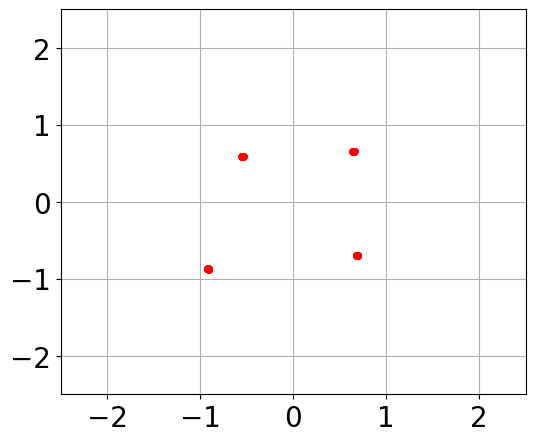

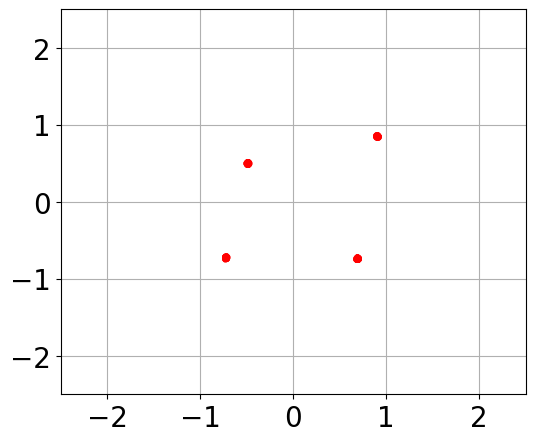

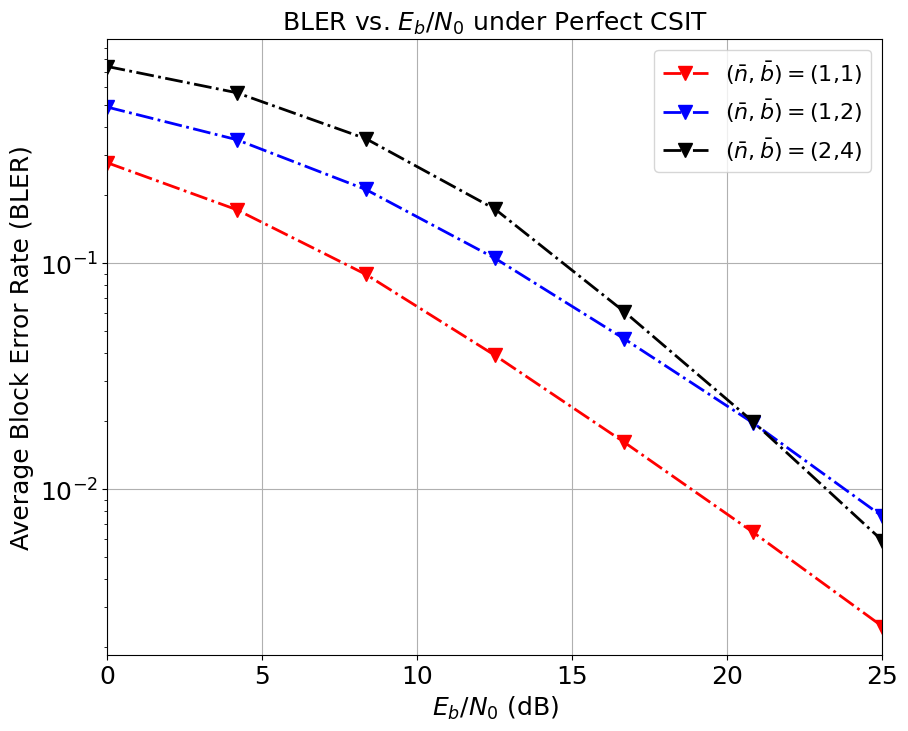

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

training_Eb_N0_dB = 30

mu_user = np.ones(K)
mu_c = 0

training_gam = 0.9 # Training CSIR parameter
training_alph = 0.9 # Training current CSIT parameter
training_bet = 0 # Training delayed CSIT parameter

gam = 1
alph = 1
bet = 0

L_enc = 3
N_enc = 64
L_dec = 1
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

SIA_mode = True
MIA_mode = False
TIA_mode = False

fig_count = 0
for (simulation_num, n, b) in [(1, 1, 1)]:
   #[(1, 1, 1), (2, 1, 2), (3, 2, 4)]:

  print(f'simulation {simulation_num} is running: (n,b) = ({n}, {b})')

  b_c = 0

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c_t = np.ones((T,),dtype=np.int32)*b_c # Number of bits in the common message of each time interval

  # setting seeds for reproducibility
  tf.random.set_seed(42)
  tf.keras.utils.set_random_seed(42)

  # Training====================================================================
  tf.keras.backend.clear_session() # Ensures a clean slate for each run
  Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                progress_print = True)
  # Plotting Symbols ===========================================================
  plot_samples = 500

  # --- Noise power ---
  Eb_N0_dB_plot = 20
  Eb_N0 = 10**(Eb_N0_dB_plot/10)
  snr = np.empty((T,))
  noise_std = np.empty((T,))
  for t in range(T):
    snr[t] = Eb_N0*b/(n_t[t])
    noise_std[t] = sqrt(0.5/snr[t])
  # Power constraint in each channel use is 1.0

  # --- Channel ---
  channel_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
      channel_list_sample.append(channel_t_n)

  # --- CSIR and CSIT ---
  # CSIR parameters:
  csir_sigm = np.empty((T,))
  for t in range(T):
    gam_P = gam*snr[t]/(snr[t]+1-gam)
    csir_sigm[t] = snr[t]**(-gam_P)

  if SIA_mode or MIA_mode:
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

  if TIA_mode:
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

  csir_list_sample = []
  current_CSIT_list_sample = []
  delayed_CSIT_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = channel_list_sample[np.sum(n_t[:t]) + n_index]

      # CSIR
      csir_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
      csir_list_sample.append(channel_t_n - csir_t_n)

      # Current CSIT
      if SIA_mode or MIA_mode:
        current_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
        current_CSIT_list_sample.append(channel_t_n - current_ch_error_t_n)

      # Delayed CSIT
      if TIA_mode and t < T-1:
        delayed_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
        delayed_CSIT_list_sample.append(channel_t_n - delayed_ch_error_t_n)

  # --- Messages ---
  messages_one_hot_list_sample = []
  for t in range(T):
      for k in range(K):
          messages_t_k = tf.random.uniform(shape=(plot_samples,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
          messages_one_hot_list_sample.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

  # --- Tx ---
  tx_output = Tx(inputs = messages_one_hot_list_sample + current_CSIT_list_sample + delayed_CSIT_list_sample)
  if MIA_mode:
    enc_output = tx_output[:T]
  else:
    enc_output = tx_output

  # --- Symbols Plot ---
  for t in range(T): # time interval
    for n_index in range(n_t[t]): # Channel use
      for i in range(M): # Antenna
        fig_count = fig_count + 1
        plt.figure(fig_count,figsize=(6, 5))
        # (i)th neuron and (i+M)th are respectively real and imaginary part of the (i)th element of the codeword:
        if MIA_mode or T > 1:
          plt.scatter(enc_output[t][:, n_index*2*M+i], enc_output[t][:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        else:
          plt.scatter(enc_output[:, n_index*2*M+i], enc_output[:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        plt.xlim([-2.5,2.5])
        plt.ylim([-2.5,2.5])
        #plt.title(r'$t=$' + f'{t+1}, ' + r'$n=$'+ f'{n_index+1}, ' + 'Antenna {i+1}')
        plt.tick_params(axis='both', labelsize=20)
        plt.grid()
        plt.savefig(f"Symbols_(n_b)_({n}_{b})_time_{t+1}_channel_use_{n_index+1}_antenna_{i+1}_Simulation_1.png")

  # BLER Evaluation=============================================================
  n_samples_eval = 50_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)
  for i in range(Eb_N0_dB_eval_num):
    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])
    # Power constraint in each channel use is 1.0

    # Messages ===
    messages_one_hot_list = []
    for t in range(T):
      for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    if SIA_mode or MIA_mode:
      # Current CSIT parameters:
      sigm = np.empty((T,))
      for t in range(T):
        alph_P = alph*snr[t]/(snr[t]+1-alph)
        sigm[t] = snr[t]**(-alph_P)

    if TIA_mode:
      # Delayed CSIT parameters:
      sigma_FB = np.empty((T,))
      for t in range(T):
        bet_P = bet*snr[t]/(snr[t]+1-bet)
        sigma_FB[t] = snr[t]**(-bet_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
        csir_list.append(channel_t_n - csir_t_n)

        # Current CSIT
        if SIA_mode or MIA_mode:
          current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
          current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # Delayed CSIT
        if TIA_mode and t < T-1:
          delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

    # --- Tx ---
    tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

    # --- Channel ---
    if MIA_mode:
      enc_output = tx_output[:T]
    else:
      enc_output = tx_output

    if T > 1:
      ch_output = ch_model(enc_output + channel_list)
    else:
      ch_output = ch_model([enc_output] + channel_list)

    # --- AWGN ---
    if T > 1:
      received_signal = []
      for t in range(T):
        received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
    else:
      received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

    # --- Decoder ---
    if T > 1:
      decoder_output = Decoder(received_signal + csir_list)
    else:
      decoder_output = Decoder([received_signal] + csir_list)

    if MIA_mode or TIA_mode:
      messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
    else:
      messages_prediction_prob = decoder_output # predicted user messages as probability vectors

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_one_hot_list[t * K + k].numpy().argmax(axis = -1) !=
                                      messages_prediction_prob[t * K + k].numpy().argmax(axis = -1)) / n_samples_eval
        if b_t_k[t,k] != 0:
          mean_BLER_count += b_t_k[t,k]
          mean_BLER[i] = mean_BLER[i] + BLER[t,k]*b_t_k[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/mean_BLER_count

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'$(\bar{n},\bar{b})=$' + f'({n},{b})'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$(\bar{n},\bar{b})=$' + f'({n},{b})'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$(\bar{n},\bar{b})=$' + f'({n},{b})'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-.v', markersize=10, linewidth = 2, label = label2)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-.v', markersize=10, linewidth = 2, label = label3)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
plt.title('BLER vs. ' + r'$E_b/N_0$ under Perfect CSIT', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_SIA_alpha_{alph}.png')

## 6.2. BLER vs. $\frac{E_b}{N_0}$: [1, Figure 5]

**Note:** The baselines BLER values (`mean_BLER1_base`, `mean_BLER2_base`, `mean_BLER3_base`) are obtained in **Section ... of `Baselines.ipynb`**, and the BLER values of Deep-STMIA (`mean_BLER1`, `mean_BLER2`, `mean_BLER3`) is obtained in **Section 6.1** above with the following setting:
-  `M=K=2`
-  `T = 1`
-  `Seed: 42`
-  `training_Eb_N0_dB = 30 dB`
-  `training_gam = 0.9`
-  `training_alph = 0.9`
-  `training_bet = 0`
-  `L_enc = 3`
-  `L_dec = 1`
-  `N_enc = 64`
-  `N_dec = 64`

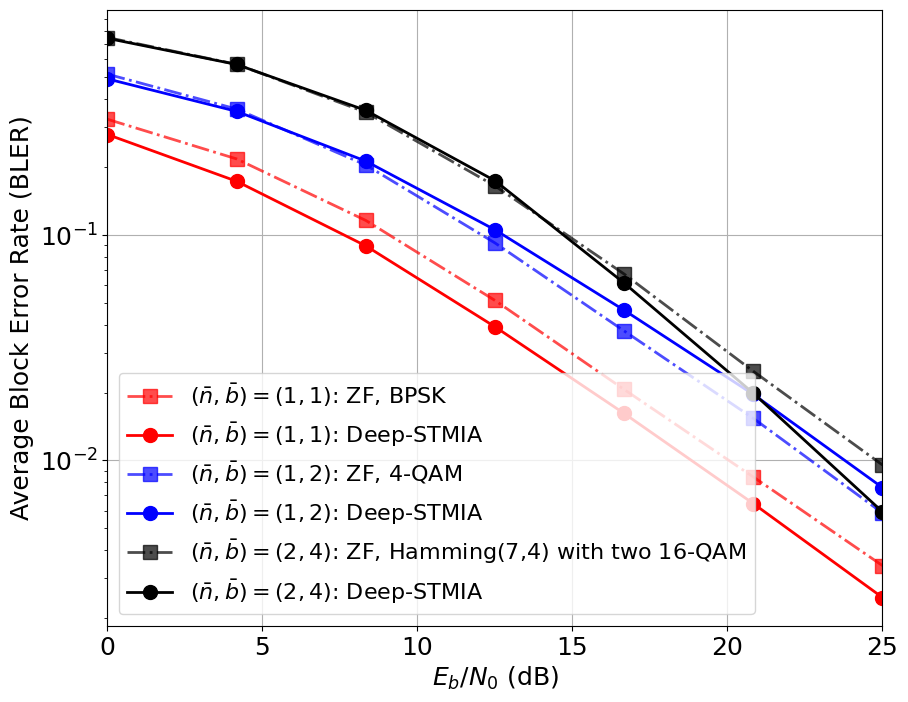

In [ ]:
M = 2
K = 2
alph = 1
Eb_N0_dB_eval_num = 7
Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

# (n,b)=(1,1)
mean_BLER1_base = np.array([0.32493, 0.21683, 0.11574, 0.05117, 0.02063, 0.00845, 0.00342])
label1_base = r'$(\bar{n},\bar{b})=(1,1)$: ZF, BPSK'

mean_BLER1 = np.array([0.27819, 0.17261, 0.08930, 0.03911, 0.01615, 0.00644, 0.00247])
label1 = r'$(\bar{n},\bar{b})=(1,1)$: Deep-STMIA' #+ r', $L_\text{enc}=3, L_\text{dec}=1, b_{\text{c},1}=0$'

# (n,b)=(1,2)
mean_BLER2_base = np.array([0.51496, 0.36065, 0.20376, 0.09201, 0.03749, 0.01537, 0.00585])
label2_base = r'$(\bar{n},\bar{b})=(1,2)$: ZF, 4-QAM'

mean_BLER2 = np.array([0.49060, 0.35224, 0.21200, 0.10520, 0.04632, 0.01962, 0.00758])
label2 = r'$(\bar{n},\bar{b})=(1,2)$: Deep-STMIA' #+ r', $L_\text{enc}=3, L_\text{dec}=1, b_{\text{c},1}=0$'

# (n,b)=(2,4)
mean_BLER3_base = np.array([0.74828, 0.56945, 0.34914, 0.16464, 0.06698, 0.02484, 0.00955])
label3_base = r'$(\bar{n},\bar{b})=(2,4)$: ZF, Hamming(7,4) with two 16-QAM'

mean_BLER3 = np.array([0.74208, 0.56834, 0.35581, 0.17360, 0.06110, 0.01986, 0.00592])
mean_BLER3 = np.array([0.74208, 0.56834, 0.35581, 0.17360, 0.06110, 0.01986, 0.00592])
label3 = r'$(\bar{n},\bar{b})=(2,4)$: Deep-STMIA' #+ r', $L_\text{enc}=3, L_\text{dec}=1, b_{\text{c},1}=0$'


# --- BLER plot ---
fig_count = 0
plt.figure(fig_count+1,figsize=(10, 8))

BLER_plot1_base, = plt.plot(Eb_N0_dB_eval, mean_BLER1_base, 'r-.s', markersize=10, linewidth = 2, label = label1_base)
BLER_plot1_base.set_alpha(0.7)
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-o', markersize=10, linewidth = 2, label = label1)

BLER_plot2_base, = plt.plot(Eb_N0_dB_eval, mean_BLER2_base, 'b-.s', markersize=10, linewidth = 2, label = label2_base)
BLER_plot2_base.set_alpha(0.7)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', markersize=10, linewidth = 2, label = label2)

BLER_plot3_base, = plt.plot(Eb_N0_dB_eval, mean_BLER3_base, 'k-.s', markersize=10, linewidth = 2, label = label3_base)
BLER_plot3_base.set_alpha(0.7)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-o', markersize=10, linewidth = 2, label = label3)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$ [1, Figure 5]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_SIA_alpha_{alph}.png')

# 7. Evaluation: No CSIT

Since there is no CSIT, none of TIA, SIA, and MIA techniques is possible:
-  `TIA_mode = False`
-  `MIA_mode = False`
-  `SIA_mode = False`


## 7.1. Learnt Signaling Plot and BLER Evaluation

simulation 1 is running: (n,b) = (2, 1)
Epoch 1/30
97/97 - tot_loss: 0.046
Epoch 2/30
97/97 - tot_loss: 0.017
Epoch 3/30
97/97 - tot_loss: 0.011
Epoch 4/30
97/97 - tot_loss: 0.009
Epoch 5/30
97/97 - tot_loss: 0.007
Epoch 6/30
97/97 - tot_loss: 0.006
Epoch 7/30
97/97 - tot_loss: 0.005
Epoch 8/30
97/97 - tot_loss: 0.005
Epoch 9/30
97/97 - tot_loss: 0.005
Epoch 10/30
97/97 - tot_loss: 0.006
Epoch 11/30
97/97 - tot_loss: 0.003
Epoch 12/30
97/97 - tot_loss: 0.006
Epoch 13/30
97/97 - tot_loss: 0.004
Epoch 14/30
97/97 - tot_loss: 0.004
Epoch 15/30
97/97 - tot_loss: 0.003
Epoch 16/30
97/97 - tot_loss: 0.005
Epoch 17/30
97/97 - tot_loss: 0.004
Epoch 18/30
97/97 - tot_loss: 0.003
Epoch 19/30
97/97 - tot_loss: 0.006
Epoch 20/30
97/97 - tot_loss: 0.003
Epoch 21/30
97/97 - tot_loss: 0.003
Epoch 22/30
97/97 - tot_loss: 0.006
Epoch 23/30
97/97 - tot_loss: 0.002
Epoch 24/30
97/97 - tot_loss: 0.004
Epoch 25/30
97/97 - tot_loss: 0.003
Epoch 26/30
97/97 - tot_loss: 0.004
Epoch 27/30
97/97 - tot_loss: 0.0

/tmp/ipython-input-632609268.py:285: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(fig_count+1,figsize=(10, 8))


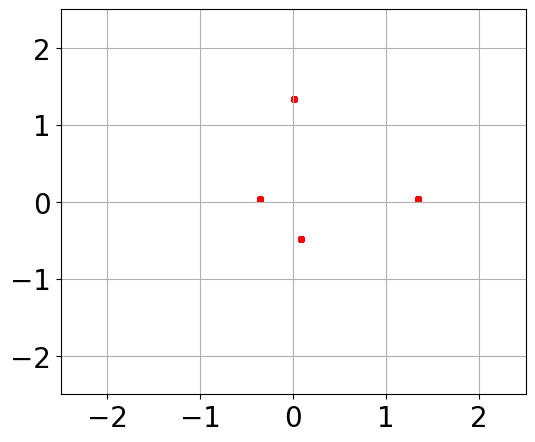

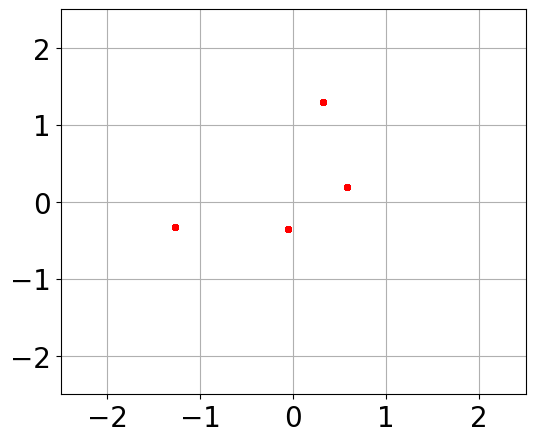

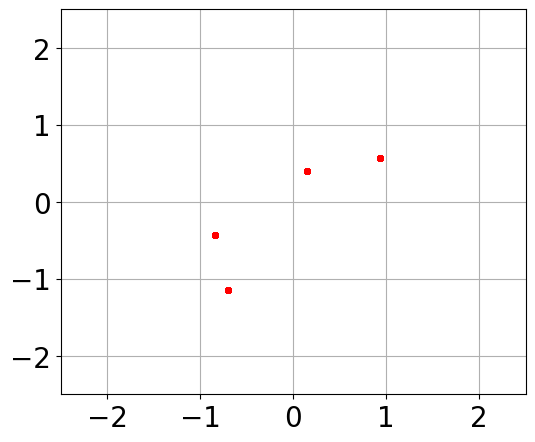

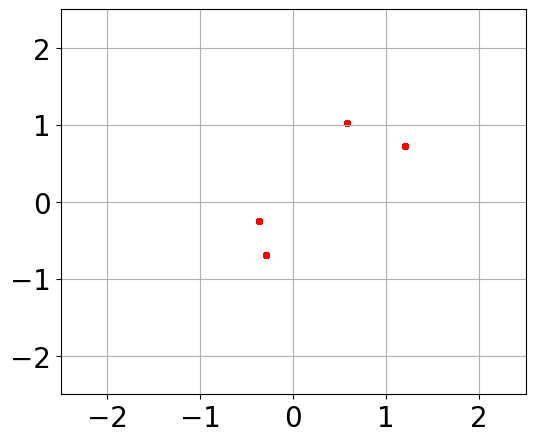

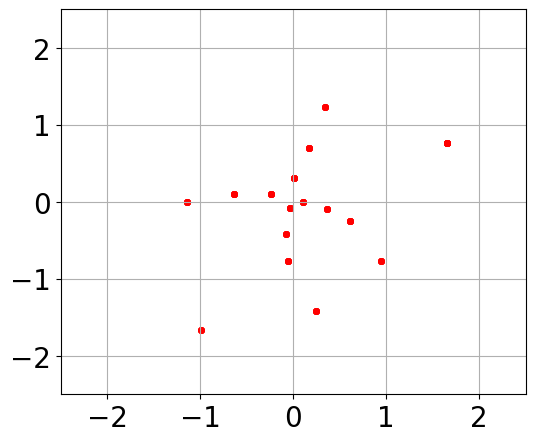

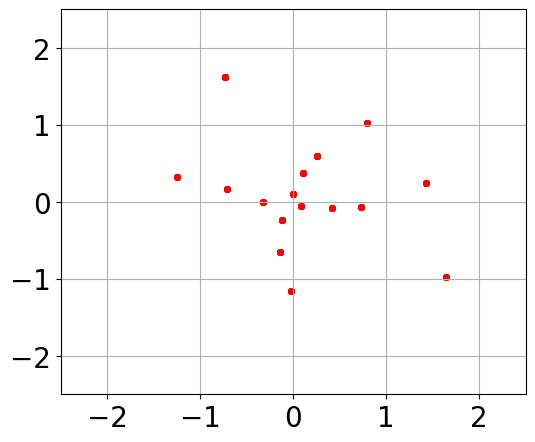

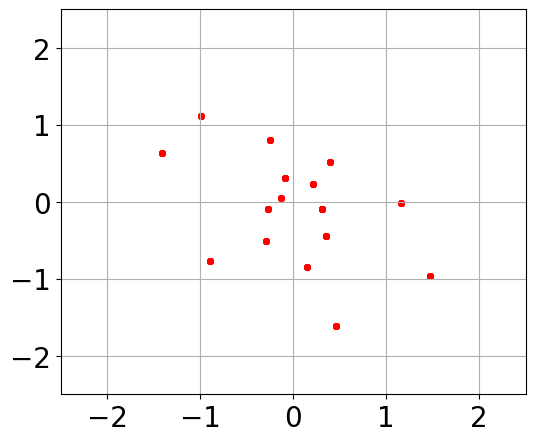

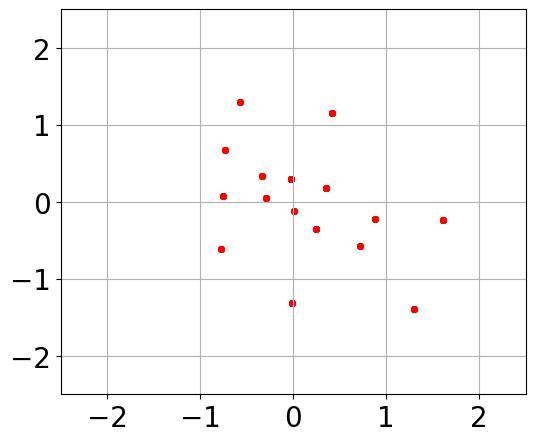

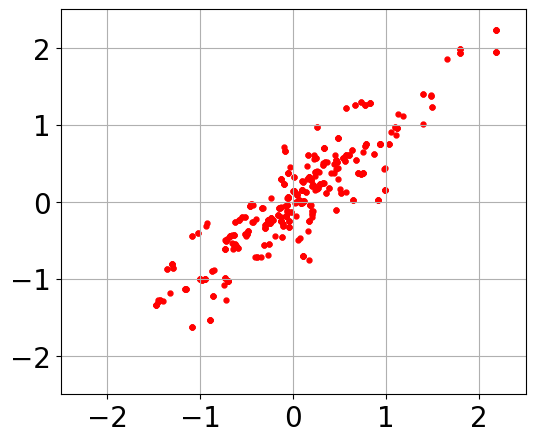

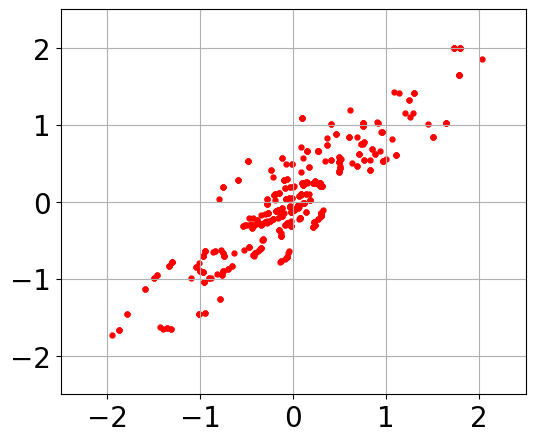

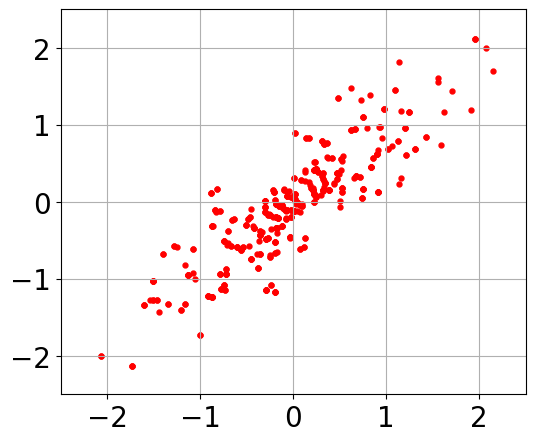

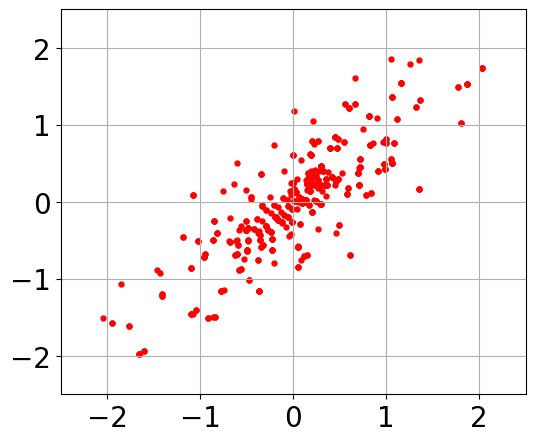

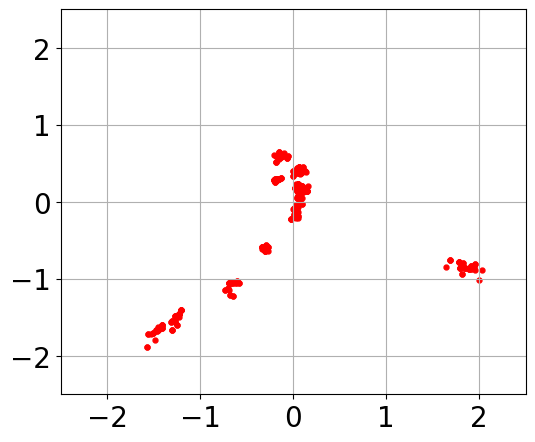

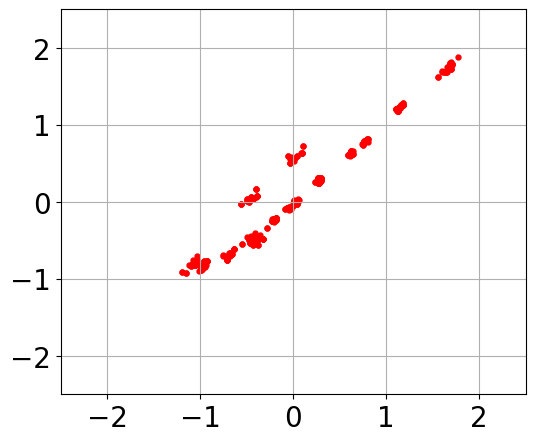

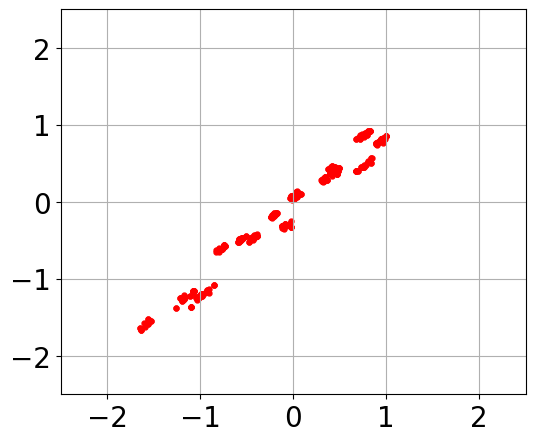

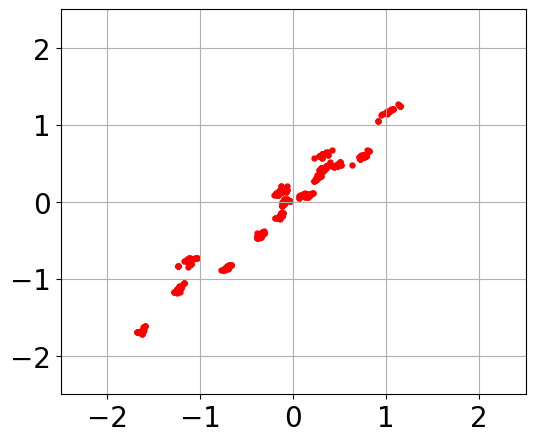

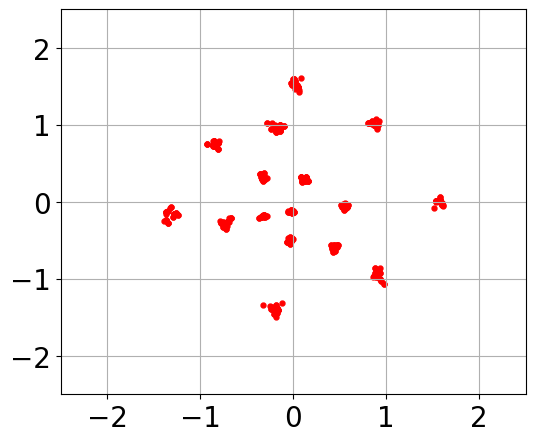

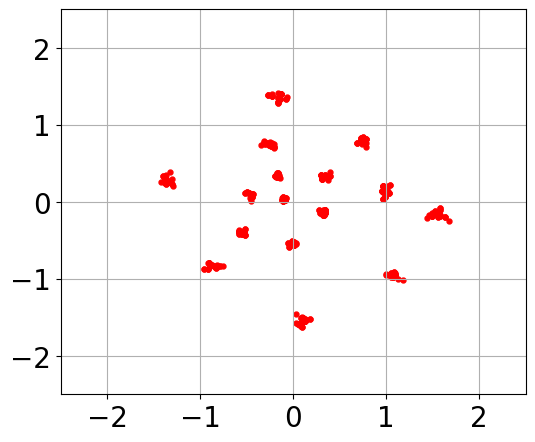

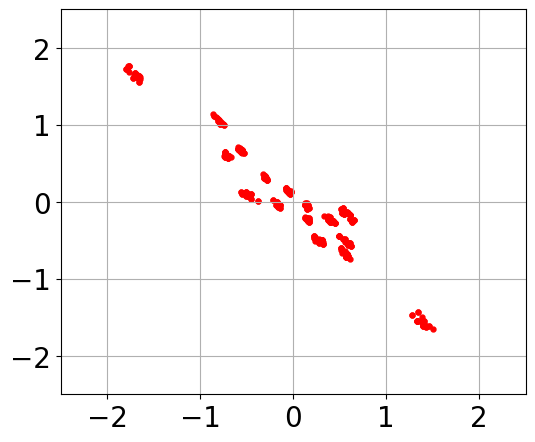

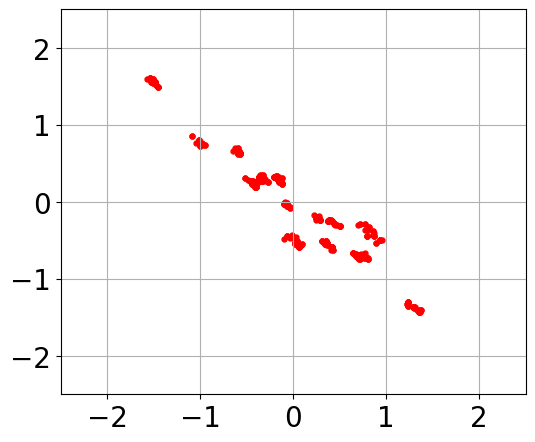

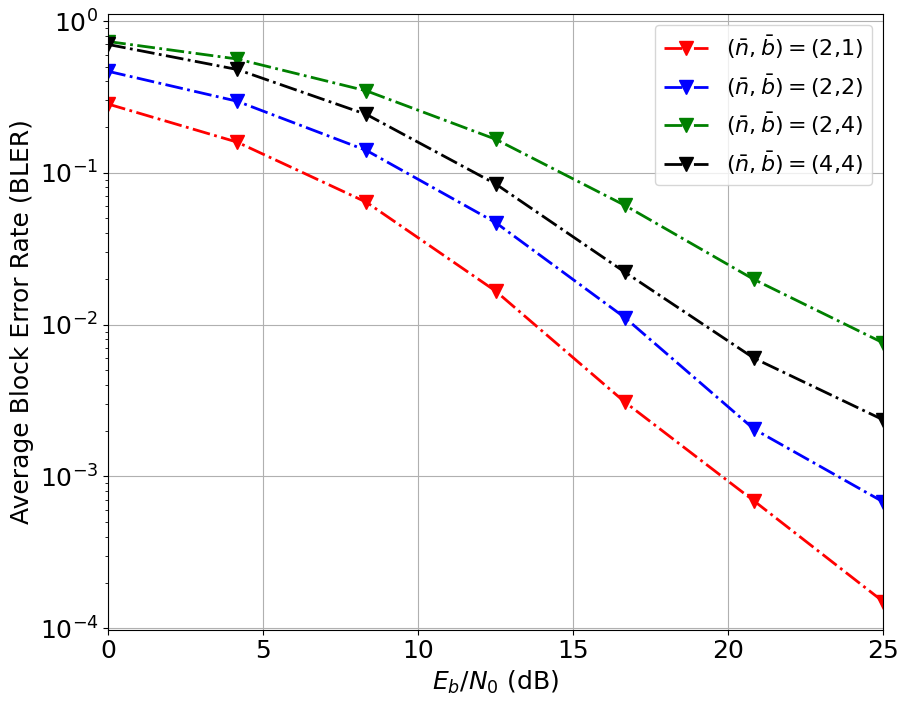

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

training_Eb_N0_dB = 20

mu_user = np.ones(K)
mu_c = 0

training_gam = 0.8 # Training CSIR parameter
training_alph = 0 # Training current CSIT parameter
training_bet = 0 # Training delayed CSIT parameter

gam = 1
alph = 0
bet = 0

L_enc = 3
N_enc = 64
L_dec = 1
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

SIA_mode = False
MIA_mode = False
TIA_mode = False

fig_count = 0
for (simulation_num, n, b) in [(1, 2, 1), (2, 2, 2), (3, 2, 4), (4, 4, 4)]:


  print(f'simulation {simulation_num} is running: (n,b) = ({n}, {b})')

  b_c = 0

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c_t = np.ones((T,),dtype=np.int32)*b_c # Number of bits in the common message of each time interval

  # setting seeds for reproducibility
  tf.random.set_seed(42)
  tf.keras.utils.set_random_seed(42)

  # Training====================================================================
  tf.keras.backend.clear_session() # Ensures a clean slate for each run
  Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                progress_print = True)
  # Plotting Symbols ===========================================================
  plot_samples = 500

  # --- Noise power ---
  Eb_N0_dB_plot = 20
  Eb_N0 = 10**(Eb_N0_dB_plot/10)
  snr = np.empty((T,))
  noise_std = np.empty((T,))
  for t in range(T):
    snr[t] = Eb_N0*b/(n_t[t])
    noise_std[t] = sqrt(0.5/snr[t])
  # Power constraint in each channel use is 1.0

  # --- Channel ---
  channel_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
      channel_list_sample.append(channel_t_n)

  # --- CSIR and CSIT ---
  # CSIR parameters:
  csir_sigm = np.empty((T,))
  for t in range(T):
    gam_P = gam*snr[t]/(snr[t]+1-gam)
    csir_sigm[t] = snr[t]**(-gam_P)

  if SIA_mode or MIA_mode:
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

  if TIA_mode:
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

  csir_list_sample = []
  current_CSIT_list_sample = []
  delayed_CSIT_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = channel_list_sample[np.sum(n_t[:t]) + n_index]

      # CSIR
      csir_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
      csir_list_sample.append(channel_t_n - csir_t_n)

      # Current CSIT
      if SIA_mode or MIA_mode:
        current_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
        current_CSIT_list_sample.append(channel_t_n - current_ch_error_t_n)

      # Delayed CSIT
      if TIA_mode and t < T-1:
        delayed_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
        delayed_CSIT_list_sample.append(channel_t_n - delayed_ch_error_t_n)

  # --- Messages ---
  messages_one_hot_list_sample = []
  for t in range(T):
      for k in range(K):
          messages_t_k = tf.random.uniform(shape=(plot_samples,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
          messages_one_hot_list_sample.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

  # --- Tx ---
  tx_output = Tx(inputs = messages_one_hot_list_sample + current_CSIT_list_sample + delayed_CSIT_list_sample)
  if MIA_mode:
    enc_output = tx_output[:T]
  else:
    enc_output = tx_output

  # --- Symbols Plot ---
  for t in range(T): # time interval
    for n_index in range(n_t[t]): # Channel use
      for i in range(M): # Antenna
        fig_count = fig_count + 1
        plt.figure(fig_count,figsize=(6, 5))
        # (i)th neuron and (i+M)th are respectively real and imaginary part of the (i)th element of the codeword:
        if MIA_mode or T > 1:
          plt.scatter(enc_output[t][:, n_index*2*M+i], enc_output[t][:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        else:
          plt.scatter(enc_output[:, n_index*2*M+i], enc_output[:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        plt.xlim([-2.5,2.5])
        plt.ylim([-2.5,2.5])
        #plt.title(r'$t=$' + f'{t+1}, ' + r'$n=$'+ f'{n_index+1}, ' + 'Antenna {i+1}')
        plt.tick_params(axis='both', labelsize=20)
        plt.grid()
        plt.savefig(f"Symbols_(n_b)_({n}_{b})_time_{t+1}_channel_use_{n_index+1}_antenna_{i+1}_Simulation_2.png")

  # BLER Evaluation=============================================================
  n_samples_eval = 50_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)
  for i in range(Eb_N0_dB_eval_num):
    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])
    # Power constraint in each channel use is 1.0

    # Messages ===
    messages_one_hot_list = []
    for t in range(T):
      for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    if SIA_mode or MIA_mode:
      # Current CSIT parameters:
      sigm = np.empty((T,))
      for t in range(T):
        alph_P = alph*snr[t]/(snr[t]+1-alph)
        sigm[t] = snr[t]**(-alph_P)

    if TIA_mode:
      # Delayed CSIT parameters:
      sigma_FB = np.empty((T,))
      for t in range(T):
        bet_P = bet*snr[t]/(snr[t]+1-bet)
        sigma_FB[t] = snr[t]**(-bet_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
        csir_list.append(channel_t_n - csir_t_n)

        # Current CSIT
        if SIA_mode or MIA_mode:
          current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
          current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # Delayed CSIT
        if TIA_mode and t < T-1:
          delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

    # --- Tx ---
    tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

    # --- Channel ---
    if MIA_mode:
      enc_output = tx_output[:T]
    else:
      enc_output = tx_output

    if T > 1:
      ch_output = ch_model(enc_output + channel_list)
    else:
      ch_output = ch_model([enc_output] + channel_list)

    # --- AWGN ---
    if T > 1:
      received_signal = []
      for t in range(T):
        received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
    else:
      received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

    # --- Decoder ---
    if T > 1:
      decoder_output = Decoder(received_signal + csir_list)
    else:
      decoder_output = Decoder([received_signal] + csir_list)

    if MIA_mode or TIA_mode:
      messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
    else:
      messages_prediction_prob = decoder_output # predicted user messages as probability vectors

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_one_hot_list[t * K + k].numpy().argmax(axis = -1) !=
                                      messages_prediction_prob[t * K + k].numpy().argmax(axis = -1)) / n_samples_eval
        if b_t_k[t,k] != 0:
          mean_BLER_count += b_t_k[t,k]
          mean_BLER[i] = mean_BLER[i] + BLER[t,k]*b_t_k[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/mean_BLER_count

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'$(\bar{n},\bar{b})=$' + f'({n},{b})'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$(\bar{n},\bar{b})=$' + f'({n},{b})'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$(\bar{n},\bar{b})=$' + f'({n},{b})'
  elif simulation_num == 4:
    mean_BLER4 = np.array(mean_BLER)
    label4 = r'$(\bar{n},\bar{b})=$' + f'({n},{b})'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-.v', markersize=10, linewidth = 2, label = label2)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-.v', markersize=10, linewidth = 2, label = label3)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-.v', markersize=10, linewidth = 2, label = label4)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$ under No CSIT', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_No_IA.png')

## 7.2. BLER vs. $\frac{E_b}{N_0}$: [1, Figure 7]

**Note:** The baselines BLER values (`mean_BLER1_base`, `mean_BLER2_base`, `mean_BLER3_base`, `mean_BLER4_base`) are obtained in **Section ... of `Baselines.ipynb`**, and the BLER values of Deep-STMIA (`mean_BLER1`, `mean_BLER2`, `mean_BLER3`, `mean_BLER4`) is obtained in **Section 7.1 above** with the following setting:
-  `M=K=2`
-  `T = 1`
-  `Seed: 42`
-  `training_Eb_N0_dB = 20 dB`
-  `training_gam = 0.8`
-  `training_alph = 0`
-  `training_bet = 0`
-  `L_enc = 3`
-  `L_dec = 1`
-  `N_enc = 64`
-  `N_dec = 64`

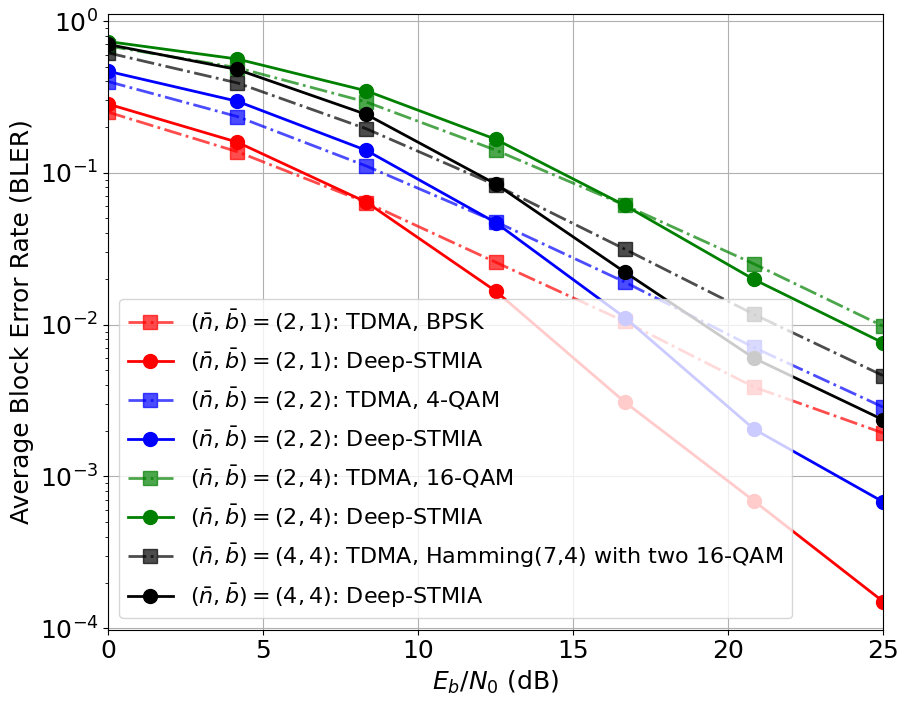

In [ ]:
Eb_N0_dB_eval_num = 7
Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

# (n,b)=(2,1)
mean_BLER1_base = np.array([0.25063, 0.13766, 0.06365, 0.02577, 0.01048, 0.00388, 0.00193])
label1_base = r'$(\bar{n},\bar{b})=(2,1)$: TDMA, BPSK'

mean_BLER1 = np.array([0.28348, 0.15900, 0.06396, 0.01663, 0.00309, 0.00069, 0.00015])
label1 = r'$(\bar{n},\bar{b})=(2,1)$: Deep-STMIA' #+ r', $L_\text{enc}=3, L_\text{dec}=1, b_{\text{c},1}=0$'

# (n,b)=(2,2)
mean_BLER2_base = np.array([0.39873, 0.23454, 0.11067, 0.04763, 0.01906, 0.00707, 0.00286])
label2_base = r'$(\bar{n},\bar{b})=(2,2)$: TDMA, 4-QAM'

mean_BLER2 = np.array([0.46578, 0.29573, 0.14026, 0.04699, 0.01113, 0.00205, 0.00068])
label2 = r'$(\bar{n},\bar{b})=(2,2)$: Deep-STMIA' #+ r', $L_\text{enc}=3, L_\text{dec}=1, b_{\text{c},1}=0$'

# (n,b)=(2,4)
mean_BLER3_base = np.array([0.68349, 0.49208, 0.29214, 0.14098, 0.06117, 0.02511, 0.00976])
label3_base = r'$(\bar{n},\bar{b})=(2,4)$: TDMA, 16-QAM'

mean_BLER3 = np.array([0.73157, 0.56112, 0.34620, 0.16624, 0.06103, 0.01983, 0.00758])
label3 = r'$(\bar{n},\bar{b})=(2,4)$: Deep-STMIA' #+ r', $L_\text{enc}=3, L_\text{dec}=1, b_{\text{c},1}=0$'

# (n,b)=(4,4)
mean_BLER4_base = np.array([0.61577, 0.39061, 0.19466, 0.08298, 0.0314,  0.01169, 0.00461])
label4_base = r'$(\bar{n},\bar{b})=(4,4)$: TDMA, Hamming(7,4) with two 16-QAM'

mean_BLER4 = np.array([0.69975, 0.47869, 0.24210, 0.08441, 0.02217, 0.00601, 0.00236])
label4 = r'$(\bar{n},\bar{b})=(4,4)$: Deep-STMIA' #+ r', $L_\text{enc}=3 , L_\text{dec}=1, b_{\text{c},1}=0$'


# --- BLER plot ---
fig_count = 0
plt.figure(fig_count+1,figsize=(10, 8))

BLER_plot1_base, = plt.plot(Eb_N0_dB_eval, mean_BLER1_base, 'r-.s', markersize=10, linewidth = 2, label = label1_base)
BLER_plot1_base.set_alpha(0.7)
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-o', markersize=10, linewidth = 2, label = label1)

BLER_plot2_base, = plt.plot(Eb_N0_dB_eval, mean_BLER2_base, 'b-.s', markersize=10, linewidth = 2, label = label2_base)
BLER_plot2_base.set_alpha(0.7)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', markersize=10, linewidth = 2, label = label2)

BLER_plot3_base, = plt.plot(Eb_N0_dB_eval, mean_BLER3_base, 'g-.s', markersize=10, linewidth = 2, label = label3_base)
BLER_plot3_base.set_alpha(0.7)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-o', markersize=10, linewidth = 2, label = label3)

BLER_plot4_base, = plt.plot(Eb_N0_dB_eval, mean_BLER4_base, 'k-.s', markersize=10, linewidth = 2, label = label4_base)
BLER_plot4_base.set_alpha(0.7)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-o', markersize=10, linewidth = 2, label = label4)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$ [1, Figure 7]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_No_IA.png')

# 8. Evaluation: Perfect Delayed CSIT and No Current CSIT

Since both MIA and SIA depend on current CSIT:
-  `MIA_mode = False`
-  `SIA_mode = False`

Since delayed CSIT up to one previous time interval exists:
-  `TIA_mode = True`
-  `T = 2`

## 8.1. Learnt Signaling Plot and BLER Evaluation

simulation 1 is running: (n,b) = (3, 1)
Epoch 1/30
97/97 - tot_loss: 0.030
Epoch 2/30
97/97 - tot_loss: 0.007
Epoch 3/30
97/97 - tot_loss: 0.004
Epoch 4/30
97/97 - tot_loss: 0.003
Epoch 5/30
97/97 - tot_loss: 0.002
Epoch 6/30
97/97 - tot_loss: 0.001
Epoch 7/30
97/97 - tot_loss: 0.001
Epoch 8/30
97/97 - tot_loss: 0.001
Epoch 9/30
97/97 - tot_loss: 0.001
Epoch 10/30
97/97 - tot_loss: 0.001
Epoch 11/30
97/97 - tot_loss: 0.001
Epoch 12/30
97/97 - tot_loss: 0.001
Epoch 13/30
97/97 - tot_loss: 0.000
Epoch 14/30
97/97 - tot_loss: 0.000
Epoch 15/30
97/97 - tot_loss: 0.000
Epoch 16/30
97/97 - tot_loss: 0.000
Epoch 17/30
97/97 - tot_loss: 0.000
Epoch 18/30
97/97 - tot_loss: 0.000
Epoch 19/30
97/97 - tot_loss: 0.000
Epoch 20/30
97/97 - tot_loss: 0.000
Epoch 21/30
97/97 - tot_loss: 0.000
Epoch 22/30
97/97 - tot_loss: 0.000
Epoch 23/30
97/97 - tot_loss: 0.000
Epoch 24/30
97/97 - tot_loss: 0.000
Epoch 25/30
97/97 - tot_loss: 0.000
Epoch 26/30
97/97 - tot_loss: 0.000
Epoch 27/30
97/97 - tot_loss: 0.0

/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['dense_12/kernel', 'dense_12/bias', 'dense_16/kernel', 'dense_16/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


97/97 - tot_loss: 1.888
Epoch 2/30
97/97 - tot_loss: 0.861
Epoch 3/30
97/97 - tot_loss: 0.350
Epoch 4/30
97/97 - tot_loss: 0.161
Epoch 5/30
97/97 - tot_loss: 0.096
Epoch 6/30
97/97 - tot_loss: 0.065
Epoch 7/30
97/97 - tot_loss: 0.049
Epoch 8/30
97/97 - tot_loss: 0.037
Epoch 9/30
97/97 - tot_loss: 0.032
Epoch 10/30
97/97 - tot_loss: 0.025
Epoch 11/30
97/97 - tot_loss: 0.023
Epoch 12/30
97/97 - tot_loss: 0.021
Epoch 13/30
97/97 - tot_loss: 0.020
Epoch 14/30
97/97 - tot_loss: 0.016
Epoch 15/30
97/97 - tot_loss: 0.016
Epoch 16/30
97/97 - tot_loss: 0.013
Epoch 17/30
97/97 - tot_loss: 0.010
Epoch 18/30
97/97 - tot_loss: 0.010
Epoch 19/30
97/97 - tot_loss: 0.010
Epoch 20/30
97/97 - tot_loss: 0.009
Epoch 21/30
97/97 - tot_loss: 0.009
Epoch 22/30
97/97 - tot_loss: 0.007
Epoch 23/30
97/97 - tot_loss: 0.008
Epoch 24/30
97/97 - tot_loss: 0.008
Epoch 25/30
97/97 - tot_loss: 0.008
Epoch 26/30
97/97 - tot_loss: 0.007
Epoch 27/30
97/97 - tot_loss: 0.007
Epoch 28/30
97/97 - tot_loss: 0.005
Epoch 29/30


/tmp/ipython-input-2998053302.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(fig_count,figsize=(6, 5))


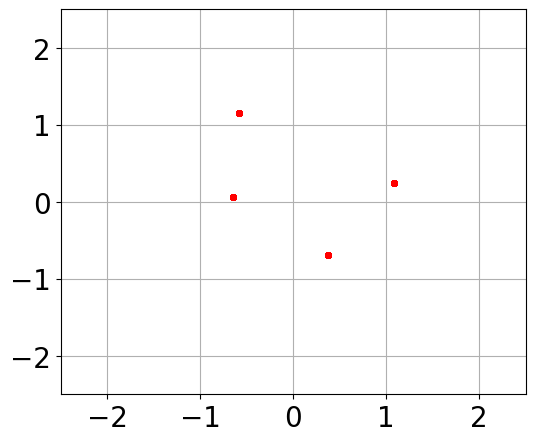

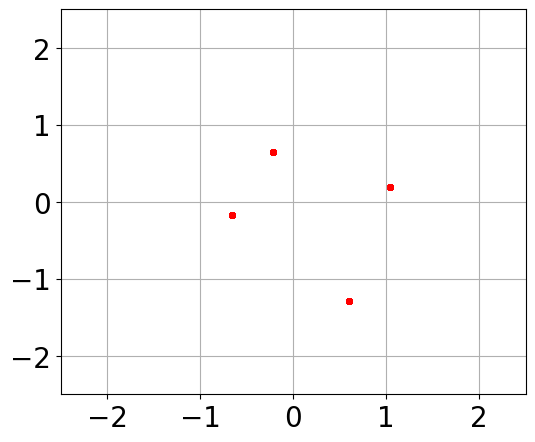

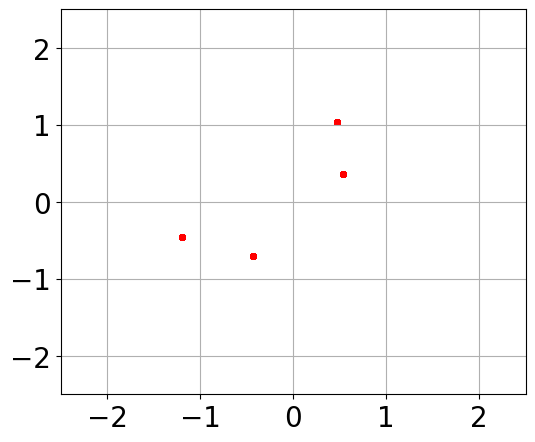

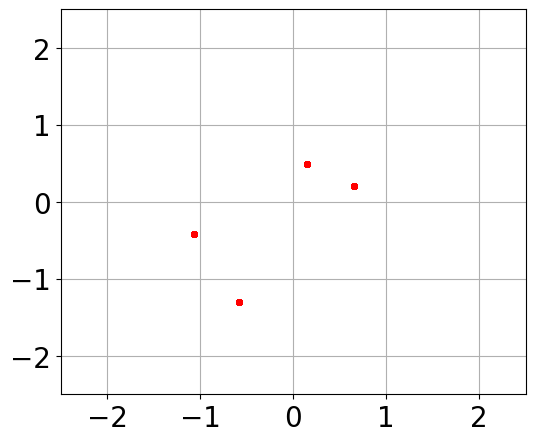

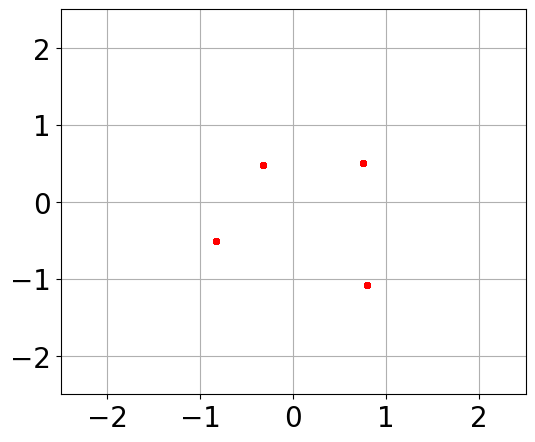

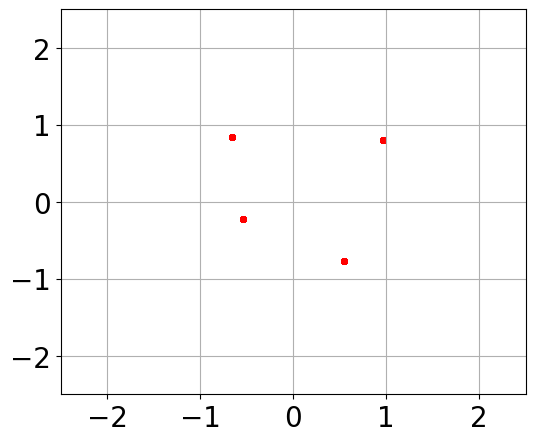

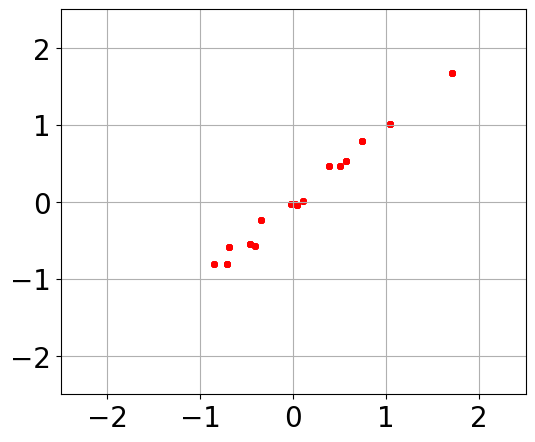

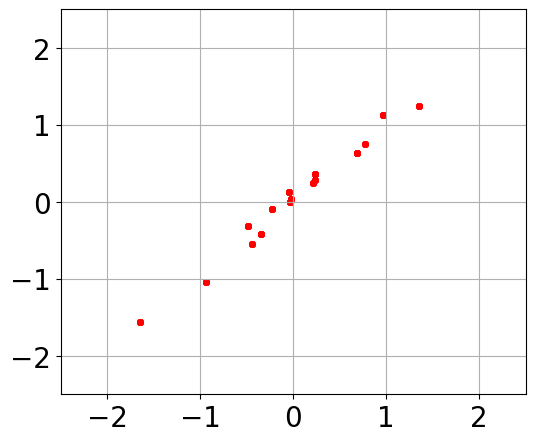

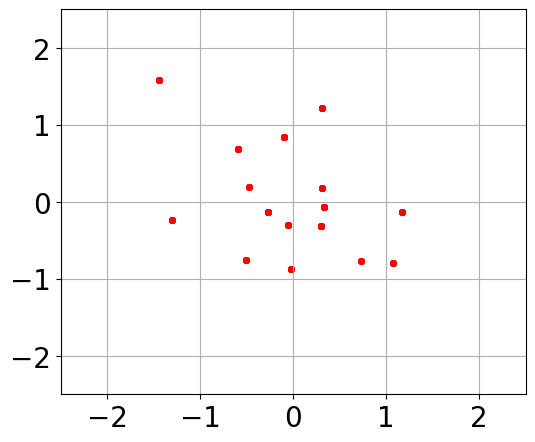

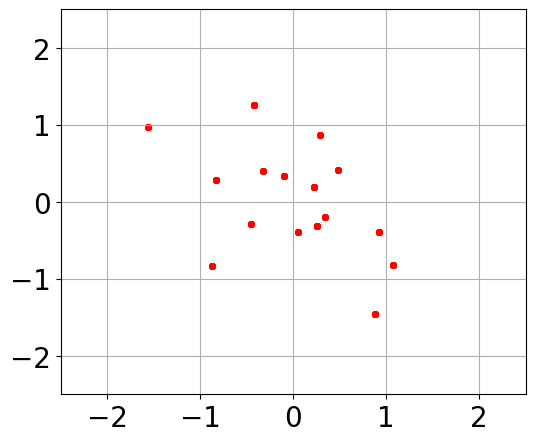

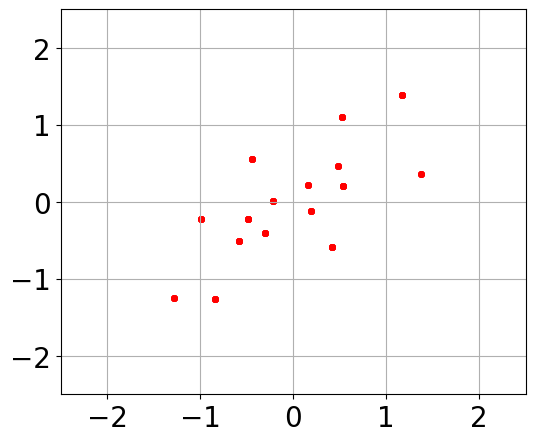

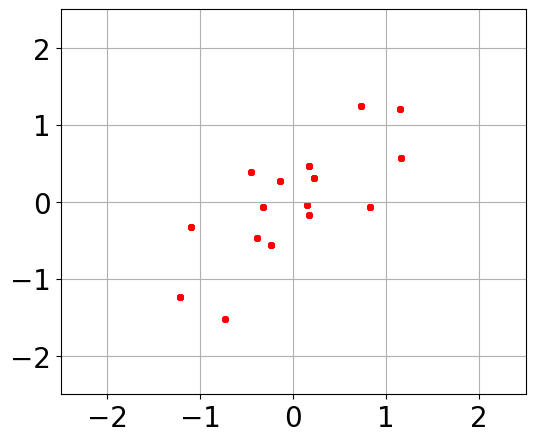

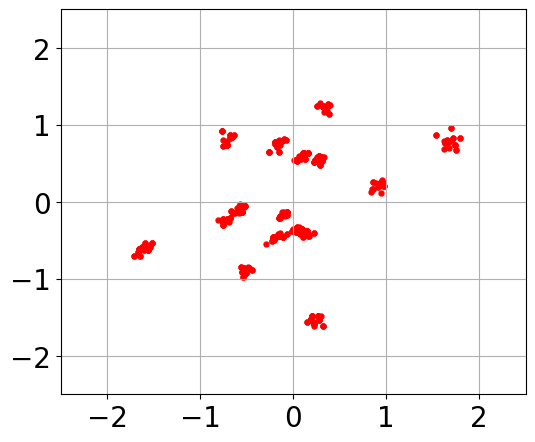

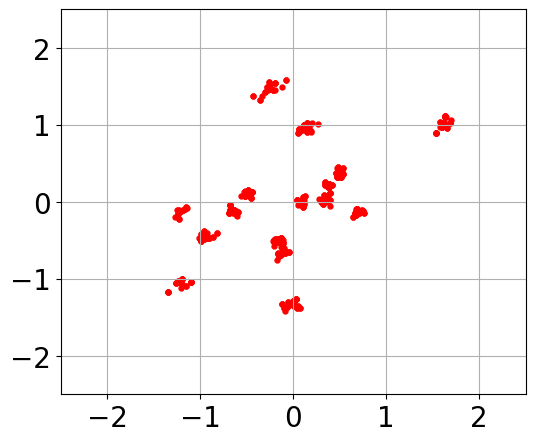

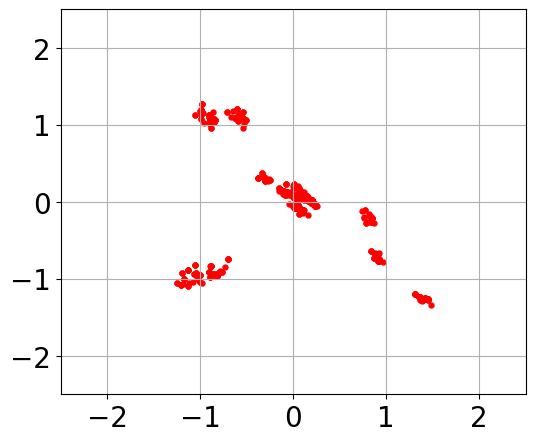

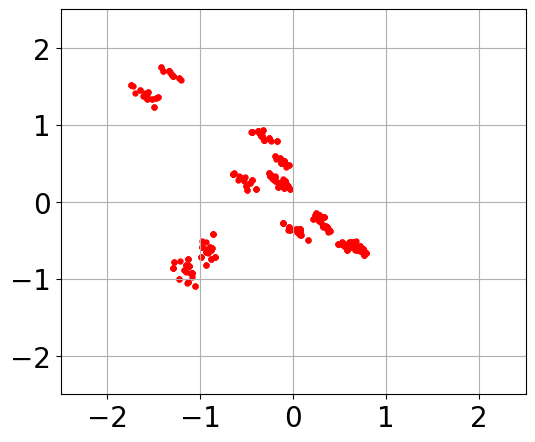

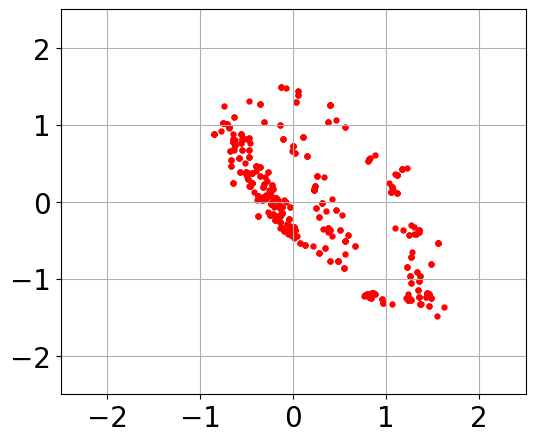

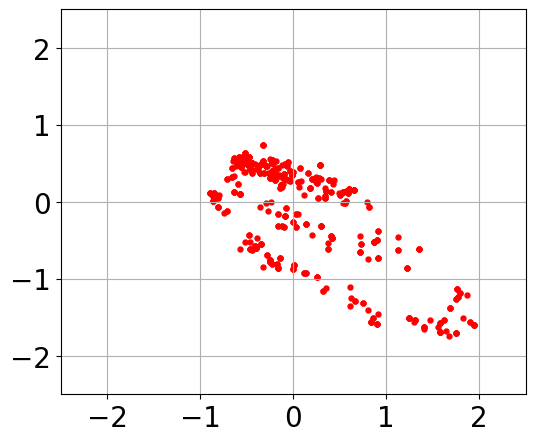

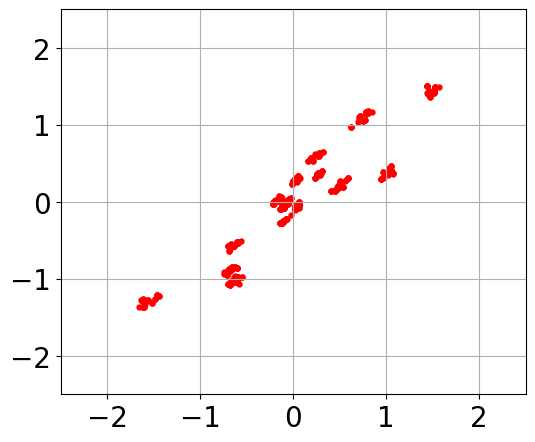

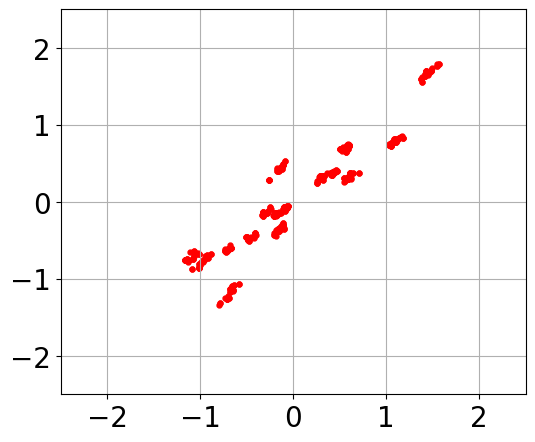

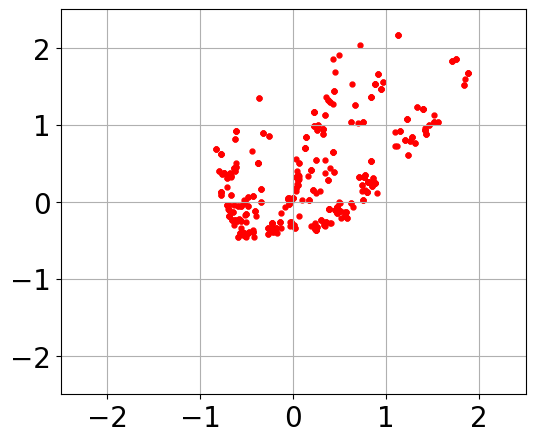

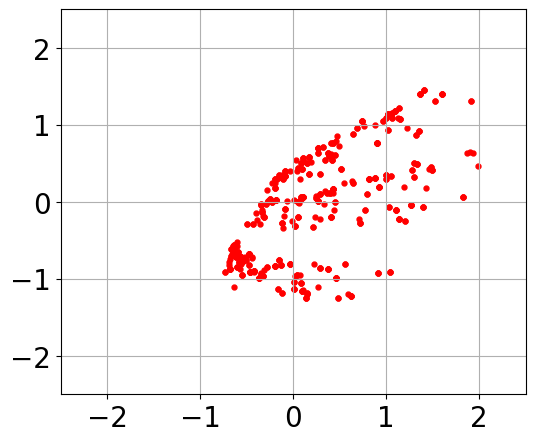

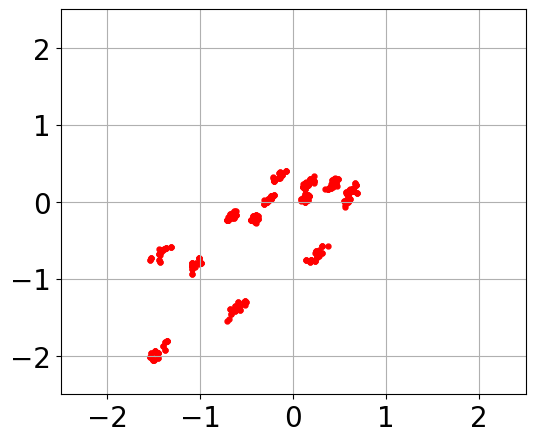

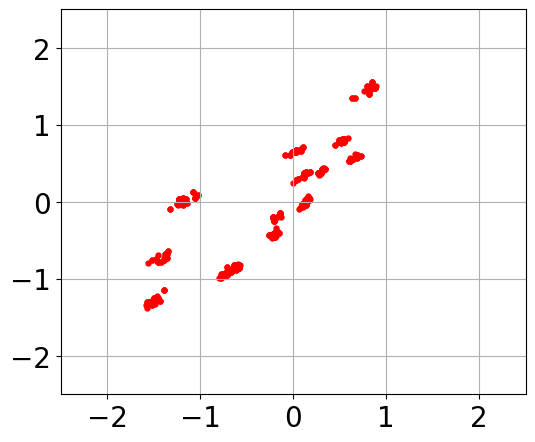

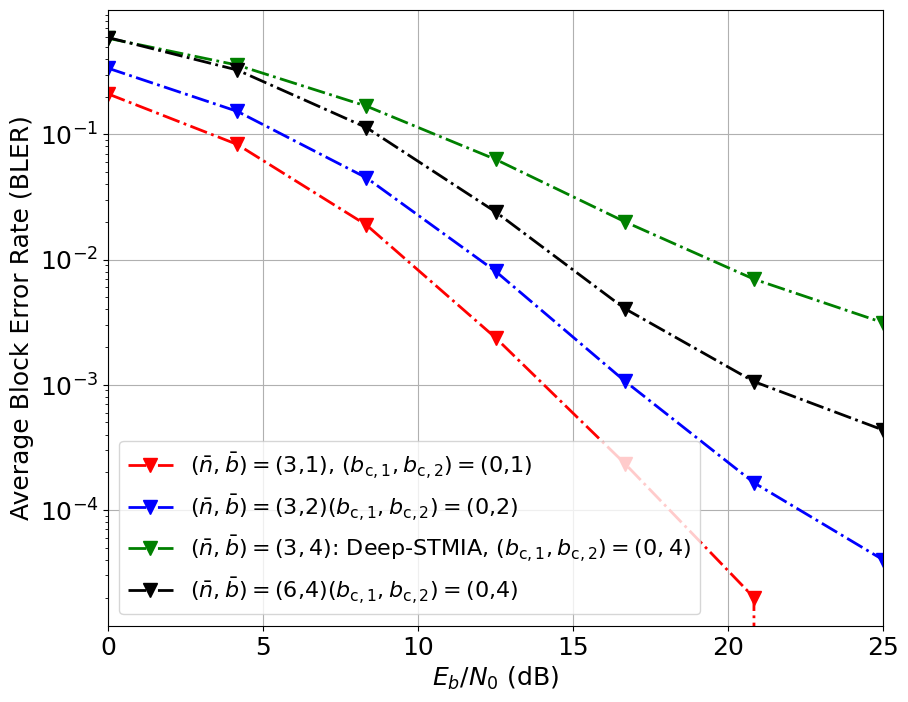

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 2 # Number of time intervals

training_Eb_N0_dB = 20

mu_user = np.ones(K)
mu_c = 0.5

training_gam = 0.9 # Training CSIR parameter
training_alph = 0 # Training current CSIT parameter
training_bet = 0.9 # Training delayed CSIT parameter

gam = 1
alph = 0
bet = 1

L_enc = 3
N_enc = 64
L_dec = 1
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

SIA_mode = False
MIA_mode = False
TIA_mode = True

fig_count = 0
for (simulation_num, n, b) in [(1, 1, 1), (2, 1, 2), (4, 2, 4)]:
  # [(1, 1, 1), (2, 1, 2), (3, 1, 4), (4, 2, 4)]:

  print(f'simulation {simulation_num} is running: (n,b) = ({3*n}, {b})')

  b_c = b

  n_t = np.array([2*n,n]) # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_t_k[1,:] = np.zeros((K,)) # No user message in the second time interval
  b_c_t = np.array([0,b_c]) # Number of bits in the common message of each time interval

  # setting seeds for reproducibility
  tf.random.set_seed(42)
  tf.keras.utils.set_random_seed(42)

  # Training====================================================================
  tf.keras.backend.clear_session() # Ensures a clean slate for each run
  Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                progress_print = True)
  # Plotting Symbols ===========================================================
  plot_samples = 500

  # --- Noise power ---
  Eb_N0_dB_plot = 20
  Eb_N0 = 10**(Eb_N0_dB_plot/10)
  snr = np.empty((T,))
  noise_std = np.empty((T,))
  for t in range(T):
    snr[t] = Eb_N0*b/(n_t[t])
    noise_std[t] = sqrt(0.5/snr[t])
  # Power constraint in each channel use is 1.0

  # --- Channel ---
  channel_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
      channel_list_sample.append(channel_t_n)

  # --- CSIR and CSIT ---
  # CSIR parameters:
  csir_sigm = np.empty((T,))
  for t in range(T):
    gam_P = gam*snr[t]/(snr[t]+1-gam)
    csir_sigm[t] = snr[t]**(-gam_P)

  if SIA_mode or MIA_mode:
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

  if TIA_mode:
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

  csir_list_sample = []
  current_CSIT_list_sample = []
  delayed_CSIT_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = channel_list_sample[np.sum(n_t[:t]) + n_index]

      # CSIR
      csir_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
      csir_list_sample.append(channel_t_n - csir_t_n)

      # Current CSIT
      if SIA_mode or MIA_mode:
        current_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
        current_CSIT_list_sample.append(channel_t_n - current_ch_error_t_n)

      # Delayed CSIT
      if TIA_mode and t < T-1:
        delayed_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
        delayed_CSIT_list_sample.append(channel_t_n - delayed_ch_error_t_n)

  # --- Messages ---
  messages_one_hot_list_sample = []
  for t in range(T):
      for k in range(K):
          messages_t_k = tf.random.uniform(shape=(plot_samples,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
          messages_one_hot_list_sample.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

  # --- Tx ---
  tx_output = Tx(inputs = messages_one_hot_list_sample + current_CSIT_list_sample + delayed_CSIT_list_sample)
  if MIA_mode:
    enc_output = tx_output[:T]
  else:
    enc_output = tx_output

  # --- Symbols Plot ---
  for t in range(T): # time interval
    for n_index in range(n_t[t]): # Channel use
      for i in range(M): # Antenna
        fig_count = fig_count + 1
        plt.figure(fig_count,figsize=(6, 5))
        # (i)th neuron and (i+M)th are respectively real and imaginary part of the (i)th element of the codeword:
        if MIA_mode or T > 1:
          plt.scatter(enc_output[t][:, n_index*2*M+i], enc_output[t][:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        else:
          plt.scatter(enc_output[:, n_index*2*M+i], enc_output[:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        plt.xlim([-2.5,2.5])
        plt.ylim([-2.5,2.5])
        #plt.title(r'$t=$' + f'{t+1}, ' + r'$n=$'+ f'{n_index+1}, ' + 'Antenna {i+1}')
        plt.tick_params(axis='both', labelsize=20)
        plt.grid()
        plt.savefig(f"Symbols_(n_b)_({3*n}_{b})_time_{t+1}_channel_use_{n_index+1}_antenna_{i+1}_Simulation_3.png")

  # BLER Evaluation=============================================================
  n_samples_eval = 100_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)
  for i in range(Eb_N0_dB_eval_num):
    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])
    # Power constraint in each channel use is 1.0

    # Messages ===
    messages_one_hot_list = []
    for t in range(T):
      for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    if SIA_mode or MIA_mode:
      # Current CSIT parameters:
      sigm = np.empty((T,))
      for t in range(T):
        alph_P = alph*snr[t]/(snr[t]+1-alph)
        sigm[t] = snr[t]**(-alph_P)

    if TIA_mode:
      # Delayed CSIT parameters:
      sigma_FB = np.empty((T,))
      for t in range(T):
        bet_P = bet*snr[t]/(snr[t]+1-bet)
        sigma_FB[t] = snr[t]**(-bet_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
        csir_list.append(channel_t_n - csir_t_n)

        # Current CSIT
        if SIA_mode or MIA_mode:
          current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
          current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # Delayed CSIT
        if TIA_mode and t < T-1:
          delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

    # --- Tx ---
    tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

    # --- Channel ---
    if MIA_mode or TIA_mode:
      enc_output = tx_output[:T]
    else:
      enc_output = tx_output

    if T > 1:
      ch_output = ch_model(enc_output + channel_list)
    else:
      ch_output = ch_model([enc_output] + channel_list)

    # --- AWGN ---
    if T > 1:
      received_signal = []
      for t in range(T):
        received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
    else:
      received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

    # --- Decoder ---
    if T > 1:
      decoder_output = Decoder(received_signal + csir_list)
    else:
      decoder_output = Decoder([received_signal] + csir_list)

    if MIA_mode or TIA_mode:
      messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
    else:
      messages_prediction_prob = decoder_output # predicted user messages as probability vectors

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_one_hot_list[t * K + k].numpy().argmax(axis = -1) !=
                                      messages_prediction_prob[t * K + k].numpy().argmax(axis = -1)) / n_samples_eval
        if b_t_k[t,k] != 0:
          mean_BLER_count += b_t_k[t,k]
          mean_BLER[i] = mean_BLER[i] + BLER[t,k]*b_t_k[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/mean_BLER_count

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'$(\bar{n},\bar{b})=$' + f'({3*n},{b}), ' + r'$(b_{\text{c},1},b_{\text{c},2})=$' + f'({b_c_t[0]},{b_c_t[1]})'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$(\bar{n},\bar{b})=$' + f'({3*n},{b})' + r'$(b_{\text{c},1},b_{\text{c},2})=$' + f'({b_c_t[0]},{b_c_t[1]})'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$(\bar{n},\bar{b})=$' + f'({3*n},{b})' + r'$(b_{\text{c},1},b_{\text{c},2})=$' + f'({b_c_t[0]},{b_c_t[1]})'
  elif simulation_num == 4:
    mean_BLER4 = np.array(mean_BLER)
    label4 = r'$(\bar{n},\bar{b})=$' + f'({3*n},{b})' + r'$(b_{\text{c},1},b_{\text{c},2})=$' + f'({b_c_t[0]},{b_c_t[1]})'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-.v', markersize=10, linewidth = 2, label = label2)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-.v', markersize=10, linewidth = 2, label = label3)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-.v', markersize=10, linewidth = 2, label = label4)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18) # Tick label font size
#plt.title('BLER vs. ' + r'$E_b/N_0$ under Perfect Delayed CSIT and No Current CSIT', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_TIA_only.png')

## 8.2. BLER vs. $\frac{E_b}{N_0}$: [1, Figure 9]

**Note:** The baselines BLER values (`mean_BLER1_base`, `mean_BLER2_base`, `mean_BLER3_base`, `mean_BLER4_base`) are obtained in **Section ... of `Baselines.ipynb`**, and the BLER values of Deep-STMIA (`mean_BLER1`, `mean_BLER2`, `mean_BLER3`, `mean_BLER4`) is obtained in **Section 8.1 above** with the following setting:
-  `M=K=2`
-  `T = 2`
-  `Seed: `
-  `training_Eb_N0_dB = 20 dB`
-  `training_gam = 0.9`
-  `training_alph = 0`
-  `training_bet = 0.9`
-  `L_enc = 3`
-  `L_dec = 1`
-  `N_enc = 64`
-  `N_dec = 64`
-  `mu_c = 0.5`

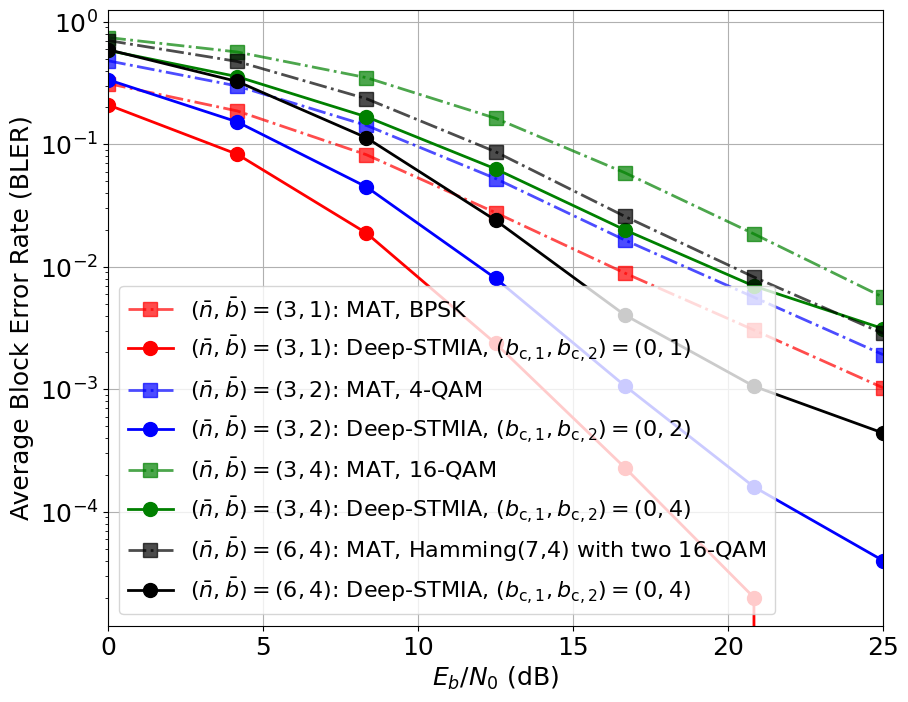

In [ ]:
Eb_N0_dB_eval_num = 7
Eb_N0_dB_eval = np.linspace(0,25,Eb_N0_dB_eval_num)

# (n,b)=(3,1)
mean_BLER1_base = np.array([0.31342, 0.18721, 0.08221, 0.02767, 0.00890, 0.00305, 0.00103])
label1_base = r'$(\bar{n},\bar{b})=(3,1)$: MAT, BPSK'

mean_BLER1 = np.array([0.20993, 0.08296, 0.01886, 0.00237, 0.00023, 0.00002, 0.00000])
label1 = r'$(\bar{n},\bar{b})=(3,1)$: Deep-STMIA, $(b_{\text{c},1},b_{\text{c},2}) = (0,1)$'

# (n,b)=(3,2)
mean_BLER2_base = np.array([0.48073, 0.29914, 0.14272, 0.05257, 0.01655, 0.00565, 0.00192])
label2_base = r'$(\bar{n},\bar{b})=(3,2)$: MAT, 4-QAM'

mean_BLER2 = np.array([0.33686, 0.15246, 0.04491, 0.00805, 0.00107, 0.00016, 0.00004])
label2 = r'$(\bar{n},\bar{b})=(3,2)$: Deep-STMIA, $(b_{\text{c},1},b_{\text{c},2}) = (0,2)$'

#(n,b)=(3,4)
mean_BLER3_base = np.array([0.74425, 0.56716, 0.35006, 0.16317, 0.05869, 0.01857, 0.00565])
label3_base = r'$(\bar{n},\bar{b})=(3,4)$: MAT, 16-QAM'

mean_BLER3 = np.array([0.58417, 0.35675, 0.16778, 0.06299, 0.02004, 0.00697, 0.00313])
label3 = r'$(\bar{n},\bar{b})=(3,4)$: Deep-STMIA, $(b_{\text{c},1},b_{\text{c},2}) = (0,4)$'

#(n,b)=(6,4)
mean_BLER4_base = np.array([0.70341, 0.47465, 0.23556, 0.08687, 0.02583, 0.00825, 0.00286])
label4_base = r'$(\bar{n},\bar{b})=(6,4)$: MAT, Hamming(7,4) with two 16-QAM'

mean_BLER4 = np.array([0.59221, 0.32583, 0.11308, 0.02399, 0.00405, 0.00106, 0.00044])
label4 = r'$(\bar{n},\bar{b})=(6,4)$: Deep-STMIA, $(b_{\text{c},1},b_{\text{c},2}) = (0,4)$'

# --- BLER plot ---
fig_count = 0
plt.figure(fig_count+1,figsize=(10, 8))
BLER_plot1_base, = plt.plot(Eb_N0_dB_eval, mean_BLER1_base, 'r-.s', markersize=10, linewidth = 2, label = label1_base)
BLER_plot1_base.set_alpha(0.7)
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-o', markersize=10, linewidth = 2, label = label1)

BLER_plot2_base, = plt.plot(Eb_N0_dB_eval, mean_BLER2_base, 'b-.s', markersize=10, linewidth = 2, label = label2_base)
BLER_plot2_base.set_alpha(0.7)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', markersize=10, linewidth = 2, label = label2)

BLER_plot3_base, = plt.plot(Eb_N0_dB_eval, mean_BLER3_base, 'g-.s', markersize=10, linewidth = 2, label = label3_base)
BLER_plot3_base.set_alpha(0.7)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'g-o', markersize=10, linewidth = 2, label = label3)

BLER_plot4_base, = plt.plot(Eb_N0_dB_eval, mean_BLER4_base, 'k-.s', markersize=10, linewidth = 2, label = label4_base)
BLER_plot4_base.set_alpha(0.7)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'k-o', markersize=10, linewidth = 2, label = label4)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$ [1, Figure 9]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_TIA_only.png')

# 9. Evaluation: Imperfect Current CSIT and No Delayed CSIT

Since there is no delayed CSIT:
-  `TIA_mode = False`
-  `T = 1`

Since current CSIT is imperfect message-domain regularization is required. Also, current CSIT makes space-domain interference alignment possible:
-  `MIA_mode = True`
-  `SIA_mode = True`

## 9.1. Learnt Signaling Plot and BLER Evaluation

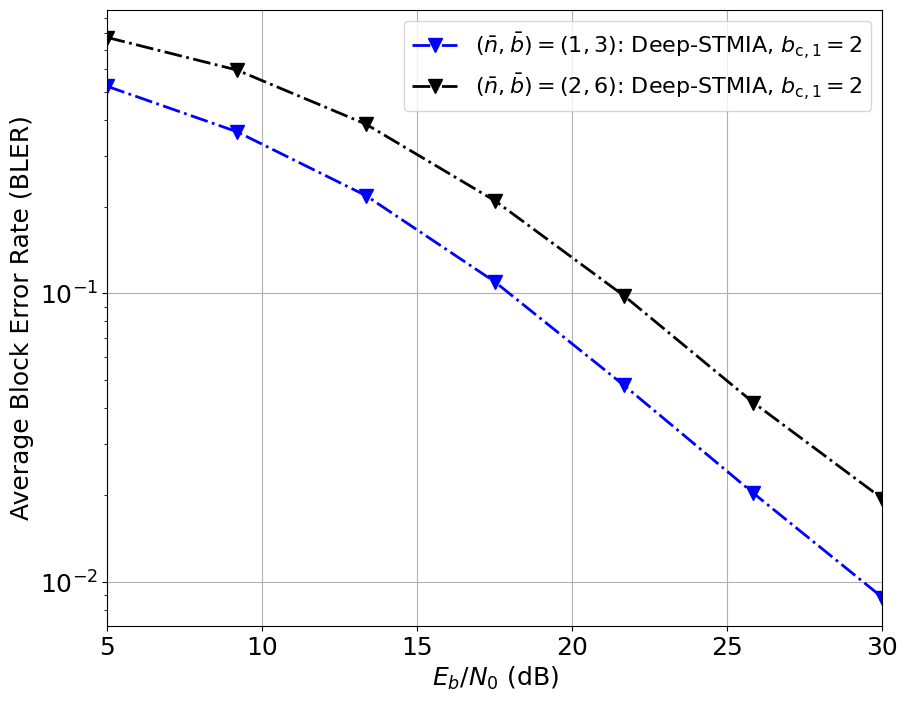

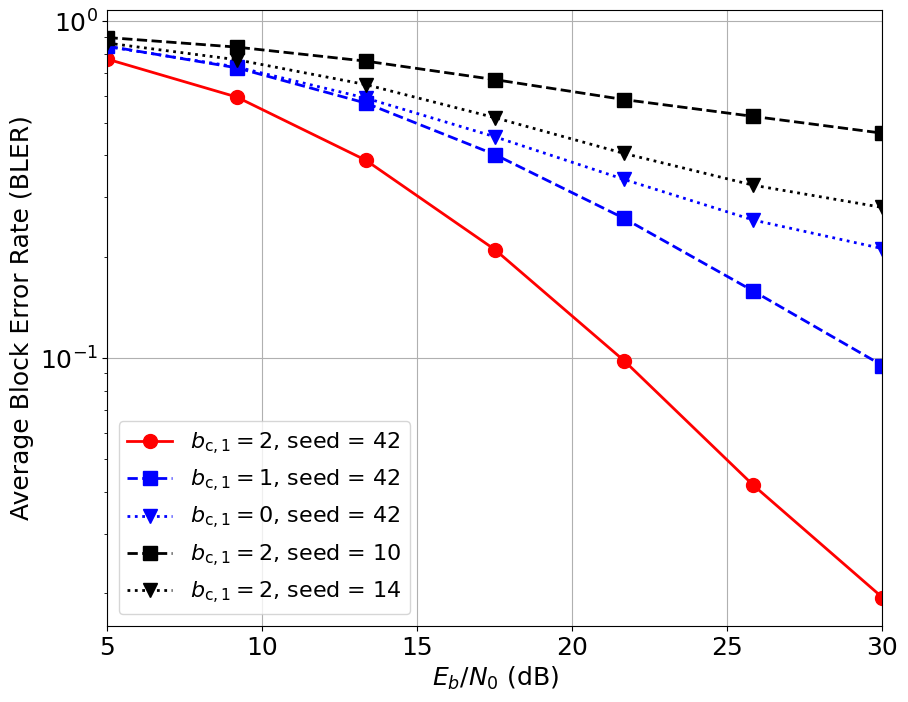

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

training_Eb_N0_dB = 30

mu_user = np.ones(K)
mu_c = 0.5

training_gam = 0.8 # Training CSIR parameter
training_alph = 0.3 # Training current CSIT parameter
training_bet = 0 # Training delayed CSIT parameter

gam = 1
alph = 0.5
bet = 0

L_enc = 3
N_enc = 64
L_dec = 2
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

SIA_mode = True
MIA_mode = True
TIA_mode = False

fig_count = 0
for (simulation_num, n, b, b_c, seed_value) in [(2, 2, 6, 2, 42)]:
  #[(1, 1, 3, 2, 42), (2, 2, 6, 2, 42), (3, 2, 6, 1, 42), (4, 2, 6, 0, 42), (5, 2, 6, 2, 10), (6, 2, 6, 2, 14)]:

  print(f'simulation {simulation_num} is running: (n,b,b_c) = ({n}, {b}, {b_c})')

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c_t = np.ones((T,),dtype=np.int32)*b_c # Number of bits in the common message of each time interval

  # setting seeds for reproducibility
  tf.random.set_seed(seed_value)
  tf.keras.utils.set_random_seed(seed_value)

  # Training====================================================================
  tf.keras.backend.clear_session() # Ensures a clean slate for each run
  Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                progress_print = True)
  # Symbol Plot=================================================================
  plot_samples = 10_000 #500

  # --- Noise power ---
  Eb_N0_dB_plot = 20
  Eb_N0 = 10**(Eb_N0_dB_plot/10)
  snr = np.empty((T,))
  noise_std = np.empty((T,))
  for t in range(T):
    snr[t] = Eb_N0*b/(n_t[t])
    noise_std[t] = sqrt(0.5/snr[t])
  # Power constraint in each channel use is 1.0

  # --- Channel ---
  channel_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
      channel_list_sample.append(channel_t_n)

  # --- CSIR and CSIT ---
  # CSIR parameters:
  csir_sigm = np.empty((T,))
  for t in range(T):
    gam_P = gam*snr[t]/(snr[t]+1-gam)
    csir_sigm[t] = snr[t]**(-gam_P)

  if SIA_mode or MIA_mode:
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

  if TIA_mode:
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

  csir_list_sample = []
  current_CSIT_list_sample = []
  delayed_CSIT_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = channel_list_sample[np.sum(n_t[:t]) + n_index]

      # CSIR
      csir_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
      csir_list_sample.append(channel_t_n - csir_t_n)

      # Current CSIT
      if SIA_mode or MIA_mode:
        current_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
        current_CSIT_list_sample.append(channel_t_n - current_ch_error_t_n)

      # Delayed CSIT
      if TIA_mode and t < T-1:
        delayed_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
        delayed_CSIT_list_sample.append(channel_t_n - delayed_ch_error_t_n)

  # --- Messages ---
  messages_one_hot_list_sample = []
  for t in range(T):
      for k in range(K):
          messages_t_k = tf.random.uniform(shape=(plot_samples,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
          messages_one_hot_list_sample.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

  # --- Tx ---
  tx_output = Tx(inputs = messages_one_hot_list_sample + current_CSIT_list_sample + delayed_CSIT_list_sample)
  if MIA_mode:
    enc_output = tx_output[:T]
  else:
    enc_output = tx_output

  # --- Symbols Plot ---
  for t in range(T): # time interval
    for n_index in range(n_t[t]): # Channel use
      for i in range(M): # Antenna
        fig_count = fig_count + 1
        plt.figure(fig_count,figsize=(6, 5))
        # (i)th neuron and (i+M)th are respectively real and imaginary part of the (i)th element of the codeword:
        if MIA_mode or T > 1:
          plt.scatter(enc_output[t][:, n_index*2*M+i], enc_output[t][:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        else:
          plt.scatter(enc_output[:, n_index*2*M+i], enc_output[:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        plt.xlim([-2.5,2.5])
        plt.ylim([-2.5,2.5])
        #plt.title(r'$t=$' + f'{t+1}, ' + r'$n=$'+ f'{n_index+1}, ' + 'Antenna {i+1}')
        plt.tick_params(axis='both', labelsize=20)
        plt.grid()
        plt.savefig(f"Symbols_(n_b_bc)_({n}_{b}_{b_c})_time_{t+1}_channel_use_{n_index+1}_antenna_{i+1}_Simulation_4.png")
  # BLER Evaluation=============================================================
  n_samples_eval = 100_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)
  for i in range(Eb_N0_dB_eval_num):
    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])
    # Power constraint in each channel use is 1.0

    # Messages ===
    messages_one_hot_list = []
    for t in range(T):
      for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    if SIA_mode or MIA_mode:
      # Current CSIT parameters:
      sigm = np.empty((T,))
      for t in range(T):
        alph_P = alph*snr[t]/(snr[t]+1-alph)
        sigm[t] = snr[t]**(-alph_P)

    if TIA_mode:
      # Delayed CSIT parameters:
      sigma_FB = np.empty((T,))
      for t in range(T):
        bet_P = bet*snr[t]/(snr[t]+1-bet)
        sigma_FB[t] = snr[t]**(-bet_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
        csir_list.append(channel_t_n - csir_t_n)

        # Current CSIT
        if SIA_mode or MIA_mode:
          current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
          current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # Delayed CSIT
        if TIA_mode and t < T-1:
          delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

    # --- Tx ---
    tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

    # --- Channel ---
    if MIA_mode:
      enc_output = tx_output[:T]
    else:
      enc_output = tx_output

    if T > 1:
      ch_output = ch_model(enc_output + channel_list)
    else:
      ch_output = ch_model([enc_output] + channel_list)

    # --- AWGN ---
    if T > 1:
      received_signal = []
      for t in range(T):
        received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
    else:
      received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

    # --- Decoder ---
    if T > 1:
      decoder_output = Decoder(received_signal + csir_list)
    else:
      decoder_output = Decoder([received_signal] + csir_list)

    if MIA_mode or TIA_mode:
      messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
    else:
      messages_prediction_prob = decoder_output # predicted user messages as probability vectors

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_one_hot_list[t * K + k].numpy().argmax(axis = -1) !=
                                      messages_prediction_prob[t * K + k].numpy().argmax(axis = -1)) / n_samples_eval
        if b_t_k[t,k] != 0:
          mean_BLER_count += b_t_k[t,k]
          mean_BLER[i] = mean_BLER[i] + BLER[t,k]*b_t_k[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/mean_BLER_count

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}'
    label2_2 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}, seed = {seed_value}'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}, seed = {seed_value}'
  elif simulation_num == 4:
    mean_BLER4 = np.array(mean_BLER)
    label4 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}, seed = {seed_value}'
  elif simulation_num == 5:
    mean_BLER5 = np.array(mean_BLER)
    label5 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}, seed = {seed_value}'
  elif simulation_num == 6:
    mean_BLER6 = np.array(mean_BLER)
    label6 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}, seed = {seed_value}'

# --- BLER plot ---
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'b-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'k-.v', markersize=10, linewidth = 2, label = label2)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$ under Imperfect Current CSIT and No Delayed CSIT', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_SIA_MIA_alpha_{alph}.png')

# --- BLER plot: sensitivity on seed and common bits ---
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot2_2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'r-o', markersize=10, linewidth = 2, label = label2_2)

BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'b--s', markersize=10, linewidth = 2, label = label3)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'b:v', markersize=10, linewidth = 2, label = label4)

BLER_plot5, = plt.plot(Eb_N0_dB_eval, mean_BLER5, 'k--s', markersize=10, linewidth = 2, label = label5)
BLER_plot6, = plt.plot(Eb_N0_dB_eval, mean_BLER6, 'k:v', markersize=10, linewidth = 2, label = label6)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$: Effect of Common Bits and Seed Value', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_common_bits_seed.png')

## 9.2. BLER vs. $\frac{E_b}{N_0}$: [1, Figure 11] and [1, Figure 12]

**Note:** The baselines BLER values (`mean_BLER1_base` and `mean_BLER2_base`) are obtained in **Section ... of `Baselines.ipynb`**, and the BLER values of Deep-STMIA (`mean_BLER1`, `mean_BLER2`) is obtained in **Section 9.1 above** with the following setting:
-  `M=K=2`
-  `T = 1`
-  `Seed: 42`
-  `training_Eb_N0_dB = 30 dB`
-  `training_gam = 0.8`
-  `training_alph = 0.3`
-  `training_bet = 0`
-  `L_enc = 3`
-  `L_dec = 2`
-  `N_enc = 64`
-  `N_dec = 64`
-  `mu_c = 0.5`

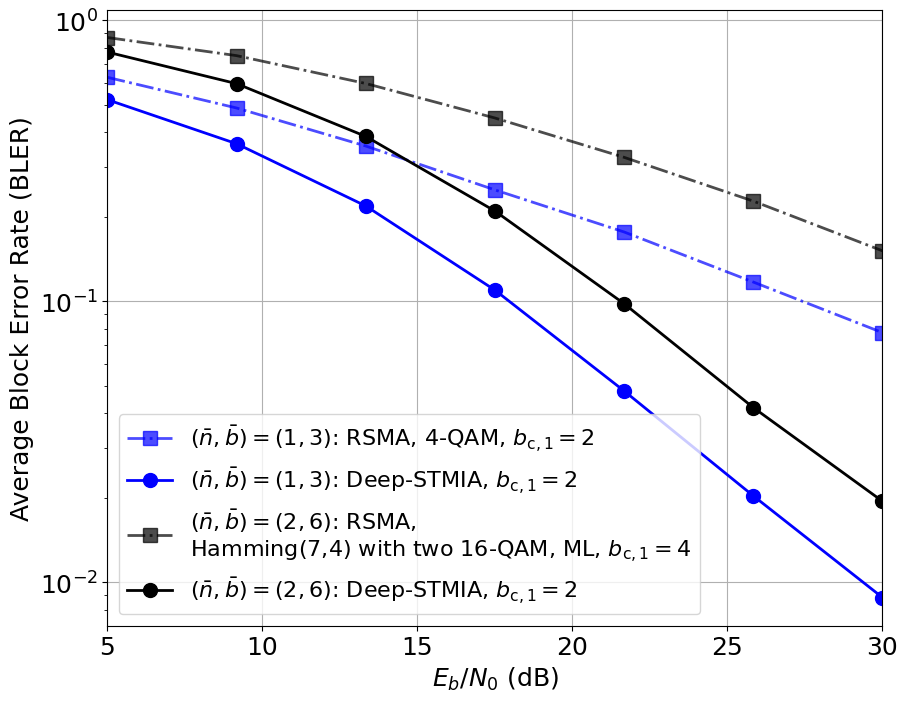

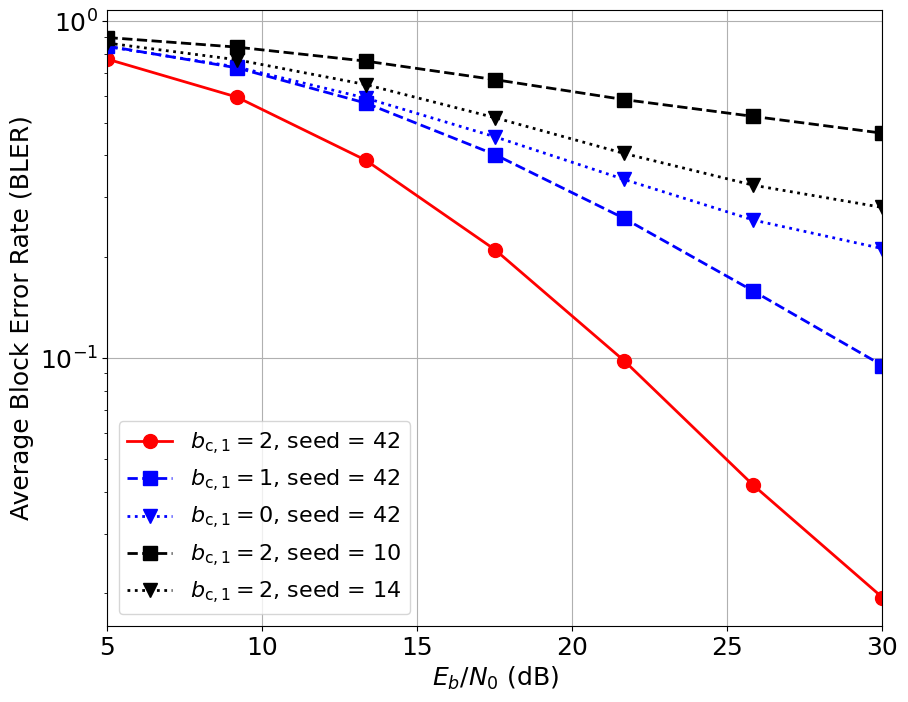

In [ ]:
alph = 0.5
Eb_N0_dB_eval_num = 7
Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

#(n,b) = (1,3)
mean_BLER1_base = np.array([0.62701, 0.4876,  0.35705, 0.24921, 0.17654, 0.11713, 0.07738])
label1_base = r'$(\bar{n},\bar{b})=(1,3)$: RSMA, 4-QAM, $b_{\text{c},1} = 2$'

mean_BLER1 = np.array([0.52190, 0.36378, 0.21844, 0.10958, 0.04797, 0.02031, 0.00883])
label1 =  r'$(\bar{n},\bar{b})=(1,3)$: Deep-STMIA, $b_{\text{c},1} = 2$'

#(n,b) = (2,6)
mean_BLER2_base = np.array([0.86882, 0.74887, 0.59608, 0.44923, 0.32542, 0.22734, 0.15128])
label2_base = r'$(\bar{n},\bar{b})=(2,6)$: RSMA,' + '\n' + r'Hamming(7,4) with two 16-QAM, ML, $b_{\text{c},1} = 4$'

mean_BLER2 = np.array([0.77096, 0.59523, 0.38629, 0.20954, 0.09806, 0.04187, 0.01943])
label2 = r'$(\bar{n},\bar{b})=(2,6)$: Deep-STMIA, $b_{\text{c},1} = 2$'
label2_2 = r'$b_{\text{c},1} = 2$, seed = 42'

mean_BLER3 = np.array([0.84282, 0.72676, 0.57097, 0.40146, 0.25960, 0.15792, 0.09491])
label3 = r'$b_{\text{c},1} = 1$, seed = 42'

mean_BLER4 = np.array([0.83981, 0.73107, 0.59095, 0.45347, 0.33880, 0.25664, 0.21105])
label4 = r'$b_{\text{c},1} = 0$, seed = 42'

mean_BLER5 = np.array([0.89396, 0.83738, 0.76073, 0.67031, 0.58483, 0.52133, 0.46475])
label5 = r'$b_{\text{c},1} = 2$, seed = 10'

mean_BLER6 = np.array([0.86055, 0.76820, 0.64799, 0.51671, 0.40464, 0.32565, 0.27972])
label6 = r'$b_{\text{c},1} = 2$, seed = 14'

# --- BLER plot ---
fig_count = 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot1_base, = plt.plot(Eb_N0_dB_eval, mean_BLER1_base, 'b-.s', markersize=10, linewidth = 2, label = label1_base)
BLER_plot1_base.set_alpha(0.7)
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'b-o', markersize=10, linewidth = 2, label = label1)

BLER_plot2_base, = plt.plot(Eb_N0_dB_eval, mean_BLER2_base, 'k-.s', markersize=10, linewidth = 2, label = label2_base)
BLER_plot2_base.set_alpha(0.7)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'k-o', markersize=10, linewidth = 2, label = label2)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$: [1, Figure 11]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_SIA_MIA_alpha_{alph}.png')


# --- BLER plot: sensitivity on seed and common bits ---
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot2_2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'r-o', markersize=10, linewidth = 2, label = label2_2)

BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'b--s', markersize=10, linewidth = 2, label = label3)
BLER_plot4, = plt.plot(Eb_N0_dB_eval, mean_BLER4, 'b:v', markersize=10, linewidth = 2, label = label4)

BLER_plot5, = plt.plot(Eb_N0_dB_eval, mean_BLER5, 'k--s', markersize=10, linewidth = 2, label = label5)
BLER_plot6, = plt.plot(Eb_N0_dB_eval, mean_BLER6, 'k:v', markersize=10, linewidth = 2, label = label6)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$: [1, Figure 12]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_common_bits_seed.png')

## 9.4. CSIT Quality During Training and Evaluation [1, Figure 14]

simulation 1 is running: ($\alpha_\text{training}$, $\alpha$) = (0.3, 0.5)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['ch_input_encoded_signals_0', 'ch_input_channel_matrix_0_0', 'ch_input_channel_matrix_0_1']
Received: inputs=[['Tensor(shape=(1024, 8))'], 'Tensor(shape=(1024, 2, 4))', 'Tensor(shape=(1024, 2, 4))']
  warnings.warn(msg)


97/97 - tot_loss: 3.443
Epoch 2/30
97/97 - tot_loss: 2.077
Epoch 3/30
97/97 - tot_loss: 1.230
Epoch 4/30
97/97 - tot_loss: 0.675
Epoch 5/30
97/97 - tot_loss: 0.433
Epoch 6/30
97/97 - tot_loss: 0.373
Epoch 7/30
97/97 - tot_loss: 0.263
Epoch 8/30
97/97 - tot_loss: 0.237
Epoch 9/30
97/97 - tot_loss: 0.220
Epoch 10/30
97/97 - tot_loss: 0.191
Epoch 11/30
97/97 - tot_loss: 0.186
Epoch 12/30
97/97 - tot_loss: 0.185
Epoch 13/30
97/97 - tot_loss: 0.189
Epoch 14/30
97/97 - tot_loss: 0.179
Epoch 15/30
97/97 - tot_loss: 0.173
Epoch 16/30
97/97 - tot_loss: 0.137
Epoch 17/30
97/97 - tot_loss: 0.140
Epoch 18/30
97/97 - tot_loss: 0.134
Epoch 19/30
97/97 - tot_loss: 0.132
Epoch 20/30
97/97 - tot_loss: 0.135
Epoch 21/30
97/97 - tot_loss: 0.137
Epoch 22/30
97/97 - tot_loss: 0.140
Epoch 23/30
97/97 - tot_loss: 0.134
Epoch 24/30
97/97 - tot_loss: 0.126
Epoch 25/30
97/97 - tot_loss: 0.134
Epoch 26/30
97/97 - tot_loss: 0.130
Epoch 27/30
97/97 - tot_loss: 0.125
Epoch 28/30
97/97 - tot_loss: 0.130
Epoch 29/30


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['ch_input_encoded_signals_0', 'ch_input_channel_matrix_0_0', 'ch_input_channel_matrix_0_1']
Received: inputs=[['Tensor(shape=(100000, 8))'], 'Tensor(shape=(100000, 2, 4))', 'Tensor(shape=(100000, 2, 4))']
  warnings.warn(msg)


simulation 2 is running: ($\alpha_\text{training}$, $\alpha$) = (0.3, 0.7)
simulation 3 is running: ($\alpha_\text{training}$, $\alpha$) = (0.5, 0.5)
Epoch 1/30
97/97 - tot_loss: 3.524
Epoch 2/30
97/97 - tot_loss: 2.544
Epoch 3/30
97/97 - tot_loss: 2.009
Epoch 4/30
97/97 - tot_loss: 1.700
Epoch 5/30
97/97 - tot_loss: 1.641
Epoch 6/30
97/97 - tot_loss: 1.520
Epoch 7/30
97/97 - tot_loss: 1.496
Epoch 8/30
97/97 - tot_loss: 1.446
Epoch 9/30
97/97 - tot_loss: 1.423
Epoch 10/30
97/97 - tot_loss: 1.379
Epoch 11/30
97/97 - tot_loss: 1.395
Epoch 12/30
97/97 - tot_loss: 1.392
Epoch 13/30
97/97 - tot_loss: 1.333
Epoch 14/30
97/97 - tot_loss: 1.265
Epoch 15/30
97/97 - tot_loss: 1.348
Epoch 16/30
97/97 - tot_loss: 1.218
Epoch 17/30
97/97 - tot_loss: 1.210
Epoch 18/30
97/97 - tot_loss: 1.199
Epoch 19/30
97/97 - tot_loss: 1.213
Epoch 20/30
97/97 - tot_loss: 1.197
Epoch 21/30
97/97 - tot_loss: 1.182
Epoch 22/30
97/97 - tot_loss: 1.185
Epoch 23/30
97/97 - tot_loss: 1.173
Epoch 24/30
97/97 - tot_loss: 1

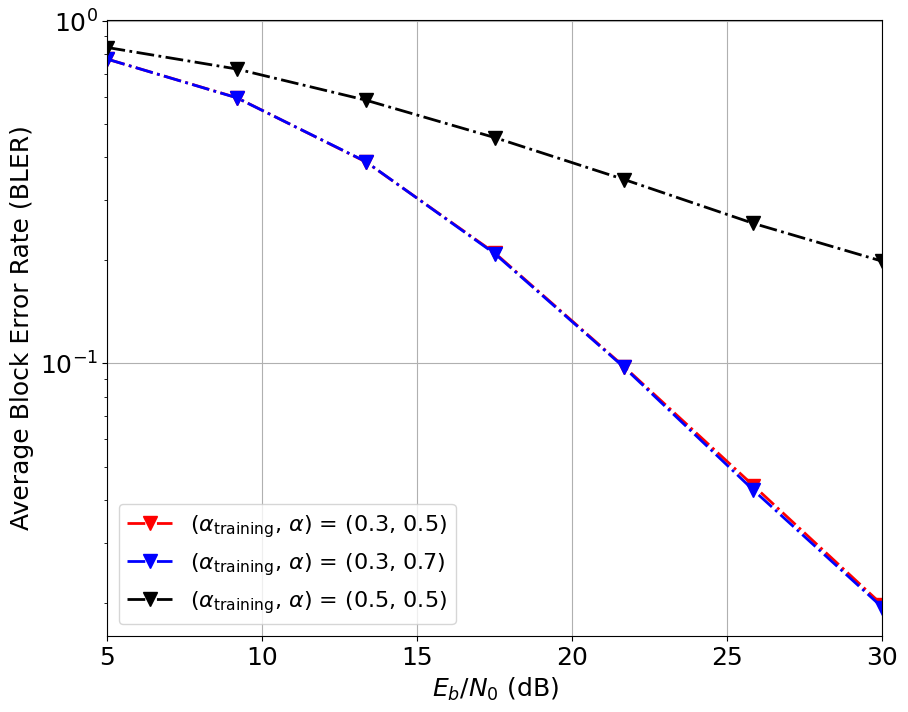

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

training_Eb_N0_dB = 30

mu_user = np.ones(K)
mu_c = 0.5


training_bet = 0 # Training delayed CSIT parameter
bet = 0

L_enc = 3
N_enc = 64
L_dec = 2
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

SIA_mode = True
MIA_mode = True
TIA_mode = False

fig_count = 0
for (simulation_num, training_alph, alph) in [(1, 0.3, 0.5), (2, 0.3, 0.7), (3, 0.5, 0.5)]:

  training_gam = 0.8
  gam = 1

  print(f'simulation {simulation_num} is running: ' + r'($\alpha_\text{training}$, $\alpha$) = ' + f'({training_alph}, {alph})')

  n = 2
  b = 6

  b_c = 2

  seed_value = 42

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c_t = np.ones((T,),dtype=np.int32)*b_c # Number of bits in the common message of each time interval

  if simulation_num != 2:
    # setting seeds for reproducibility
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)

    # Training==================================================================
    tf.keras.backend.clear_session() # Ensures a clean slate for each run
    Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                  training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                  SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                  L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                  n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                  progress_print = True)
  # BLER Evaluation=============================================================
  n_samples_eval = 100_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)
  for i in range(Eb_N0_dB_eval_num):
    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])
    # Power constraint in each channel use is 1.0

    # Messages ===
    messages_one_hot_list = []
    for t in range(T):
      for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    if SIA_mode or MIA_mode:
      # Current CSIT parameters:
      sigm = np.empty((T,))
      for t in range(T):
        alph_P = alph*snr[t]/(snr[t]+1-alph)
        sigm[t] = snr[t]**(-alph_P)

    if TIA_mode:
      # Delayed CSIT parameters:
      sigma_FB = np.empty((T,))
      for t in range(T):
        bet_P = bet*snr[t]/(snr[t]+1-bet)
        sigma_FB[t] = snr[t]**(-bet_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
        csir_list.append(channel_t_n - csir_t_n)

        # Current CSIT
        if SIA_mode or MIA_mode:
          current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
          current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # Delayed CSIT
        if TIA_mode and t < T-1:
          delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

    # --- Tx ---
    tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

    # --- Channel ---
    if MIA_mode:
      enc_output = tx_output[:T]
    else:
      enc_output = tx_output

    if T > 1:
      ch_output = ch_model(enc_output + channel_list)
    else:
      ch_output = ch_model([enc_output] + channel_list)

    # --- AWGN ---
    if T > 1:
      received_signal = []
      for t in range(T):
        received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
    else:
      received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

    # --- Decoder ---
    if T > 1:
      decoder_output = Decoder(received_signal + csir_list)
    else:
      decoder_output = Decoder([received_signal] + csir_list)

    if MIA_mode or TIA_mode:
      messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
    else:
      messages_prediction_prob = decoder_output # predicted user messages as probability vectors

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_one_hot_list[t * K + k].numpy().argmax(axis = -1) !=
                                      messages_prediction_prob[t * K + k].numpy().argmax(axis = -1)) / n_samples_eval
        if b_t_k[t,k] != 0:
          mean_BLER_count += b_t_k[t,k]
          mean_BLER[i] = mean_BLER[i] + BLER[t,k]*b_t_k[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/mean_BLER_count

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'($\alpha_\text{training}$, $\alpha$) = ' + f'({training_alph}, {alph})'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'($\alpha_\text{training}$, $\alpha$) = ' + f'({training_alph}, {alph})'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'($\alpha_\text{training}$, $\alpha$) = ' + f'({training_alph}, {alph})'


# --- BLER plot ---
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-.v', markersize=10, linewidth = 2, label = label2)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-.v', markersize=10, linewidth = 2, label = label3)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$: Sensitivity on $\alpha_\text{train}$ and $\alpha$', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_alpha_effect.png')

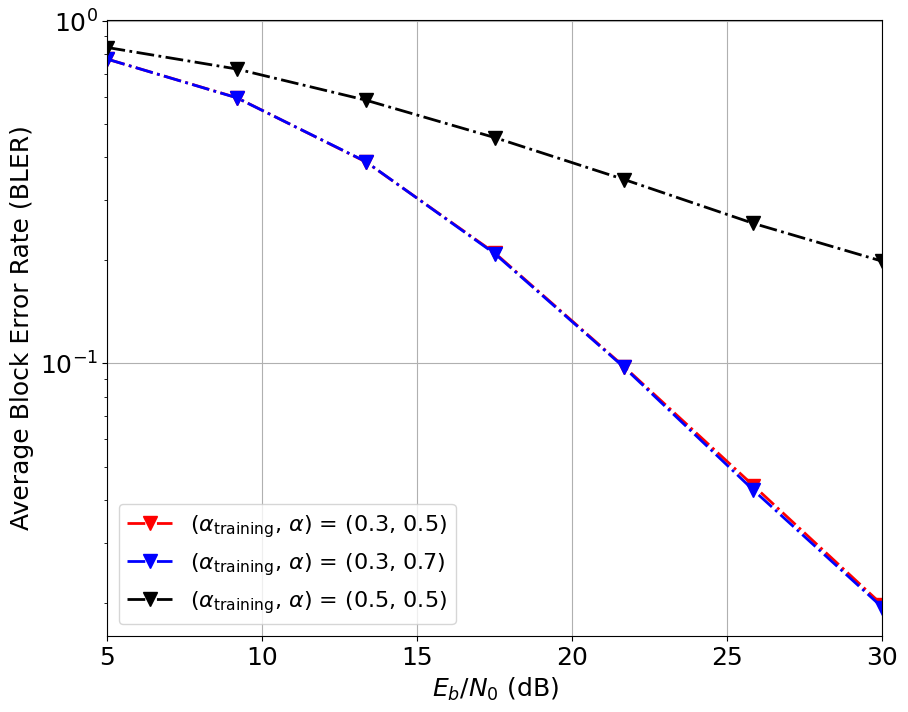

In [ ]:
n_samples_eval = 100_000
Eb_N0_dB_eval_num = 7
Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

mean_BLER1 = np.array([0.771485, 0.595935, 0.387015, 0.209675, 0.09776, 0.044, 0.01971])
label1 = r'($\alpha_\text{training}$, $\alpha$) = ' + f'({0.3}, {0.5})'

mean_BLER2 = np.array([0.771525, 0.595415, 0.38769,  0.208615, 0.097285, 0.04268,  0.01939])
label2 = r'($\alpha_\text{training}$, $\alpha$) = ' + f'({0.3}, {0.7})'

mean_BLER3 = np.array([0.83441, 0.72235, 0.585895, 0.45545, 0.34382, 0.256045, 0.19846])
label3 = r'($\alpha_\text{training}$, $\alpha$) = ' + f'({0.5}, {0.5})'

# --- BLER plot ---
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-.v', markersize=10, linewidth = 2, label = label2)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-.v', markersize=10, linewidth = 2, label = label3)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$: [1, Figure 14]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_alpha_effect.png')

## 9.5. CSIR Quality During Training and Evaluation [1, Figure 15]

simulation 1 is running: ($\gamma_\text{training}$, $\gamma$) = (0.8, 1)
Epoch 1/30
97/97 - tot_loss: 3.443
Epoch 2/30
97/97 - tot_loss: 2.077
Epoch 3/30
97/97 - tot_loss: 1.230
Epoch 4/30
97/97 - tot_loss: 0.675
Epoch 5/30
97/97 - tot_loss: 0.433
Epoch 6/30
97/97 - tot_loss: 0.373
Epoch 7/30
97/97 - tot_loss: 0.263
Epoch 8/30
97/97 - tot_loss: 0.237
Epoch 9/30
97/97 - tot_loss: 0.220
Epoch 10/30
97/97 - tot_loss: 0.191
Epoch 11/30
97/97 - tot_loss: 0.186
Epoch 12/30
97/97 - tot_loss: 0.185
Epoch 13/30
97/97 - tot_loss: 0.189
Epoch 14/30
97/97 - tot_loss: 0.179
Epoch 15/30
97/97 - tot_loss: 0.173
Epoch 16/30
97/97 - tot_loss: 0.137
Epoch 17/30
97/97 - tot_loss: 0.140
Epoch 18/30
97/97 - tot_loss: 0.134
Epoch 19/30
97/97 - tot_loss: 0.132
Epoch 20/30
97/97 - tot_loss: 0.135
Epoch 21/30
97/97 - tot_loss: 0.137
Epoch 22/30
97/97 - tot_loss: 0.140
Epoch 23/30
97/97 - tot_loss: 0.134
Epoch 24/30
97/97 - tot_loss: 0.126
Epoch 25/30
97/97 - tot_loss: 0.134
Epoch 26/30
97/97 - tot_loss: 0.130


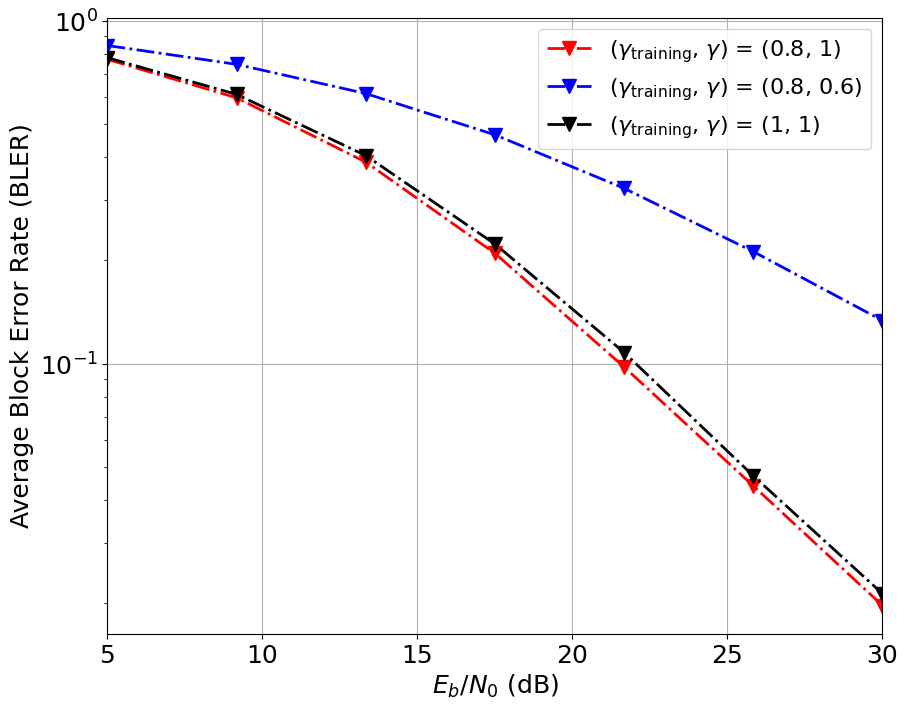

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

training_Eb_N0_dB = 30

mu_user = np.ones(K)
mu_c = 0.5

training_bet = 0 # Training delayed CSIT parameter
bet = 0

L_enc = 3
N_enc = 64
L_dec = 2
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

SIA_mode = True
MIA_mode = True
TIA_mode = False

fig_count = 0
for (simulation_num, training_gam, gam) in [(1, 0.8, 1), (2, 0.8, 0.6), (3, 1, 1)]:

  training_alph = 0.3
  alpha = 0.5

  print(f'simulation {simulation_num} is running: ' + r'($\gamma_\text{training}$, $\gamma$) = ' + f'({training_gam}, {gam})')

  n = 2
  b = 6

  b_c = 2

  seed_value = 42

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c_t = np.ones((T,),dtype=np.int32)*b_c # Number of bits in the common message of each time interval

  if simulation_num != 2:
    # setting seeds for reproducibility
    tf.random.set_seed(seed_value)
    tf.keras.utils.set_random_seed(seed_value)

    # Training==================================================================
    tf.keras.backend.clear_session() # Ensures a clean slate for each run
    Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                  training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                  SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                  L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                  n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                  progress_print = True)
  # BLER Evaluation ============================================================
  n_samples_eval = 100_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)
  for i in range(Eb_N0_dB_eval_num):
    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])
    # Power constraint in each channel use is 1.0

    # Messages ===
    messages_one_hot_list = []
    for t in range(T):
      for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    if SIA_mode or MIA_mode:
      # Current CSIT parameters:
      sigm = np.empty((T,))
      for t in range(T):
        alph_P = alph*snr[t]/(snr[t]+1-alph)
        sigm[t] = snr[t]**(-alph_P)

    if TIA_mode:
      # Delayed CSIT parameters:
      sigma_FB = np.empty((T,))
      for t in range(T):
        bet_P = bet*snr[t]/(snr[t]+1-bet)
        sigma_FB[t] = snr[t]**(-bet_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
        csir_list.append(channel_t_n - csir_t_n)

        # Current CSIT
        if SIA_mode or MIA_mode:
          current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
          current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # Delayed CSIT
        if TIA_mode and t < T-1:
          delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

    # --- Tx ---
    tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

    # --- Channel ---
    if MIA_mode:
      enc_output = tx_output[:T]
    else:
      enc_output = tx_output

    if T > 1:
      ch_output = ch_model(enc_output + channel_list)
    else:
      ch_output = ch_model([enc_output] + channel_list)

    # --- AWGN ---
    if T > 1:
      received_signal = []
      for t in range(T):
        received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
    else:
      received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

    # --- Decoder ---
    if T > 1:
      decoder_output = Decoder(received_signal + csir_list)
    else:
      decoder_output = Decoder([received_signal] + csir_list)

    if MIA_mode or TIA_mode:
      messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
    else:
      messages_prediction_prob = decoder_output # predicted user messages as probability vectors

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_one_hot_list[t * K + k].numpy().argmax(axis = -1) !=
                                      messages_prediction_prob[t * K + k].numpy().argmax(axis = -1)) / n_samples_eval
        if b_t_k[t,k] != 0:
          mean_BLER_count += b_t_k[t,k]
          mean_BLER[i] = mean_BLER[i] + BLER[t,k]*b_t_k[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/mean_BLER_count

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'($\gamma_\text{training}$, $\gamma$) = ' + f'({training_gam}, {gam})'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'($\gamma_\text{training}$, $\gamma$) = ' + f'({training_gam}, {gam})'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'($\gamma_\text{training}$, $\gamma$) = ' + f'({training_gam}, {gam})'


# --- BLER plot ---
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-.v', markersize=10, linewidth = 2, label = label2)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-.v', markersize=10, linewidth = 2, label = label3)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$: Sensitivity on $\gamma_\text{train}$ and $\gamma$', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_gamma_effect.png')

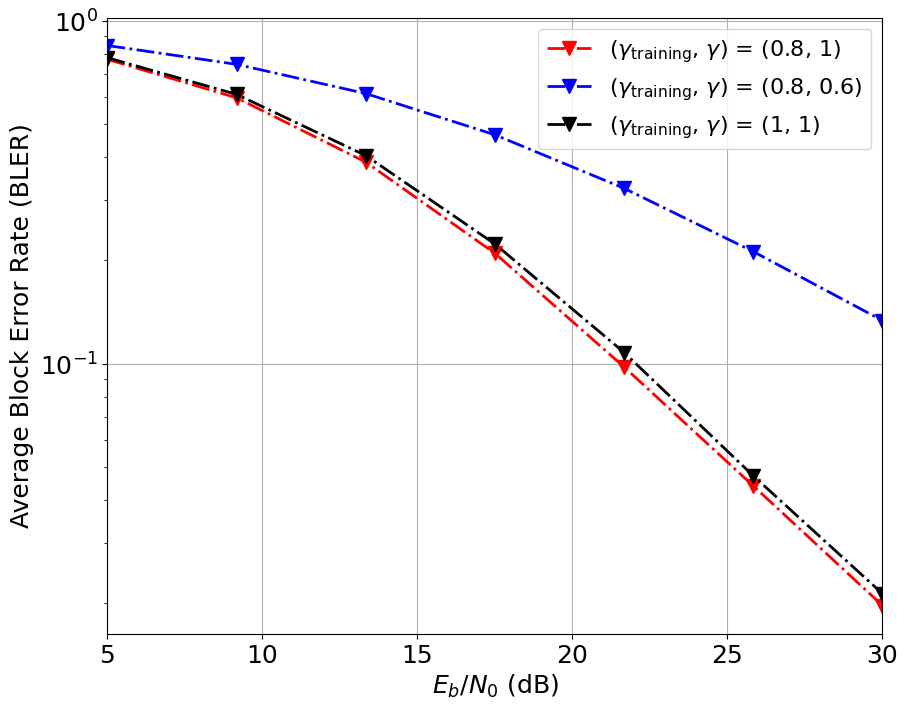

In [ ]:
n_samples_eval = 100_000
Eb_N0_dB_eval_num = 7
Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

mean_BLER1 = np.array([0.771485, 0.595935, 0.387015, 0.209675, 0.09776, 0.044, 0.01971])
label1 = r'($\gamma_\text{training}$, $\gamma$) = ' + f'({0.8}, {1})'

mean_BLER2 = np.array([0.84672, 0.746155, 0.613255, 0.46481, 0.32453, 0.21222, 0.13355])
label2 = r'($\gamma_\text{training}$, $\gamma$) = ' + f'({0.8}, {0.6})'

mean_BLER3 = np.array([0.780015, 0.609705, 0.4044, 0.223175, 0.10777, 0.047065, 0.02134])
label3 = r'($\gamma_\text{training}$, $\gamma$) = ' + f'({1}, {1})'

# --- BLER plot ---
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-.v', markersize=10, linewidth = 2, label = label2)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-.v', markersize=10, linewidth = 2, label = label3)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$: [1, Figure 15]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_gamma_effect.png')

## 9.6. Scalability to Higher Values of $M$ and $K$ [1, Figure 16]

simulation 1 is running: (n, b) = (2, 3), bc = 2, (L_enc, L_dec) = (3, 2)
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['ch_input_encoded_signals_0', 'ch_input_channel_matrix_0_0', 'ch_input_channel_matrix_0_1']
Received: inputs=[['Tensor(shape=(1024, 16))'], 'Tensor(shape=(1024, 4, 8))', 'Tensor(shape=(1024, 4, 8))']
  warnings.warn(msg)


97/97 - tot_loss: 1.843
Epoch 2/30
97/97 - tot_loss: 1.375
Epoch 3/30
97/97 - tot_loss: 1.553
Epoch 4/30
97/97 - tot_loss: 1.666
Epoch 5/30
97/97 - tot_loss: 1.632
Epoch 6/30
97/97 - tot_loss: 0.835
Epoch 7/30
97/97 - tot_loss: 0.250
Epoch 8/30
97/97 - tot_loss: 0.180
Epoch 9/30
97/97 - tot_loss: 0.180
Epoch 10/30
97/97 - tot_loss: 0.151
Epoch 11/30
97/97 - tot_loss: 0.146
Epoch 12/30
97/97 - tot_loss: 0.127
Epoch 13/30
97/97 - tot_loss: 0.129
Epoch 14/30
97/97 - tot_loss: 0.129
Epoch 15/30
97/97 - tot_loss: 0.123
Epoch 16/30
97/97 - tot_loss: 0.100
Epoch 17/30
97/97 - tot_loss: 0.101
Epoch 18/30
97/97 - tot_loss: 0.102
Epoch 19/30
97/97 - tot_loss: 0.097
Epoch 20/30
97/97 - tot_loss: 0.097
Epoch 21/30
97/97 - tot_loss: 0.097
Epoch 22/30
97/97 - tot_loss: 0.097
Epoch 23/30
97/97 - tot_loss: 0.094
Epoch 24/30
97/97 - tot_loss: 0.096
Epoch 25/30
97/97 - tot_loss: 0.092
Epoch 26/30
97/97 - tot_loss: 0.091
Epoch 27/30
97/97 - tot_loss: 0.094
Epoch 28/30
97/97 - tot_loss: 0.091
Epoch 29/30


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['ch_input_encoded_signals_0', 'ch_input_channel_matrix_0_0', 'ch_input_channel_matrix_0_1']
Received: inputs=[['Tensor(shape=(100000, 16))'], 'Tensor(shape=(100000, 4, 8))', 'Tensor(shape=(100000, 4, 8))']
  warnings.warn(msg)


simulation 2 is running: (n, b) = (2, 4), bc = 4, (L_enc, L_dec) = (5, 1)
Epoch 1/30
97/97 - tot_loss: 2.627
Epoch 2/30
97/97 - tot_loss: 2.310
Epoch 3/30
97/97 - tot_loss: 1.886
Epoch 4/30
97/97 - tot_loss: 1.479
Epoch 5/30
97/97 - tot_loss: 1.313
Epoch 6/30
97/97 - tot_loss: 1.175
Epoch 7/30
97/97 - tot_loss: 1.076
Epoch 8/30
97/97 - tot_loss: 0.997
Epoch 9/30
97/97 - tot_loss: 0.933
Epoch 10/30
97/97 - tot_loss: 0.880
Epoch 11/30
97/97 - tot_loss: 0.835
Epoch 12/30
97/97 - tot_loss: 0.803
Epoch 13/30
97/97 - tot_loss: 0.772
Epoch 14/30
97/97 - tot_loss: 0.739
Epoch 15/30
97/97 - tot_loss: 0.715
Epoch 16/30
97/97 - tot_loss: 0.681
Epoch 17/30
97/97 - tot_loss: 0.673
Epoch 18/30
97/97 - tot_loss: 0.668
Epoch 19/30
97/97 - tot_loss: 0.661
Epoch 20/30
97/97 - tot_loss: 0.658
Epoch 21/30
97/97 - tot_loss: 0.650
Epoch 22/30
97/97 - tot_loss: 0.645
Epoch 23/30
97/97 - tot_loss: 0.637
Epoch 24/30
97/97 - tot_loss: 0.634
Epoch 25/30
97/97 - tot_loss: 0.630
Epoch 26/30
97/97 - tot_loss: 0.625

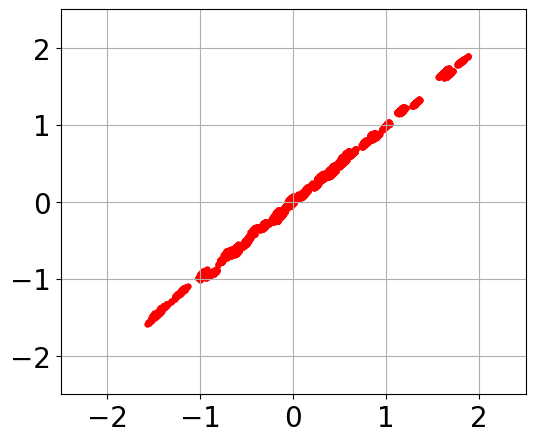

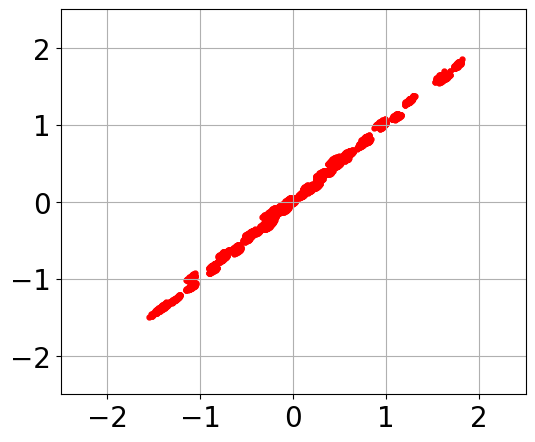

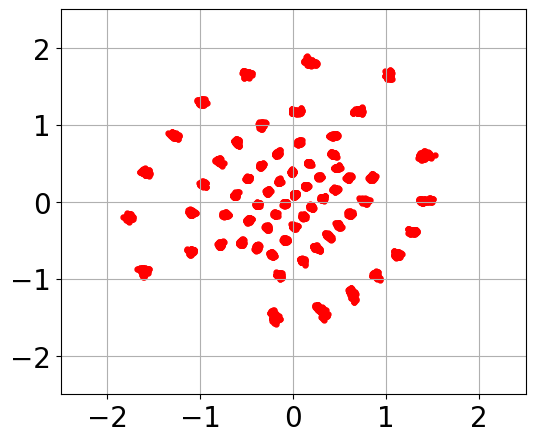

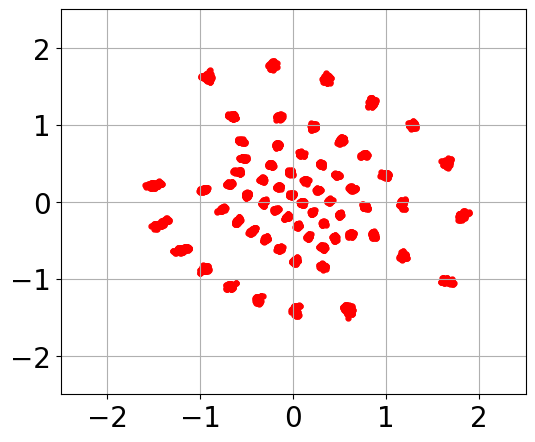

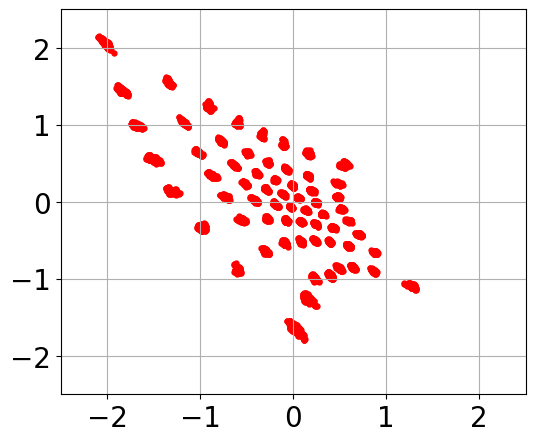

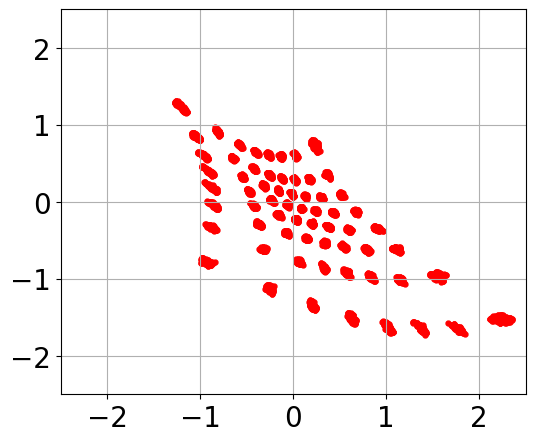

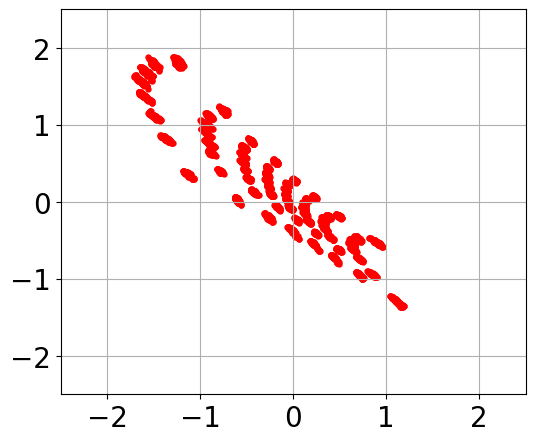

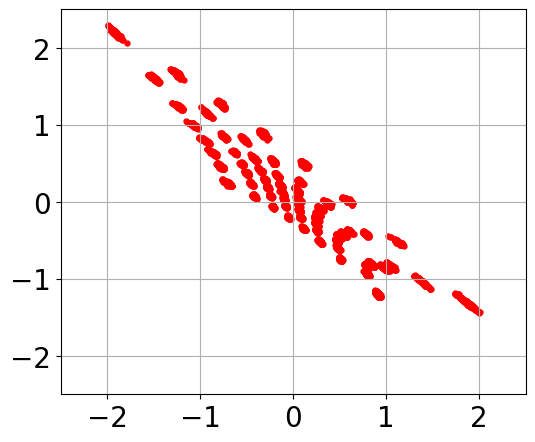

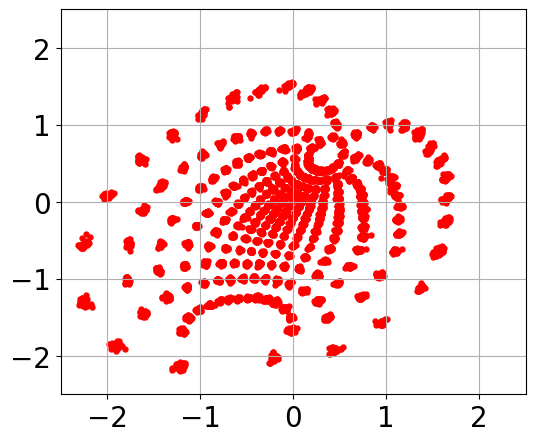

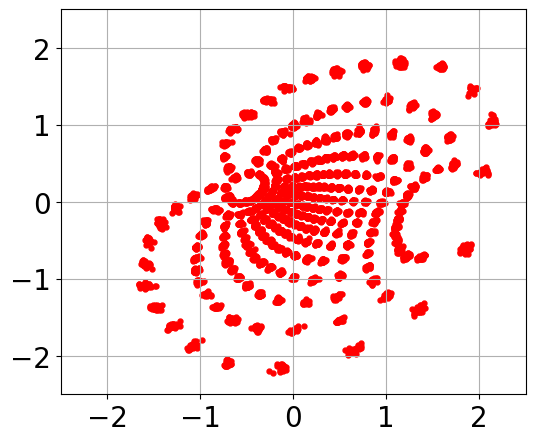

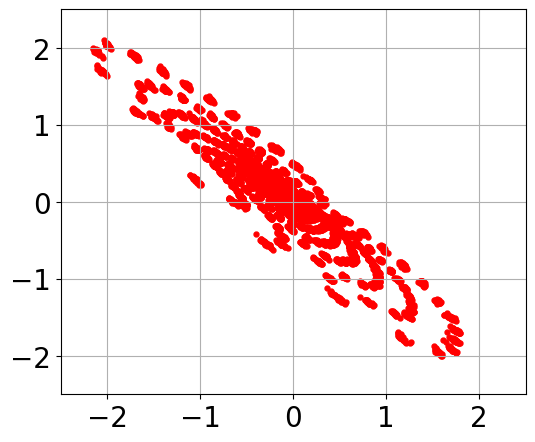

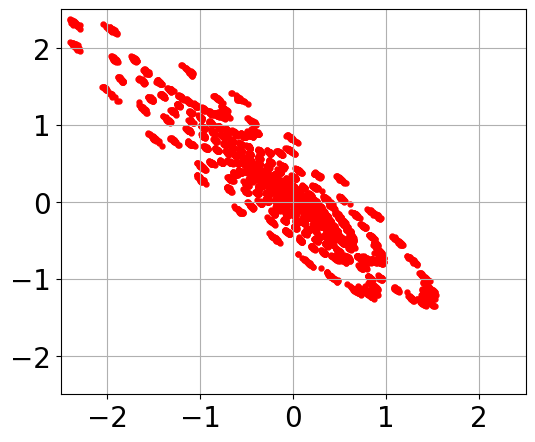

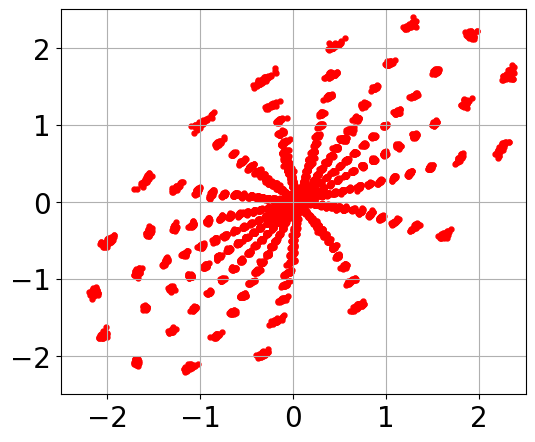

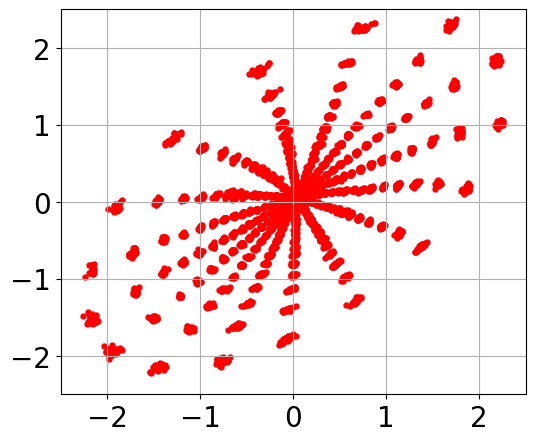

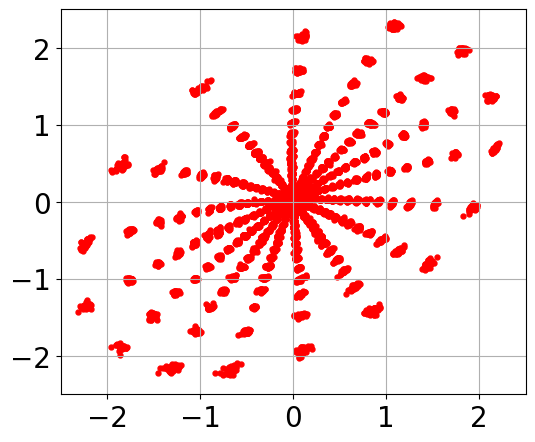

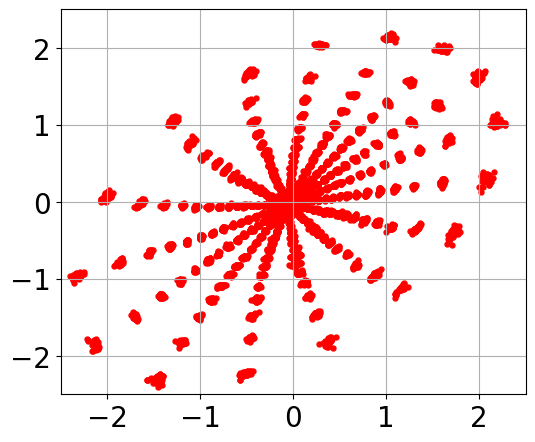

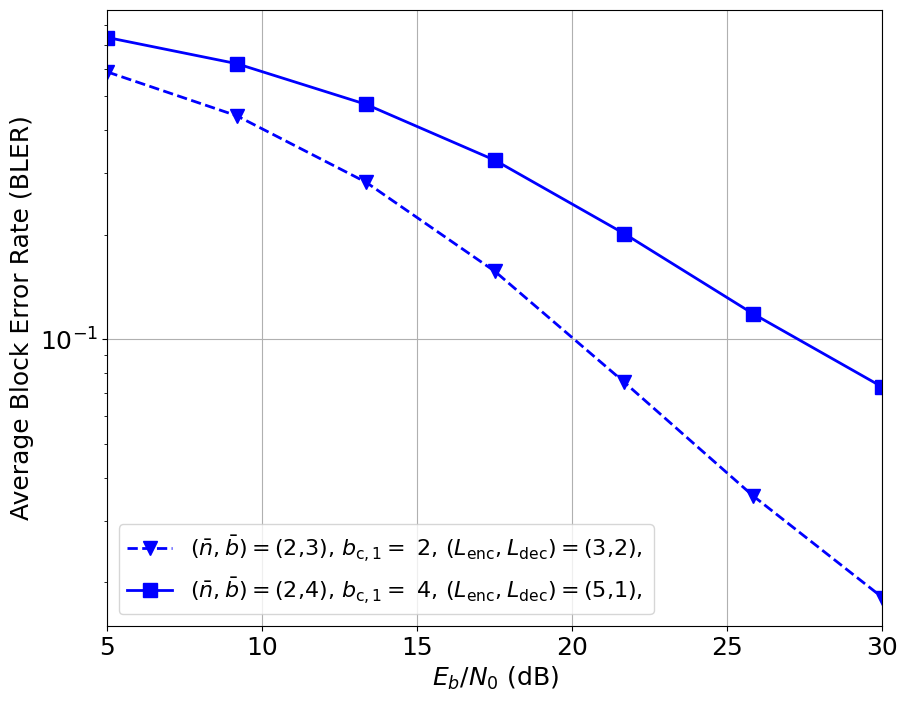

In [ ]:
# Parameters====================================================================
M = 4
K = 4
T = 1 # Number of time intervals

training_Eb_N0_dB = 30

mu_user = np.ones(K)
mu_c = 0.5

training_gam = 0.8 # Training CSIR parameter
training_alph = 0.3 # Training current CSIT parameter
training_bet = 0 # Training delayed CSIT parameter

gam = 1
alph = 0.5
bet = 0

#L_enc = 5
N_enc = 64
#L_dec = 1
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

SIA_mode = True
MIA_mode = True
TIA_mode = False

seed_value = 42

fig_count = 0
for (simulation_num, n, b, b_c, L_enc, L_dec) in [(1, 2, 3, 2, 3, 2), (2, 2, 4, 4, 5, 1)]:

  print(f'simulation {simulation_num} is running: (n, b) = ({n}, {b}), bc = {b_c}, (L_enc, L_dec) = ({L_enc}, {L_dec})')


  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c_t = np.ones((T,),dtype=np.int32)*b_c # Number of bits in the common message of each time interval

  # setting seeds for reproducibility
  tf.random.set_seed(seed_value)
  tf.keras.utils.set_random_seed(seed_value)

  # Training====================================================================
  tf.keras.backend.clear_session() # Ensures a clean slate for each run
  Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                progress_print = True)
  # Symbol Plot=================================================================
  plot_samples = 10_000 #500

  # --- Noise power ---
  Eb_N0_dB_plot = 20
  Eb_N0 = 10**(Eb_N0_dB_plot/10)
  snr = np.empty((T,))
  noise_std = np.empty((T,))
  for t in range(T):
    snr[t] = Eb_N0*b/(n_t[t])
    noise_std[t] = sqrt(0.5/snr[t])
  # Power constraint in each channel use is 1.0

  # --- Channel ---
  channel_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
      channel_list_sample.append(channel_t_n)

  # --- CSIR and CSIT ---
  # CSIR parameters:
  csir_sigm = np.empty((T,))
  for t in range(T):
    gam_P = gam*snr[t]/(snr[t]+1-gam)
    csir_sigm[t] = snr[t]**(-gam_P)

  if SIA_mode or MIA_mode:
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

  if TIA_mode:
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

  csir_list_sample = []
  current_CSIT_list_sample = []
  delayed_CSIT_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = channel_list_sample[np.sum(n_t[:t]) + n_index]

      # CSIR
      csir_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
      csir_list_sample.append(channel_t_n - csir_t_n)

      # Current CSIT
      if SIA_mode or MIA_mode:
        current_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
        current_CSIT_list_sample.append(channel_t_n - current_ch_error_t_n)

      # Delayed CSIT
      if TIA_mode and t < T-1:
        delayed_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
        delayed_CSIT_list_sample.append(channel_t_n - delayed_ch_error_t_n)

  # --- Messages ---
  messages_one_hot_list_sample = []
  for t in range(T):
      for k in range(K):
          messages_t_k = tf.random.uniform(shape=(plot_samples,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
          messages_one_hot_list_sample.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

  # --- Tx ---
  tx_output = Tx(inputs = messages_one_hot_list_sample + current_CSIT_list_sample + delayed_CSIT_list_sample)
  if MIA_mode:
    enc_output = tx_output[:T]
  else:
    enc_output = tx_output

  # --- Symbols Plot ---
  for t in range(T): # time interval
    for n_index in range(n_t[t]): # Channel use
      for i in range(M): # Antenna
        fig_count = fig_count + 1
        plt.figure(fig_count,figsize=(6, 5))
        # (i)th neuron and (i+M)th are respectively real and imaginary part of the (i)th element of the codeword:
        if MIA_mode or T > 1:
          plt.scatter(enc_output[t][:, n_index*2*M+i], enc_output[t][:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        else:
          plt.scatter(enc_output[:, n_index*2*M+i], enc_output[:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        plt.xlim([-2.5,2.5])
        plt.ylim([-2.5,2.5])
        #plt.title(r'$t=$' + f'{t+1}, ' + r'$n=$'+ f'{n_index+1}, ' + 'Antenna {i+1}')
        plt.tick_params(axis='both', labelsize=20)
        plt.grid()
        plt.savefig(f"Symbols_(n_b_bc)_({n}_{b}_{b_c})_time_{t+1}_channel_use_{n_index+1}_antenna_{i+1}_Simulation_4.png")
  # BLER Evaluation=============================================================
  n_samples_eval = 100_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)
  for i in range(Eb_N0_dB_eval_num):
    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])
    # Power constraint in each channel use is 1.0

    # Messages ===
    messages_one_hot_list = []
    for t in range(T):
      for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    if SIA_mode or MIA_mode:
      # Current CSIT parameters:
      sigm = np.empty((T,))
      for t in range(T):
        alph_P = alph*snr[t]/(snr[t]+1-alph)
        sigm[t] = snr[t]**(-alph_P)

    if TIA_mode:
      # Delayed CSIT parameters:
      sigma_FB = np.empty((T,))
      for t in range(T):
        bet_P = bet*snr[t]/(snr[t]+1-bet)
        sigma_FB[t] = snr[t]**(-bet_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
        csir_list.append(channel_t_n - csir_t_n)

        # Current CSIT
        if SIA_mode or MIA_mode:
          current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
          current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # Delayed CSIT
        if TIA_mode and t < T-1:
          delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

    # --- Tx ---
    tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

    # --- Channel ---
    if MIA_mode:
      enc_output = tx_output[:T]
    else:
      enc_output = tx_output

    if T > 1:
      ch_output = ch_model(enc_output + channel_list)
    else:
      ch_output = ch_model([enc_output] + channel_list)

    # --- AWGN ---
    if T > 1:
      received_signal = []
      for t in range(T):
        received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
    else:
      received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

    # --- Decoder ---
    if T > 1:
      decoder_output = Decoder(received_signal + csir_list)
    else:
      decoder_output = Decoder([received_signal] + csir_list)

    if MIA_mode or TIA_mode:
      messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
    else:
      messages_prediction_prob = decoder_output # predicted user messages as probability vectors

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_one_hot_list[t * K + k].numpy().argmax(axis = -1) !=
                                      messages_prediction_prob[t * K + k].numpy().argmax(axis = -1)) / n_samples_eval
        if b_t_k[t,k] != 0:
          mean_BLER_count += b_t_k[t,k]
          mean_BLER[i] = mean_BLER[i] + BLER[t,k]*b_t_k[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/mean_BLER_count

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}, ' + r'$(L_\text{enc},L_\text{dec})=$' + f'({L_enc},{L_dec})'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$(\bar{n},\bar{b})=$' + f'({n},{b}), ' + r'$b_{\text{c},1}=$ ' + f'{b_c_t[0]}, ' + r'$(L_\text{enc},L_\text{dec})=$' + f'({L_enc},{L_dec})'

# --- BLER plot ---
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'b--v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-s', markersize=10, linewidth = 2, label = label2)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$ scalability to higher values of M and K', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_scalability.png')

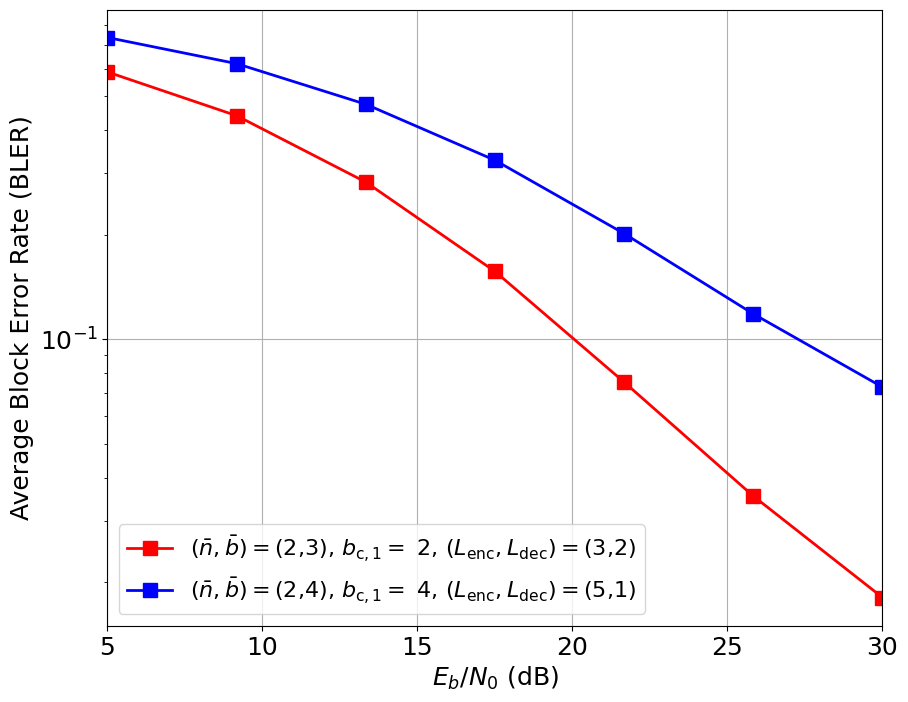

In [ ]:
Eb_N0_dB_eval_num = 7
Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

mean_BLER1 = np.array([0.587345,  0.4396675, 0.2832225, 0.1567325, 0.0752875, 0.0354025, 0.0180825])
label1 = r'$(\bar{n},\bar{b})=$' + f'({2},{3}), ' + r'$b_{\text{c},1}=$ ' + f'{2}, ' + r'$(L_\text{enc},L_\text{dec})=$' + f'({3},{2})'

mean_BLER2 = np.array([0.7379325, 0.62072,   0.474275,  0.3272825, 0.2013975, 0.11832,   0.0728575])
label2 = r'$(\bar{n},\bar{b})=$' + f'({2},{4}), ' + r'$b_{\text{c},1}=$ ' + f'{4}, ' + r'$(L_\text{enc},L_\text{dec})=$' + f'({5},{1})'

# --- BLER plot ---
fig_count = 0
fig_count = fig_count + 1
plt.figure(fig_count,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-s', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-s', markersize=10, linewidth = 2, label = label2)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$: [1, Figure 16]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_scalability.png')

## 9.7. Parameter Count and Execution Run time

In [ ]:
import time
import os

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 1 # Number of time intervals

training_Eb_N0_dB = 30

mu_user = np.ones(K)
mu_c = 0.5

training_gam = 0.8 # Training CSIR parameter
training_alph = 0.3 # Training current CSIT parameter
training_bet = 0 # Training delayed CSIT parameter

gam = 1
alph = 0.5
bet = 0

L_enc = 3
N_enc = 64
L_dec = 2
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

SIA_mode = True
MIA_mode = True
TIA_mode = False

elapsed_time = np.zeros(2)
for (simulation_num, n, b, b_c, seed_value) in [(1, 1, 3, 2, 42), (2, 2, 6, 2, 42)]:

  print(f'simulation {simulation_num} is running: (n,b,b_c) = ({n}, {b}, {b_c})')

  n_t = np.ones((T,),dtype=np.int32)*n # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval
  b_c_t = np.ones((T,),dtype=np.int32)*b_c # Number of bits in the common message of each time interval

  # setting seeds for reproducibility
  tf.random.set_seed(seed_value)
  tf.keras.utils.set_random_seed(seed_value)

  # Training====================================================================
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  tf.keras.backend.clear_session() # Ensures a clean slate for each run
  Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                progress_print = False)
  print('\nTransmitter model parameters:')

  trainable_params = np.sum([np.prod(v.shape) for v in Tx.trainable_variables])
  non_trainable_params = np.sum([np.prod(v.shape) for v in Tx.non_trainable_variables])
  total_params = Tx.count_params()

  print(f"\tTrainable parameters: {trainable_params}")
  print(f"\tNon-trainable parameters: {non_trainable_params}")
  print(f"\tTotal parameters: {total_params}\n")


  print('\nDecoder model parameters:')

  trainable_params = np.sum([np.prod(v.shape) for v in Decoder.trainable_variables])
  non_trainable_params = np.sum([np.prod(v.shape) for v in Decoder.non_trainable_variables])
  total_params = Decoder.count_params()

  print(f"\tTrainable parameters: {trainable_params}")
  print(f"\tNon-trainable parameters: {non_trainable_params}")
  print(f"\tTotal parameters: {total_params}\n")

  # Inference Delay=============================================================
  n_samples_eval = 1000
  Eb_N0_dB_eval = 10

  # --- Noise power ---
  Eb_N0 = 10**(Eb_N0_dB_eval/10)
  snr = np.empty((T,))
  noise_std = np.empty((T,))
  for t in range(T):
    snr[t] = Eb_N0*b/(n_t[t])
    noise_std[t] = sqrt(0.5/snr[t])
  # Power constraint in each channel use is 1.0

  # Messages ===
  messages_one_hot_list = []
  for t in range(T):
    for k in range(K):
      messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
      messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

  # Channel ===
  channel_list = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
      channel_list.append(channel_t_n)

  # --- CSIR and CSIT ---
  # CSIR parameters:
  csir_sigm = np.empty((T,))
  for t in range(T):
    gam_P = gam*snr[t]/(snr[t]+1-gam)
    csir_sigm[t] = snr[t]**(-gam_P)

  if SIA_mode or MIA_mode:
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

  if TIA_mode:
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

  csir_list = []
  current_CSIT_list = []
  delayed_CSIT_list = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

      # CSIR
      csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
      csir_list.append(channel_t_n - csir_t_n)

      # Current CSIT
      if SIA_mode or MIA_mode:
        current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
        current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

      # Delayed CSIT
      if TIA_mode and t < T-1:
        delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
        delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

  start_time = time.time()
  # --- Tx ---
  tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

  # --- Channel ---
  if MIA_mode:
    enc_output = tx_output[:T]
  else:
    enc_output = tx_output

  if T > 1:
    ch_output = ch_model(enc_output + channel_list)
  else:
    ch_output = ch_model([enc_output] + channel_list)

  # --- AWGN ---
  if T > 1:
    received_signal = []
    for t in range(T):
      received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
  else:
    received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

  # --- Decoder ---
  if T > 1:
    decoder_output = Decoder(received_signal + csir_list)
  else:
    decoder_output = Decoder([received_signal] + csir_list)

  if MIA_mode or TIA_mode:
    messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
  else:
    messages_prediction_prob = decoder_output # predicted user messages as probability vectors

  end_time = time.time()

  elapsed_time[simulation_num-1] = end_time - start_time

  print(f'Inference Delay of Simulation Scenario {simulation_num} for {n_samples_eval} Samples: {elapsed_time[simulation_num-1]:0.4f} seconds\n')

simulation 1 is running: (n,b,b_c) = (1, 3, 2)

Transmitter model parameters:
	Trainable parameters: 9992
	Non-trainable parameters: 0.0
	Total parameters: 9992


Decoder model parameters:
	Trainable parameters: 10776
	Non-trainable parameters: 0.0
	Total parameters: 10776

Inference Delay of Simulation Scenario 1 for 1000 Samples: 0.0394 seconds

simulation 2 is running: (n,b,b_c) = (2, 6, 2)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['ch_input_encoded_signals_0', 'ch_input_channel_matrix_0_0']
Received: inputs=[['Tensor(shape=(1000, 4))'], 'Tensor(shape=(1000, 2, 4))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['ch_input_encoded_signals_0', 'ch_input_channel_matrix_0_0', 'ch_input_channel_matrix_0_1']
Received: inputs=[['Tensor(shape=(1024, 8))'], 'Tensor(shape=(1024, 2, 4))', 'Tensor(shape=(1024, 2, 4))']
  warnings.warn(msg)



Transmitter model parameters:
	Trainable parameters: 17548
	Non-trainable parameters: 0.0
	Total parameters: 17548


Decoder model parameters:
	Trainable parameters: 18824
	Non-trainable parameters: 0.0
	Total parameters: 18824

Inference Delay of Simulation Scenario 2 for 1000 Samples: 0.0514 seconds



/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['ch_input_encoded_signals_0', 'ch_input_channel_matrix_0_0', 'ch_input_channel_matrix_0_1']
Received: inputs=[['Tensor(shape=(1000, 8))'], 'Tensor(shape=(1000, 2, 4))', 'Tensor(shape=(1000, 2, 4))']
  warnings.warn(msg)


# 10. Evaluation: Perfect Delayed CSIT and imperfect current CSIT

Since delayed CSIT up to one previous time interval exists:
-  `TIA_mode = True`
-  `T = 2`

Since current CSIT is imperfect message-domain regularization is required. Also, current CSIT makes space-domain interference alignment possible:
-  `MIA_mode = True`
-  `SIA_mode = True`

## 10.1. Learnt Signaling Plot and BLER Evaluation

simulation 2 is running: (n,b) = (3, 8)
Epoch 1/30
97/97 - tot_loss: 2.451
Epoch 2/30
97/97 - tot_loss: 1.927
Epoch 3/30
97/97 - tot_loss: 1.566
Epoch 4/30
97/97 - tot_loss: 1.151
Epoch 5/30
97/97 - tot_loss: 0.873
Epoch 6/30
97/97 - tot_loss: 0.732
Epoch 7/30
97/97 - tot_loss: 0.620
Epoch 8/30
97/97 - tot_loss: 0.545
Epoch 9/30
97/97 - tot_loss: 0.486
Epoch 10/30
97/97 - tot_loss: 0.443
Epoch 11/30
97/97 - tot_loss: 0.406
Epoch 12/30
97/97 - tot_loss: 0.369
Epoch 13/30
97/97 - tot_loss: 0.344
Epoch 14/30
97/97 - tot_loss: 0.317
Epoch 15/30
97/97 - tot_loss: 0.306
Epoch 16/30
97/97 - tot_loss: 0.267
Epoch 17/30
97/97 - tot_loss: 0.262
Epoch 18/30
97/97 - tot_loss: 0.256
Epoch 19/30
97/97 - tot_loss: 0.247
Epoch 20/30
97/97 - tot_loss: 0.245
Epoch 21/30
97/97 - tot_loss: 0.243
Epoch 22/30
97/97 - tot_loss: 0.237
Epoch 23/30
97/97 - tot_loss: 0.235
Epoch 24/30
97/97 - tot_loss: 0.230
Epoch 25/30
97/97 - tot_loss: 0.226
Epoch 26/30
97/97 - tot_loss: 0.226
Epoch 27/30
97/97 - tot_loss: 0.2

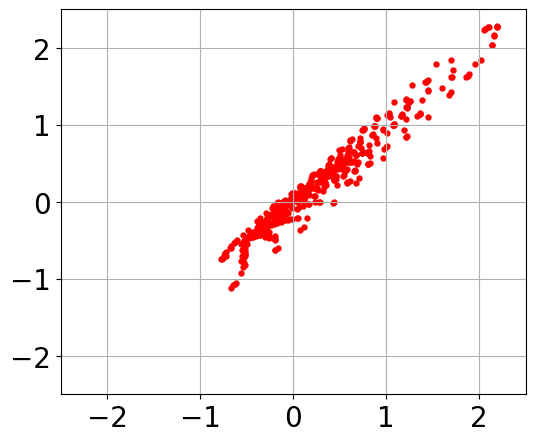

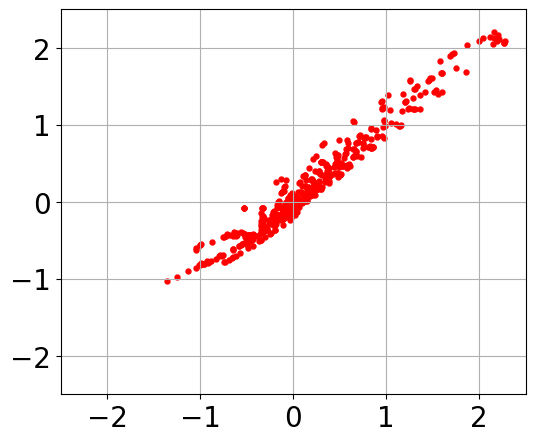

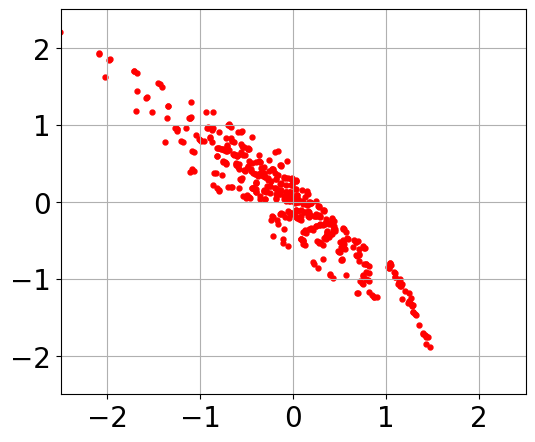

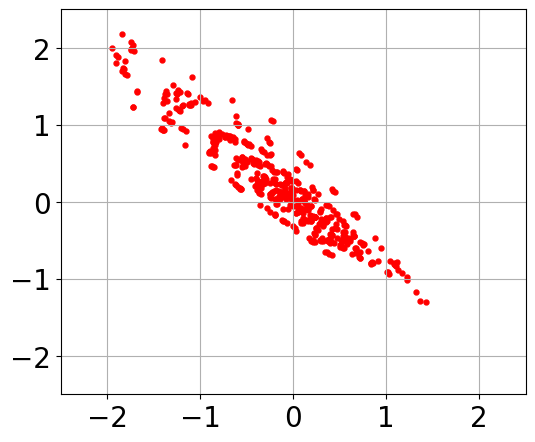

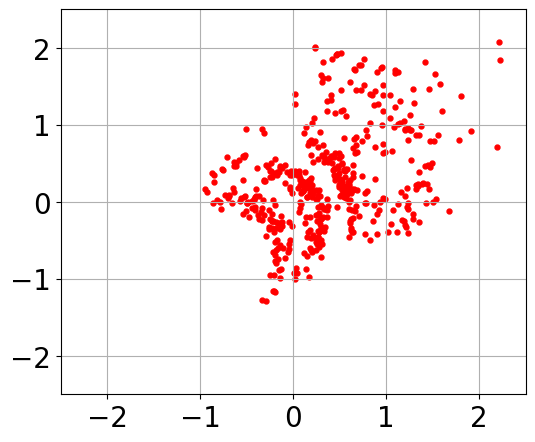

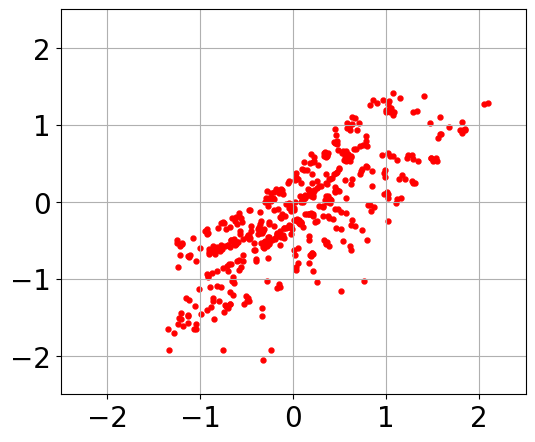

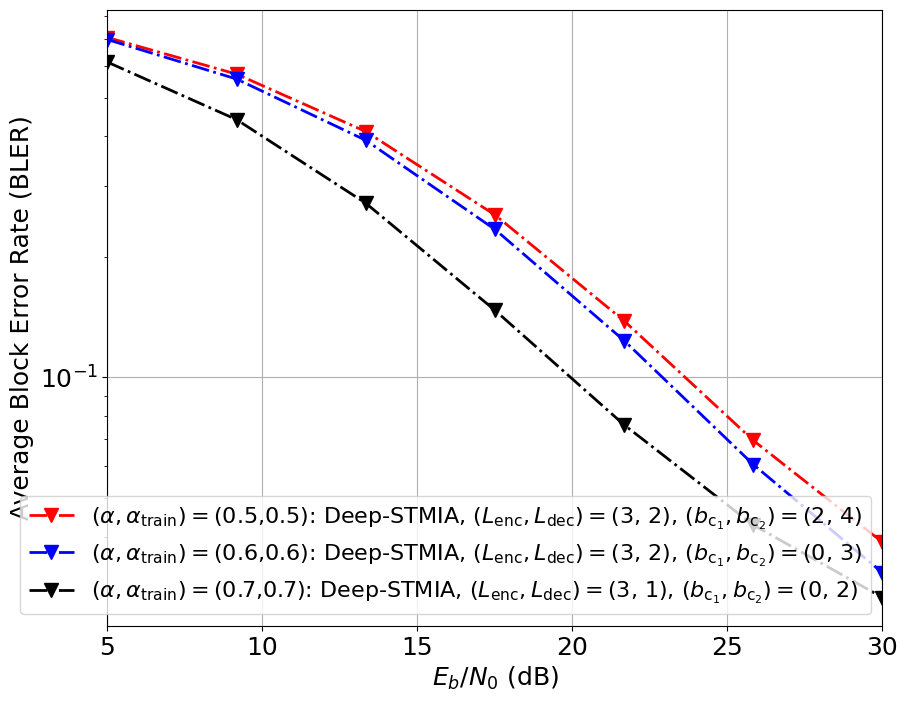

In [ ]:
# Parameters====================================================================
K = 2 # Number of users
M = 2 # Number of BS antennas
T = 2 # Number of time intervals

training_Eb_N0_dB = 30

mu_user = np.ones(K)
mu_c = 0.5

training_gam = 0.8 # Training CSIR parameter
training_bet = 0.8 # Training delayed CSIT parameter

SIA_mode = True
MIA_mode = True
TIA_mode = True

gam = 1
bet = 1

N_enc = 64
N_dec = 64

n_samples = 100_000
epochs = 30
batch_size = 1024
learning_rate1 = 0.005
learning_rate2 = 0.001

fig_count = 0
for (simulation_num, alph, training_alph) in [(1, 0.5), (2, 0.6), (3, 0.7)]:

  training_alph = alph

  n = 1
  b = 4
  print(f'simulation {simulation_num} is running: (n,b) = ({3*n}, {2*b})')

  if simulation_num == 1:
    b_c_t = np.array([2,4]) # Number of bits in the common message of each time interval
    L_enc = 3
    L_dec = 2
  elif simulation_num == 2:
    b_c_t = np.array([0,3])
    L_enc = 3
    L_dec = 2
  elif simulation_num == 3:
    b_c_t = np.array([0,2]) # Number of bits in the common message of each time interval
    L_enc = 3
    L_dec = 1

  n_t = np.array([n,2*n]) # Number of channel uses in each time interval
  b_t_k = np.ones((T,K),dtype=np.int32)*b # Number of bits in each user message in a time interval

  # setting seeds for reproducibility
  tf.random.set_seed(42)
  tf.keras.utils.set_random_seed(42)

  # Training====================================================================
  tf.keras.backend.clear_session() # Ensures a clean slate for each run
  Tx, ch_model, Decoder = E2E_for_imperfect_CSIT(K = K, M = M, T = T, n_t = n_t, b_t_k = b_t_k, b_c_t = b_c_t, mu_user = mu_user, mu_c = mu_c,
                                                training_Eb_N0_dB = training_Eb_N0_dB, gam = training_gam, alph = training_alph, bet = training_bet,
                                                SIA_mode = SIA_mode, MIA_mode = MIA_mode, TIA_mode = TIA_mode,
                                                L_enc = L_enc, N_enc = N_enc, L_dec = L_dec, N_dec = N_dec,
                                                n_samples = n_samples, epochs = epochs, batch_size = batch_size, learning_rate1 = learning_rate1, learning_rate2 = learning_rate2,
                                                progress_print = True)
  # Symbol Plot=================================================================
  plot_samples = 500

  # --- Noise power ---
  Eb_N0_dB_plot = 20
  Eb_N0 = 10**(Eb_N0_dB_plot/10)
  snr = np.empty((T,))
  noise_std = np.empty((T,))
  for t in range(T):
    snr[t] = Eb_N0*b/(n_t[t])
    noise_std[t] = sqrt(0.5/snr[t])
  # Power constraint in each channel use is 1.0

  # --- Channel ---
  channel_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
      channel_list_sample.append(channel_t_n)

  # --- CSIR and CSIT ---
  # CSIR parameters:
  csir_sigm = np.empty((T,))
  for t in range(T):
    gam_P = gam*snr[t]/(snr[t]+1-gam)
    csir_sigm[t] = snr[t]**(-gam_P)

  if SIA_mode or MIA_mode:
    # Current CSIT parameters:
    sigm = np.empty((T,))
    for t in range(T):
      alph_P = alph*snr[t]/(snr[t]+1-alph)
      sigm[t] = snr[t]**(-alph_P)

  if TIA_mode:
    # Delayed CSIT parameters:
    sigma_FB = np.empty((T,))
    for t in range(T):
      bet_P = bet*snr[t]/(snr[t]+1-bet)
      sigma_FB[t] = snr[t]**(-bet_P)

  csir_list_sample = []
  current_CSIT_list_sample = []
  delayed_CSIT_list_sample = []
  for t in range(T):
    for n_index in range(n_t[t]):
      channel_t_n = channel_list_sample[np.sum(n_t[:t]) + n_index]

      # CSIR
      csir_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
      csir_list_sample.append(channel_t_n - csir_t_n)

      # Current CSIT
      if SIA_mode or MIA_mode:
        current_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
        current_CSIT_list_sample.append(channel_t_n - current_ch_error_t_n)

      # Delayed CSIT
      if TIA_mode and t < T-1:
        delayed_ch_error_t_n = tf.random.normal(shape = [plot_samples,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
        delayed_CSIT_list_sample.append(channel_t_n - delayed_ch_error_t_n)

  # --- Messages ---
  messages_one_hot_list_sample = []
  for t in range(T):
      for k in range(K):
          messages_t_k = tf.random.uniform(shape=(plot_samples,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
          messages_one_hot_list_sample.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

  # --- Tx ---
  tx_output = Tx(inputs = messages_one_hot_list_sample + current_CSIT_list_sample + delayed_CSIT_list_sample)
  if MIA_mode:
    enc_output = tx_output[:T]
  else:
    enc_output = tx_output

  # --- Symbols Plot ---
  for t in range(T): # time interval
    for n_index in range(n_t[t]): # Channel use
      for i in range(M): # Antenna
        fig_count = fig_count + 1
        plt.figure(fig_count,figsize=(6, 5))
        # (i)th neuron and (i+M)th are respectively real and imaginary part of the (i)th element of the codeword:
        if MIA_mode or T > 1:
          plt.scatter(enc_output[t][:, n_index*2*M+i], enc_output[t][:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        else:
          plt.scatter(enc_output[:, n_index*2*M+i], enc_output[:, n_index*2*M+i+M], marker = '.', c = 'r', s = 50)
        plt.xlim([-2.5,2.5])
        plt.ylim([-2.5,2.5])
        #plt.title(r'$\alpha=$' + f'{alph}, ' + r'$t=$' + f'{t+1}, ' + r'$n=$'+ f'{n_index+1}, ' + 'Antenna {i+1}')
        plt.tick_params(axis='both', labelsize=20)
        plt.grid()
        plt.savefig(f"Symbols_time_{t+1}_channel_use_{n_index+1}_antenna_{i+1}_alpha_{alph}_Simulation_5.png")
  # BLER Evaluation=============================================================
  n_samples_eval = 100_000
  Eb_N0_dB_eval_num = 7
  Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

  BLER_list = []
  mean_BLER = np.zeros(Eb_N0_dB_eval_num,)
  for i in range(Eb_N0_dB_eval_num):
    # --- Noise power ---
    Eb_N0 = 10**(Eb_N0_dB_eval[i]/10)
    snr = np.empty((T,))
    noise_std = np.empty((T,))
    for t in range(T):
      snr[t] = Eb_N0*b/(n_t[t])
      noise_std[t] = sqrt(0.5/snr[t])
    # Power constraint in each channel use is 1.0

    # Messages ===
    messages_one_hot_list = []
    for t in range(T):
      for k in range(K):
        messages_t_k = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=2**b_t_k[t,k], dtype=tf.int32).numpy() # message indexing
        messages_one_hot_list.append(tf.one_hot(messages_t_k, depth=2**b_t_k[t,k]))

    # Channel ===
    channel_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
        channel_list.append(channel_t_n)

    # --- CSIR and CSIT ---
    # CSIR parameters:
    csir_sigm = np.empty((T,))
    for t in range(T):
      gam_P = gam*snr[t]/(snr[t]+1-gam)
      csir_sigm[t] = snr[t]**(-gam_P)

    if SIA_mode or MIA_mode:
      # Current CSIT parameters:
      sigm = np.empty((T,))
      for t in range(T):
        alph_P = alph*snr[t]/(snr[t]+1-alph)
        sigm[t] = snr[t]**(-alph_P)

    if TIA_mode:
      # Delayed CSIT parameters:
      sigma_FB = np.empty((T,))
      for t in range(T):
        bet_P = bet*snr[t]/(snr[t]+1-bet)
        sigma_FB[t] = snr[t]**(-bet_P)

    csir_list = []
    current_CSIT_list = []
    delayed_CSIT_list = []
    for t in range(T):
      for n_index in range(n_t[t]):
        channel_t_n = channel_list[np.sum(n_t[:t]) + n_index]

        # CSIR
        csir_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*csir_sigm[t]), dtype=tf.dtypes.float32)
        csir_list.append(channel_t_n - csir_t_n)

        # Current CSIT
        if SIA_mode or MIA_mode:
          current_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigm[t]), dtype=tf.dtypes.float32)
          current_CSIT_list.append(channel_t_n - current_ch_error_t_n)

        # Delayed CSIT
        if TIA_mode and t < T-1:
          delayed_ch_error_t_n = tf.random.normal(shape = [n_samples_eval,K,2*M], mean=0.0, stddev=np.sqrt(0.5*sigma_FB[t]), dtype=tf.dtypes.float32)
          delayed_CSIT_list.append(channel_t_n - delayed_ch_error_t_n)

    # --- Tx ---
    tx_output = Tx(inputs = messages_one_hot_list + current_CSIT_list + delayed_CSIT_list)

    # --- Channel ---
    if MIA_mode or TIA_mode:
      enc_output = tx_output[:T]
    else:
      enc_output = tx_output

    if T > 1:
      ch_output = ch_model(enc_output + channel_list)
    else:
      ch_output = ch_model([enc_output] + channel_list)

    # --- AWGN ---
    if T > 1:
      received_signal = []
      for t in range(T):
        received_signal.append(ch_output[t] + tf.random.normal(shape=tf.shape(ch_output[t]), mean=0.0, stddev=noise_std[t]))
    else:
      received_signal = ch_output + tf.random.normal(shape=tf.shape(ch_output), mean=0.0, stddev=noise_std[0])

    # --- Decoder ---
    if T > 1:
      decoder_output = Decoder(received_signal + csir_list)
    else:
      decoder_output = Decoder([received_signal] + csir_list)

    if MIA_mode or TIA_mode:
      messages_prediction_prob = decoder_output[:T*K] # predicted user messages as probability vectors
    else:
      messages_prediction_prob = decoder_output # predicted user messages as probability vectors

    # --- BLER calculation ---
    BLER = np.zeros((T, K))
    mean_BLER_count = 0
    for t in range(T):
      for k in range(K):
        BLER[t,k] = np.count_nonzero(messages_one_hot_list[t * K + k].numpy().argmax(axis = -1) !=
                                      messages_prediction_prob[t * K + k].numpy().argmax(axis = -1)) / n_samples_eval
        if b_t_k[t,k] != 0:
          mean_BLER_count += b_t_k[t,k]
          mean_BLER[i] = mean_BLER[i] + BLER[t,k]*b_t_k[t,k]
    BLER_list.append(BLER)
    mean_BLER[i] = mean_BLER[i]/mean_BLER_count

  if simulation_num == 1:
    mean_BLER1 = np.array(mean_BLER)
    label1 = r'$\alpha = $' + f'{alph}: Deep-STMIA, ' + r'$L_\text{enc}=$' + f'{L_enc}, ' + r'$L_\text{dec}=$' + f'{L_dec}, ' + r'$(b_{\text{c}_1},b_{\text{c}_2})=$' + f'({b_c_t[0]}, {b_c_t[1]})'
  elif simulation_num == 2:
    mean_BLER2 = np.array(mean_BLER)
    label2 = r'$\alpha = $' + f'{alph}: Deep-STMIA, ' + r'$L_\text{enc}=$' + f'{L_enc}, ' + r'$L_\text{dec}=$' + f'{L_dec}, ' + r'$(b_{\text{c}_1},b_{\text{c}_2})=$' + f'({b_c_t[0]}, {b_c_t[1]})'
  elif simulation_num == 3:
    mean_BLER3 = np.array(mean_BLER)
    label3 = r'$\alpha = $' + f'{alph}: Deep-STMIA, ' + r'$L_\text{enc}=$' + f'{L_enc}, ' + r'$L_\text{dec}=$' + f'{L_dec}, ' + r'$(b_{\text{c}_1},b_{\text{c}_2})=$' + f'({b_c_t[0]}, {b_c_t[1]})'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(10, 8))
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-.v', markersize=10, linewidth = 2, label = label1)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-.v', markersize=10, linewidth = 2, label = label2)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-.v', markersize=10, linewidth = 2, label = label3)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$ under Perfect Delayed CSIT and Imperfect Current CSIT', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_All_IA.png')

## 10.2. BLER vs. $\frac{E_b}{N_0}$: [1, Figure 18]

**Note:** The baselines BLER values (`mean_BLER1_base`, `mean_BLER2_base`, and `mean_BLER3_base`) are obtained in **Section ... of `Baselines.ipynb`**, and the BLER values of Deep-STMIA (`mean_BLER1`, `mean_BLER2`, and `mean_BLER3`) is obtained in **Section 10.1 above**.

Parameter setting for each of `mean_BLER1`, `mean_BLER2`, and `mean_BLER3':

|Parameters|mean_BLER1|mean_BLER2|mean_BLER3|
|:--------:|:--------:|:--------:|:--------:|
|`M=K`|2|2|2|
|`T`|1|1|1|
|`Seed`|42|42|42|
|`training_Eb_N0_dB`|30 dB|30 dB|30 dB|
|`training_gam`|0.8|0.8|0.8|
|`training_alph` = `alph`|0.5|0.6|0.7|
|`training_bet`|0.8|0.8|0.8|
|`L_enc`|3|3|3|
|`L_dec`|2|2|1|
|`N_enc`|64|64|64|
|`N_dec`|64|64|64|
|`n_1`|1|1|1|
|`n_2`|2|2|2|
|`b_1`|4|4|4|
|`b_2`|4|4|4|
|`b_c_1`|2|0|0|
|`b_c_2`|4|3|2|

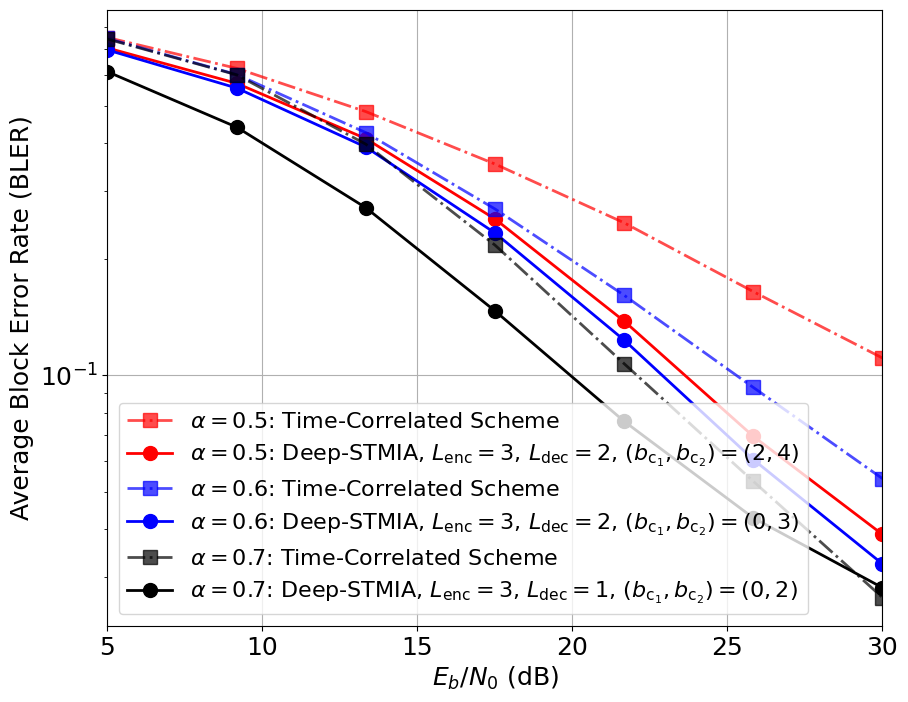

In [ ]:
# alph = training_alph
Eb_N0_dB_eval_num = 7
Eb_N0_dB_eval = np.linspace(5,30,Eb_N0_dB_eval_num)

# alph = 0.5
mean_BLER1_base = np.array([0.75172, 0.62542, 0.48307, 0.35323, 0.24868, 0.16489, 0.11095])
label1_base = r'$\alpha = 0.5$: Time-Correlated Scheme'

mean_BLER1 = np.array([0.70616, 0.57194, 0.41113, 0.25446, 0.13830, 0.06952, 0.03870])
label1 = r'$\alpha = 0.5$: Deep-STMIA, $L_\text{enc} = 3$, $L_\text{dec} = 2$, $(b_{\text{c}_1},b_{\text{c}_2})=(2, 4)$'

# alph = 0.6
mean_BLER2_base = np.array([0.74735, 0.60282, 0.42608, 0.27014, 0.16137, 0.09308, 0.05401])
label2_base = r'$\alpha = 0.6$: Time-Correlated Scheme'

mean_BLER2 = np.array([0.69782, 0.55609, 0.39089, 0.23408, 0.12347, 0.06052, 0.03246])
label2 = r'$\alpha = 0.6$: Deep-STMIA, $L_\text{enc} = 3$, $L_\text{dec} = 2$, $(b_{\text{c}_1},b_{\text{c}_2})=(0, 3)$'

# alph = 0.7
mean_BLER3_base = np.array([0.74472, 0.60172, 0.39769, 0.21769, 0.10726, 0.05314, 0.02656]) # 100_000 samples
label3_base = r'$\alpha = 0.7$: Time-Correlated Scheme'

mean_BLER3 = np.array([0.61286, 0.44026, 0.27214, 0.14696, 0.07603, 0.04272, 0.02816])
label3 = r'$\alpha = 0.7$: Deep-STMIA, $L_\text{enc} = 3$, $L_\text{dec} = 1$, $(b_{\text{c}_1},b_{\text{c}_2})=(0, 2)$'

# --- BLER plot ---
plt.figure(fig_count+1,figsize=(10, 8))
BLER_plot1_base, = plt.plot(Eb_N0_dB_eval, mean_BLER1_base, 'r-.s', markersize=10, linewidth = 2, label = label1_base)
BLER_plot1_base.set_alpha(0.7)
BLER_plot1, = plt.plot(Eb_N0_dB_eval, mean_BLER1, 'r-o', markersize=10, linewidth = 2, label = label1)

BLER_plot2_base, = plt.plot(Eb_N0_dB_eval, mean_BLER2_base, 'b-.s', markersize=10, linewidth = 2, label = label2_base)
BLER_plot2_base.set_alpha(0.7)
BLER_plot2, = plt.plot(Eb_N0_dB_eval, mean_BLER2, 'b-o', markersize=10, linewidth = 2, label = label2)

BLER_plot3_base, = plt.plot(Eb_N0_dB_eval, mean_BLER3_base, 'k-.s', markersize=10, linewidth = 2, label = label3_base)
BLER_plot3_base.set_alpha(0.7)
BLER_plot3, = plt.plot(Eb_N0_dB_eval, mean_BLER3, 'k-o', markersize=10, linewidth = 2, label = label3)

plt.legend(loc = 'best', fontsize = 16)
plt.xlabel(r'$E_b/N_0$' + ' (dB)', fontsize = 18)
plt.ylabel('Average Block Error Rate (BLER)', fontsize = 18)
plt.xlim([min(Eb_N0_dB_eval),max(Eb_N0_dB_eval)])
plt.yscale("log")
plt.tick_params(axis='both', labelsize=18)
#plt.title('BLER vs. ' + r'$E_b/N_0$ [1, Figure 18]', fontsize = 18)
plt.grid()
plt.savefig(f'BLER_All_IA.png')